# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/data_obs.root')
file_sig = ROOT.RDataFrame('emu_tree', {'root_raw/em18_raw/ggH_bbtt*.root', 'root_raw/em18_raw/vbf_bbtt*.root'})
file_ZTT = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/embedded.root')
file_TT = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/TT*.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

In [3]:
# 2b events
for i in range(len(files)):
    files[i] = files[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184')\
    .Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.4184')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mymu+mymet).Pt(),(myele+mymu+mymet).Eta(),(myele+mymu+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_2,beta_deepcsv_2,bphi_deepcsv_2,bm_deepcsv_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1e = '(myele+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
m_b2e = '(myele+myb2).M()'
m_b2mu = '(mymu+myb2).M()'
m_bbe = '(myb1+myb2+myele).M()'
m_bbmu = '(myb1+myb2+mymu).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mymu)'
dR_b1e = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b2e = 'ROOT::Math::VectorUtil::DeltaR(myele,myb2)'
dR_b2mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbe = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,myele)'
dR_bbmu = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mymu)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_e = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
mT_tt = 'sqrt(pow(mytt.Pt()+mymet.Pt(),2)-pow(mytt.Px()+mymet.Px(),2)-pow(mytt.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt(),2)+pow(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mymu.Px())*x_zeta+(myele.Py()+mymu.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2e', m_b2e)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbe', m_bbe)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2e', dR_b2e)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbe', dR_bbe)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('mT_tt', mT_tt)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [6]:
# 2018 e+mu trigger requirements
triggerMu8E23 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
triggerMu23E12 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger = triggerMu8E23 + str(' or ') + triggerMu23E12

for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('iso_1<0.10 && iso_2<0.15')\
    .Filter('dR_tt>0.3')\
    .Filter(trigger)#same triggers for all

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('(gen_match_1<3 or gen_match_1==6) && (gen_match_2<3 or gen_match_2==6)')

files[1] = files[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files[1] = files[1].Filter('m_b1tt<250')#reject long tail (mostly wrongly reco b jet)

#####for 2b only, remove long tails to reject wrongly reco b jet
files[1] = files[1].Filter('m_bbtt<400').Filter('m_bb<150').Filter('dm_a<2.0')

# QCD region
qcd = files[0].Filter('q_1*q_2>0')

# signal region
for i in range(1,len(files)):
    files[i] = files[i].Filter('q_1*q_2<0')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [7]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'pt_2', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1e', 'm_b1mu', 'm_b2e', 'm_b2mu', 'dm_a',\
                'm_b1tt', 'm_b2tt', 'm_bbe', 'm_bbmu', 'dR_tt', 'dR_b1e', 'dR_b1mu', 'dR_b2e', 'dR_b2mu', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbe','dR_bbmu', 'tt_pt', 'tt_eta', 'mT_e', 'mT_mu', 'mT_b1', 'mT_b2', 'mT_tt', 'norm_zeta', 'Dzeta',\
                'bpt_deepcsv_1', 'bpt_deepcsv_2', 'met', 'njets']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))
    print(i)
qcd = pd.DataFrame(qcd.AsNumpy(feature_list))
print('qcd')

# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
files[2]['label'] = np.zeros((files[2].shape[0], 1))
files[3]['label'] = np.zeros((files[3].shape[0], 1))
qcd['label'] = np.zeros((qcd.shape[0],1))

for i in range(1,len(files)):
    print(str(files[i].shape))
print(str(qcd.shape))

1
2
3
qcd
(2259, 38)
(41536, 38)
(2140763, 38)
(2032, 38)


## Split into MC/data

In [8]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 600, random_state = 20)#Z->tautau
files[3] = files[3].sample(n = 900, random_state = 20)#ttbar
qcd = qcd.sample(n = 759, random_state = 20)


# collect all MC as one dataframe, separated from another datafream for observed data
#df_obs = files[0]
df_MC = [files[1], files[2], files[3], qcd]

df_MC = pd.concat(df_MC)


#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
          pt_1       pt_2      m_b1tt      m_b2tt      m_bbtt        m_bb  \
0    29.107235  18.294874   91.255332  179.665113  202.472979   31.428714   
1    20.599541  32.355339   99.761484   85.292174  130.994988   22.748021   
2    15.945243  29.081043   80.927540  106.345336  134.602424   24.311125   
3    37.340313  16.079292   79.084610   73.028000  106.720396   15.848661   
4    31.137592  14.166610  112.442482  124.809945  168.977598   26.577777   
..         ...        ...         ...         ...         ...         ...   
189  35.449883  25.231815  177.289534  254.625787  307.762191   89.240268   
974  15.175305  44.828556  613.622750  504.167470  691.436590  180.609014   
834  36.034668  28.983641  301.519569  383.775868  429.945991   90.817161   
672  27.813881  48.004475  175.512487  162.775019  318.552941  220.196627   
545  57.905464  41.420364  681.520862  727.708567  799.128726  150.488655   

          m_b1e      m_b1mu       m_b2e      m_b2mu  ...   

## Compare input feature distributions between sig and bkg

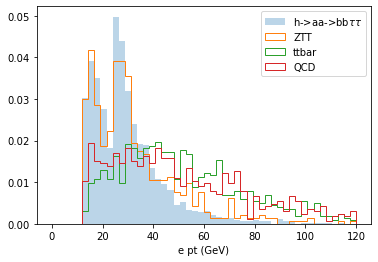

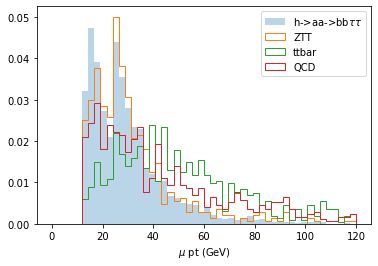

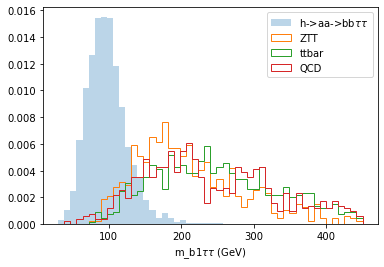

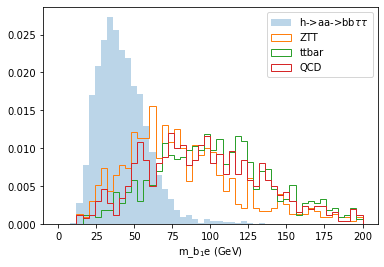

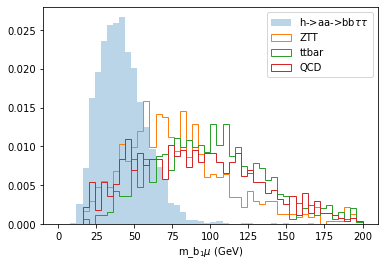

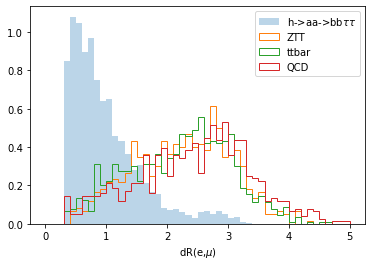

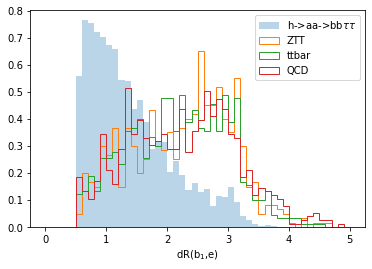

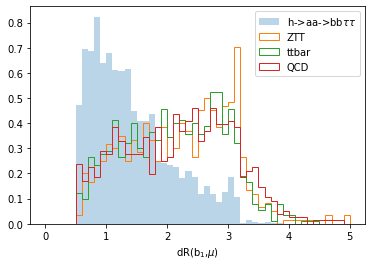

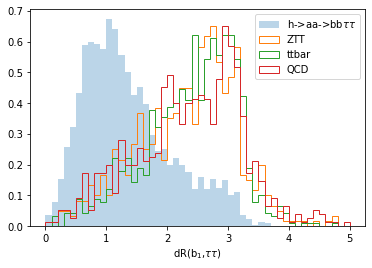

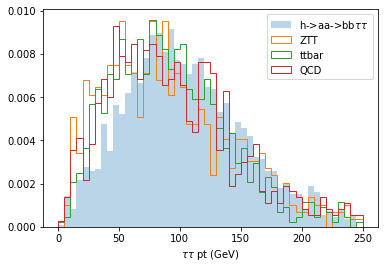

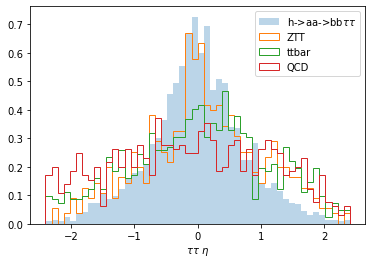

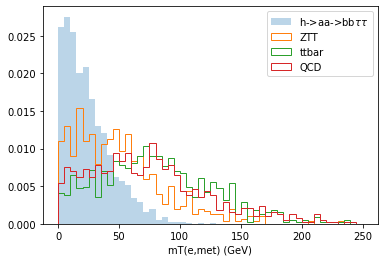

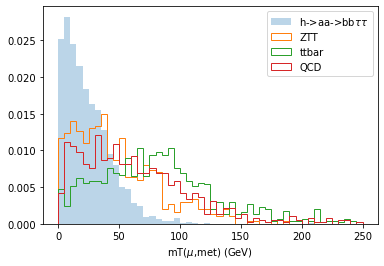

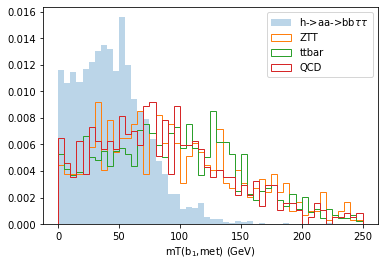

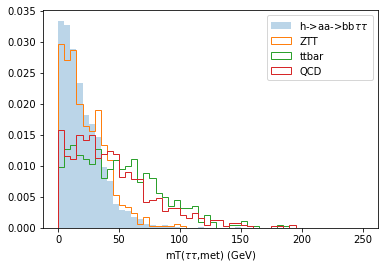

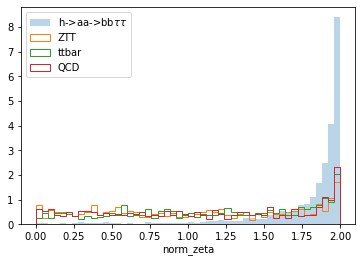

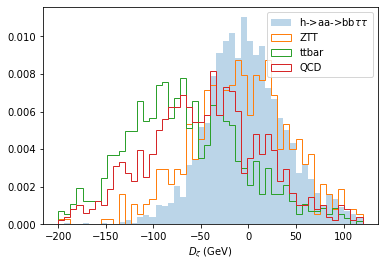

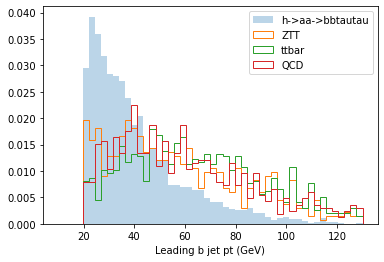

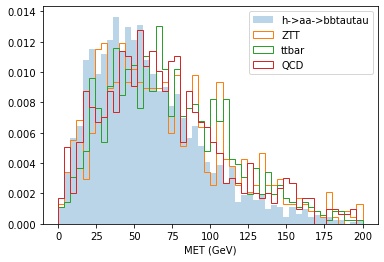

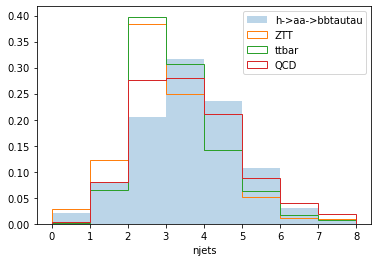

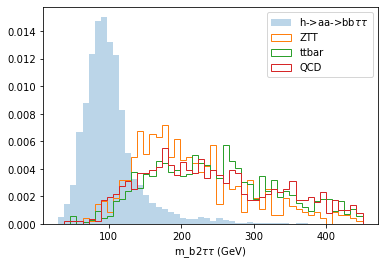

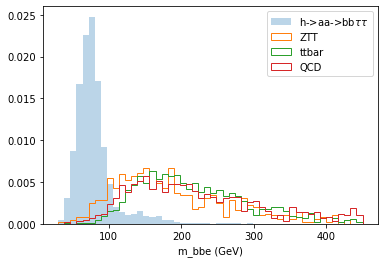

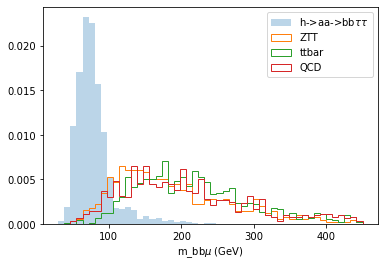

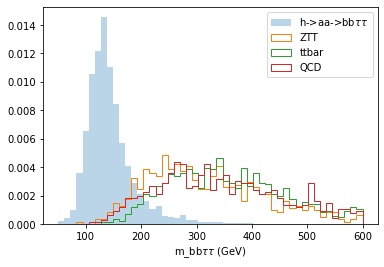

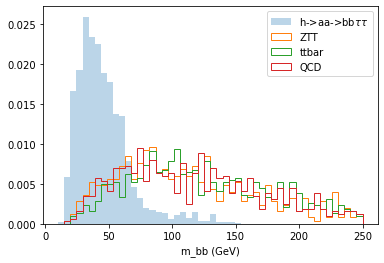

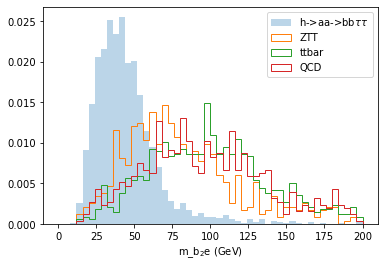

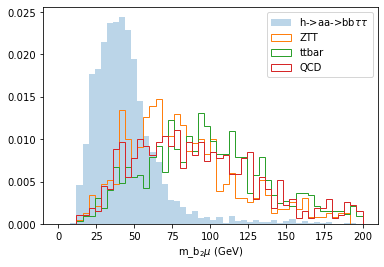

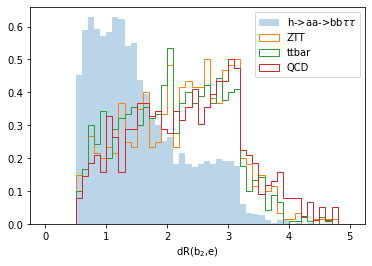

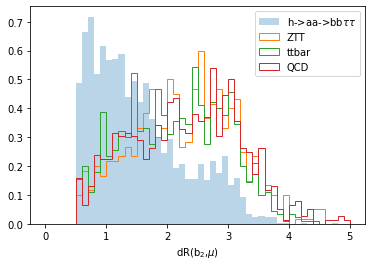

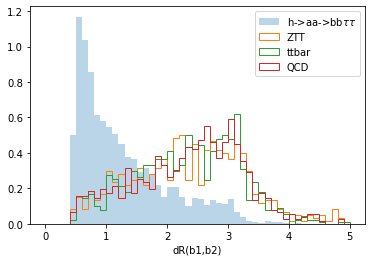

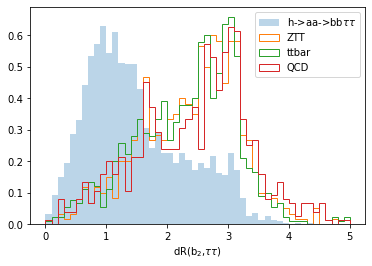

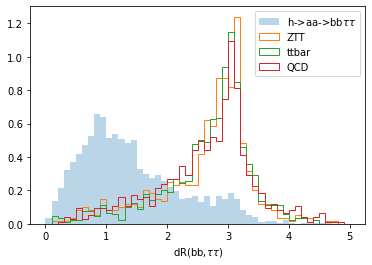

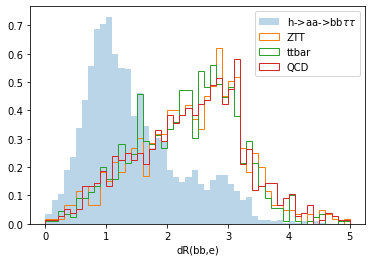

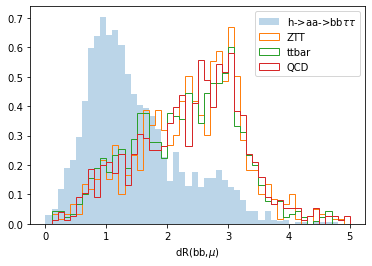

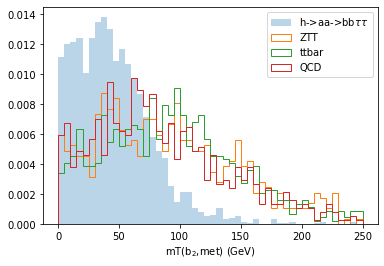

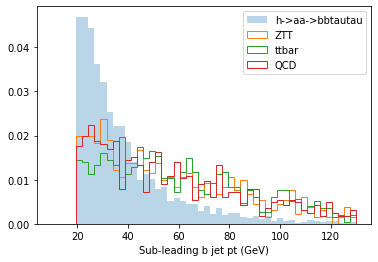

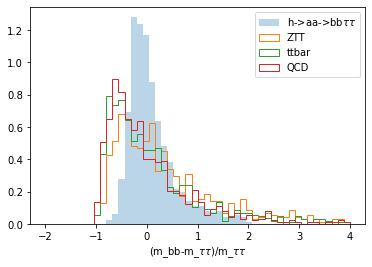

In [9]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(files[1]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()


pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()


pyplot.hist(files[1]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_e'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau\\tau$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'best')
pyplot.xlabel('norm_zeta')
pyplot.show()

pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()


############## for 2b events
pyplot.hist(files[1]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbe'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bbe (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2e'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$e (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2e'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,e)')
pyplot.show()

pyplot.hist(files[1]['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(files[1]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(files[1]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(files[1]['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bbe'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,e)')
pyplot.show()

pyplot.hist(files[1]['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()


## Input data pre-processing

In [10]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]


# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)


# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (2710, 37)
Y_train.shape: (2710, 1)
X_val.shape: (904, 37)
Y_val.shape: (904, 1)
X_test.shape: (904, 37)
Y_test.shape: (904, 1)

Total number of sig/bkg examples: 2259/2259 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 1374/1336 (50.7%/49.3%)
val   : 443/461 (49.0%/51.0%)
test  : 442/462 (48.9%/51.1%)


## DNN Hyperparameters searching

In [11]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 40,
                                                   max_value = 100,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 40,
                                                   max_value = 100,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [12]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 30,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-02-16 00:02:06.430285: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-16 00:02:06.430624: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [13]:
# run the search
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val,Y_val), batch_size = 128)

Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 12s - loss: 0.7012 - accuracy: 0.554 - ETA: 0s - loss: 0.6226 - accuracy: 0.636 - ETA: 0s - loss: 0.5144 - accuracy: 0.73 - 1s 341us/sample - loss: 0.4770 - accuracy: 0.7624 - val_loss: 0.2279 - val_accuracy: 0.9347
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.92 - ETA: 0s - loss: 0.2385 - accuracy: 0.92 - ETA: 0s - loss: 0.2224 - accuracy: 0.92 - 0s 72us/sample - loss: 0.2233 - accuracy: 0.9210 - val_loss: 0.1458 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.9356 - accuracy: 0.343 - ETA: 0s - loss: 0.7568 - accuracy: 0.518 - ETA: 0s - loss: 0.6414 - accuracy: 0.63 - 1s 292us/sample - loss: 0.6297 - accuracy: 0.6424 - val_loss: 0.3434 - val_accuracy: 0.9237
Epoch 2/2
2710/2710 [==============================] - ETA: 1s - loss: 0.3674 - accuracy: 0.85 - ETA: 0s - loss: 0.3747 - accuracy: 0.85 - ETA: 0s - loss: 0.3476 - accuracy: 0.86 - 0s 89us/sample - loss: 0.3367 - accuracy: 0.8672 - val_loss: 0.1945 - val_accuracy: 0.9369


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.7681 - accuracy: 0.52 - ETA: 0s - loss: 0.6044 - accuracy: 0.67 - ETA: 0s - loss: 0.5013 - accuracy: 0.75 - 1s 292us/sample - loss: 0.4616 - accuracy: 0.7871 - val_loss: 0.2145 - val_accuracy: 0.9535
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.93 - ETA: 0s - loss: 0.2362 - accuracy: 0.92 - ETA: 0s - loss: 0.2188 - accuracy: 0.93 - 0s 75us/sample - loss: 0.2115 - accuracy: 0.9328 - val_loss: 0.1356 - val_accuracy: 0.9558


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.8266 - accuracy: 0.48 - ETA: 0s - loss: 0.6632 - accuracy: 0.65 - ETA: 0s - loss: 0.5212 - accuracy: 0.75 - 1s 294us/sample - loss: 0.4693 - accuracy: 0.7860 - val_loss: 0.1933 - val_accuracy: 0.9392
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.88 - ETA: 0s - loss: 0.2189 - accuracy: 0.91 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - 0s 76us/sample - loss: 0.1933 - accuracy: 0.9280 - val_loss: 0.1318 - val_accuracy: 0.9524


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.8177 - accuracy: 0.48 - ETA: 0s - loss: 0.5658 - accuracy: 0.69 - ETA: 0s - loss: 0.4551 - accuracy: 0.78 - 1s 288us/sample - loss: 0.4334 - accuracy: 0.7963 - val_loss: 0.1960 - val_accuracy: 0.9458
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.89 - ETA: 0s - loss: 0.2275 - accuracy: 0.92 - ETA: 0s - loss: 0.2058 - accuracy: 0.92 - 0s 60us/sample - loss: 0.2010 - accuracy: 0.9288 - val_loss: 0.1320 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8013 - accuracy: 0.507 - ETA: 0s - loss: 0.6503 - accuracy: 0.623 - ETA: 0s - loss: 0.5462 - accuracy: 0.71 - 1s 287us/sample - loss: 0.5249 - accuracy: 0.7362 - val_loss: 0.2717 - val_accuracy: 0.9237
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.93 - ETA: 0s - loss: 0.2804 - accuracy: 0.90 - ETA: 0s - loss: 0.2591 - accuracy: 0.91 - 0s 68us/sample - loss: 0.2511 - accuracy: 0.9214 - val_loss: 0.1620 - val_accuracy: 0.9414


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7900 - accuracy: 0.554 - ETA: 0s - loss: 0.6508 - accuracy: 0.659 - ETA: 0s - loss: 0.5356 - accuracy: 0.73 - 1s 319us/sample - loss: 0.4970 - accuracy: 0.7587 - val_loss: 0.2307 - val_accuracy: 0.9270
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.95 - ETA: 0s - loss: 0.2509 - accuracy: 0.91 - ETA: 0s - loss: 0.2371 - accuracy: 0.91 - 0s 80us/sample - loss: 0.2275 - accuracy: 0.9221 - val_loss: 0.1495 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 11s - loss: 0.7901 - accuracy: 0.554 - ETA: 0s - loss: 0.6193 - accuracy: 0.705 - ETA: 0s - loss: 0.5124 - accuracy: 0.78 - 1s 336us/sample - loss: 0.4580 - accuracy: 0.8114 - val_loss: 0.2077 - val_accuracy: 0.9524
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.95 - ETA: 0s - loss: 0.2113 - accuracy: 0.92 - ETA: 0s - loss: 0.1934 - accuracy: 0.93 - 0s 67us/sample - loss: 0.1891 - accuracy: 0.9376 - val_loss: 0.1302 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7719 - accuracy: 0.531 - ETA: 0s - loss: 0.6015 - accuracy: 0.642 - ETA: 0s - loss: 0.4744 - accuracy: 0.76 - 1s 308us/sample - loss: 0.4296 - accuracy: 0.8018 - val_loss: 0.1984 - val_accuracy: 0.9491
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.95 - ETA: 0s - loss: 0.2058 - accuracy: 0.94 - ETA: 0s - loss: 0.1879 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1860 - accuracy: 0.9399 - val_loss: 0.1275 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.7913 - accuracy: 0.42 - ETA: 0s - loss: 0.5888 - accuracy: 0.70 - ETA: 0s - loss: 0.4778 - accuracy: 0.79 - 1s 293us/sample - loss: 0.4456 - accuracy: 0.8096 - val_loss: 0.1972 - val_accuracy: 0.9513
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - ETA: 0s - loss: 0.2037 - accuracy: 0.95 - ETA: 0s - loss: 0.1849 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1772 - accuracy: 0.9476 - val_loss: 0.1256 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7252 - accuracy: 0.562 - ETA: 0s - loss: 0.5442 - accuracy: 0.744 - ETA: 0s - loss: 0.4723 - accuracy: 0.79 - 1s 298us/sample - loss: 0.4282 - accuracy: 0.8229 - val_loss: 0.2092 - val_accuracy: 0.9336
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.89 - ETA: 0s - loss: 0.2186 - accuracy: 0.91 - ETA: 0s - loss: 0.1975 - accuracy: 0.92 - 0s 77us/sample - loss: 0.1841 - accuracy: 0.9325 - val_loss: 0.1367 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6923 - accuracy: 0.445 - ETA: 0s - loss: 0.5055 - accuracy: 0.758 - ETA: 0s - loss: 0.4105 - accuracy: 0.82 - 1s 299us/sample - loss: 0.3620 - accuracy: 0.8480 - val_loss: 0.1662 - val_accuracy: 0.9392
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.92 - ETA: 0s - loss: 0.1606 - accuracy: 0.94 - ETA: 0s - loss: 0.1635 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1552 - accuracy: 0.9446 - val_loss: 0.1238 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6435 - accuracy: 0.640 - ETA: 0s - loss: 0.5101 - accuracy: 0.767 - ETA: 0s - loss: 0.4204 - accuracy: 0.82 - 1s 290us/sample - loss: 0.4033 - accuracy: 0.8384 - val_loss: 0.1931 - val_accuracy: 0.9403
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.91 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - ETA: 0s - loss: 0.1920 - accuracy: 0.93 - 0s 70us/sample - loss: 0.1854 - accuracy: 0.9380 - val_loss: 0.1351 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.7551 - accuracy: 0.46 - ETA: 0s - loss: 0.6556 - accuracy: 0.58 - ETA: 0s - loss: 0.5414 - accuracy: 0.71 - 1s 294us/sample - loss: 0.4954 - accuracy: 0.7535 - val_loss: 0.2276 - val_accuracy: 0.9403
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.96 - ETA: 0s - loss: 0.2344 - accuracy: 0.92 - ETA: 0s - loss: 0.2069 - accuracy: 0.93 - 0s 76us/sample - loss: 0.2062 - accuracy: 0.9365 - val_loss: 0.1420 - val_accuracy: 0.9414


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.8823 - accuracy: 0.30 - ETA: 0s - loss: 0.7357 - accuracy: 0.47 - ETA: 0s - loss: 0.6142 - accuracy: 0.63 - 1s 285us/sample - loss: 0.6039 - accuracy: 0.6443 - val_loss: 0.3512 - val_accuracy: 0.9447
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.90 - ETA: 0s - loss: 0.3531 - accuracy: 0.88 - ETA: 0s - loss: 0.3123 - accuracy: 0.89 - 0s 70us/sample - loss: 0.3029 - accuracy: 0.9026 - val_loss: 0.1713 - val_accuracy: 0.9524


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.7112 - accuracy: 0.53 - ETA: 0s - loss: 0.5612 - accuracy: 0.69 - ETA: 0s - loss: 0.4688 - accuracy: 0.78 - 1s 291us/sample - loss: 0.4504 - accuracy: 0.7930 - val_loss: 0.2231 - val_accuracy: 0.9369
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.92 - ETA: 0s - loss: 0.2430 - accuracy: 0.91 - ETA: 0s - loss: 0.2231 - accuracy: 0.92 - 0s 86us/sample - loss: 0.2148 - accuracy: 0.9240 - val_loss: 0.1361 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7288 - accuracy: 0.601 - ETA: 0s - loss: 0.5923 - accuracy: 0.709 - ETA: 0s - loss: 0.4793 - accuracy: 0.78 - 1s 297us/sample - loss: 0.4347 - accuracy: 0.8103 - val_loss: 0.1873 - val_accuracy: 0.9425
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2784 - accuracy: 0.89 - ETA: 0s - loss: 0.2430 - accuracy: 0.91 - ETA: 0s - loss: 0.2059 - accuracy: 0.92 - 0s 77us/sample - loss: 0.1987 - accuracy: 0.9306 - val_loss: 0.1331 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8020 - accuracy: 0.468 - ETA: 0s - loss: 0.6209 - accuracy: 0.659 - ETA: 0s - loss: 0.4858 - accuracy: 0.77 - 1s 294us/sample - loss: 0.4518 - accuracy: 0.8011 - val_loss: 0.2066 - val_accuracy: 0.9425
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.94 - ETA: 0s - loss: 0.1995 - accuracy: 0.93 - ETA: 0s - loss: 0.1832 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1816 - accuracy: 0.9417 - val_loss: 0.1341 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6030 - accuracy: 0.695 - ETA: 0s - loss: 0.4668 - accuracy: 0.817 - ETA: 0s - loss: 0.3913 - accuracy: 0.85 - 1s 291us/sample - loss: 0.3729 - accuracy: 0.8657 - val_loss: 0.2017 - val_accuracy: 0.9392
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.93 - ETA: 0s - loss: 0.2065 - accuracy: 0.93 - ETA: 0s - loss: 0.1995 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1952 - accuracy: 0.9347 - val_loss: 0.1463 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6930 - accuracy: 0.601 - ETA: 0s - loss: 0.5033 - accuracy: 0.782 - ETA: 0s - loss: 0.4098 - accuracy: 0.84 - 1s 291us/sample - loss: 0.3819 - accuracy: 0.8561 - val_loss: 0.1789 - val_accuracy: 0.9469
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - ETA: 0s - loss: 0.1869 - accuracy: 0.93 - ETA: 0s - loss: 0.1626 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1574 - accuracy: 0.9469 - val_loss: 0.1226 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.8599 - accuracy: 0.46 - ETA: 0s - loss: 0.6300 - accuracy: 0.67 - ETA: 0s - loss: 0.5446 - accuracy: 0.73 - 1s 287us/sample - loss: 0.5256 - accuracy: 0.7513 - val_loss: 0.2758 - val_accuracy: 0.9392
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.90 - ETA: 0s - loss: 0.2871 - accuracy: 0.90 - ETA: 0s - loss: 0.2665 - accuracy: 0.91 - 0s 69us/sample - loss: 0.2617 - accuracy: 0.9148 - val_loss: 0.1728 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7271 - accuracy: 0.523 - ETA: 0s - loss: 0.5596 - accuracy: 0.715 - ETA: 0s - loss: 0.4674 - accuracy: 0.78 - 1s 289us/sample - loss: 0.4523 - accuracy: 0.8000 - val_loss: 0.2321 - val_accuracy: 0.9347
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.89 - ETA: 0s - loss: 0.2558 - accuracy: 0.91 - ETA: 0s - loss: 0.2334 - accuracy: 0.92 - 0s 70us/sample - loss: 0.2263 - accuracy: 0.9229 - val_loss: 0.1541 - val_accuracy: 0.9403


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.9318 - accuracy: 0.523 - ETA: 0s - loss: 0.7472 - accuracy: 0.596 - ETA: 0s - loss: 0.6180 - accuracy: 0.69 - 1s 287us/sample - loss: 0.6041 - accuracy: 0.7030 - val_loss: 0.3048 - val_accuracy: 0.9226
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.83 - ETA: 0s - loss: 0.3287 - accuracy: 0.88 - ETA: 0s - loss: 0.2916 - accuracy: 0.89 - 0s 64us/sample - loss: 0.2905 - accuracy: 0.8978 - val_loss: 0.1697 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8237 - accuracy: 0.585 - ETA: 0s - loss: 0.6752 - accuracy: 0.608 - ETA: 0s - loss: 0.5736 - accuracy: 0.69 - 1s 290us/sample - loss: 0.5524 - accuracy: 0.7137 - val_loss: 0.2834 - val_accuracy: 0.9347
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.89 - ETA: 0s - loss: 0.3170 - accuracy: 0.88 - ETA: 0s - loss: 0.2833 - accuracy: 0.89 - 0s 71us/sample - loss: 0.2781 - accuracy: 0.9026 - val_loss: 0.1629 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6498 - accuracy: 0.554 - ETA: 0s - loss: 0.5045 - accuracy: 0.750 - ETA: 0s - loss: 0.4261 - accuracy: 0.81 - 1s 290us/sample - loss: 0.4162 - accuracy: 0.8181 - val_loss: 0.2049 - val_accuracy: 0.9502
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.90 - ETA: 0s - loss: 0.2170 - accuracy: 0.93 - ETA: 0s - loss: 0.1922 - accuracy: 0.93 - 0s 68us/sample - loss: 0.1912 - accuracy: 0.9362 - val_loss: 0.1321 - val_accuracy: 0.9535


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.5789 - accuracy: 0.726 - ETA: 0s - loss: 0.4893 - accuracy: 0.785 - ETA: 0s - loss: 0.3910 - accuracy: 0.84 - 1s 294us/sample - loss: 0.3733 - accuracy: 0.8535 - val_loss: 0.1694 - val_accuracy: 0.9436
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.90 - ETA: 0s - loss: 0.1932 - accuracy: 0.93 - ETA: 0s - loss: 0.1767 - accuracy: 0.93 - 0s 74us/sample - loss: 0.1656 - accuracy: 0.9432 - val_loss: 0.1211 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7646 - accuracy: 0.539 - ETA: 0s - loss: 0.5927 - accuracy: 0.676 - ETA: 0s - loss: 0.5035 - accuracy: 0.75 - 1s 296us/sample - loss: 0.4757 - accuracy: 0.7749 - val_loss: 0.2520 - val_accuracy: 0.9259
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.90 - ETA: 0s - loss: 0.2706 - accuracy: 0.91 - ETA: 0s - loss: 0.2454 - accuracy: 0.91 - 0s 76us/sample - loss: 0.2331 - accuracy: 0.9173 - val_loss: 0.1626 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.7895 - accuracy: 0.43 - ETA: 0s - loss: 0.6494 - accuracy: 0.60 - ETA: 0s - loss: 0.5548 - accuracy: 0.71 - 1s 297us/sample - loss: 0.5026 - accuracy: 0.7561 - val_loss: 0.2735 - val_accuracy: 0.9336
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.82 - ETA: 0s - loss: 0.2611 - accuracy: 0.92 - ETA: 0s - loss: 0.2438 - accuracy: 0.92 - 0s 73us/sample - loss: 0.2322 - accuracy: 0.9306 - val_loss: 0.1604 - val_accuracy: 0.9369


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.9349 - accuracy: 0.367 - ETA: 0s - loss: 0.6590 - accuracy: 0.612 - ETA: 0s - loss: 0.5187 - accuracy: 0.73 - 1s 299us/sample - loss: 0.4742 - accuracy: 0.7627 - val_loss: 0.1971 - val_accuracy: 0.9325
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.93 - ETA: 0s - loss: 0.2000 - accuracy: 0.93 - ETA: 0s - loss: 0.1937 - accuracy: 0.93 - 0s 75us/sample - loss: 0.1853 - accuracy: 0.9373 - val_loss: 0.1314 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6252 - accuracy: 0.593 - ETA: 0s - loss: 0.4868 - accuracy: 0.777 - ETA: 0s - loss: 0.3912 - accuracy: 0.84 - 1s 292us/sample - loss: 0.3659 - accuracy: 0.8546 - val_loss: 0.1760 - val_accuracy: 0.9347
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.92 - ETA: 0s - loss: 0.1729 - accuracy: 0.94 - ETA: 0s - loss: 0.1596 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1597 - accuracy: 0.9465 - val_loss: 0.1249 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.6702 - accuracy: 0.55 - ETA: 0s - loss: 0.5490 - accuracy: 0.71 - ETA: 0s - loss: 0.4510 - accuracy: 0.78 - 1s 291us/sample - loss: 0.4365 - accuracy: 0.7974 - val_loss: 0.2133 - val_accuracy: 0.9303
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.89 - ETA: 0s - loss: 0.2322 - accuracy: 0.91 - ETA: 0s - loss: 0.2143 - accuracy: 0.91 - 0s 72us/sample - loss: 0.2103 - accuracy: 0.9210 - val_loss: 0.1412 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.6628 - accuracy: 0.60 - ETA: 0s - loss: 0.5257 - accuracy: 0.76 - ETA: 0s - loss: 0.4346 - accuracy: 0.83 - 1s 290us/sample - loss: 0.4193 - accuracy: 0.8417 - val_loss: 0.2085 - val_accuracy: 0.9425
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.92 - ETA: 0s - loss: 0.2300 - accuracy: 0.92 - ETA: 0s - loss: 0.1987 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1944 - accuracy: 0.9373 - val_loss: 0.1346 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7095 - accuracy: 0.554 - ETA: 0s - loss: 0.5616 - accuracy: 0.725 - ETA: 0s - loss: 0.4771 - accuracy: 0.79 - 1s 295us/sample - loss: 0.4451 - accuracy: 0.8181 - val_loss: 0.2311 - val_accuracy: 0.9381
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.94 - ETA: 0s - loss: 0.2251 - accuracy: 0.92 - ETA: 0s - loss: 0.2119 - accuracy: 0.92 - 0s 74us/sample - loss: 0.2047 - accuracy: 0.9277 - val_loss: 0.1428 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 9s - loss: 0.7807 - accuracy: 0.51 - ETA: 0s - loss: 0.6751 - accuracy: 0.59 - ETA: 0s - loss: 0.5797 - accuracy: 0.69 - 1s 291us/sample - loss: 0.5584 - accuracy: 0.7140 - val_loss: 0.2897 - val_accuracy: 0.9303
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.87 - ETA: 0s - loss: 0.3125 - accuracy: 0.88 - ETA: 0s - loss: 0.2889 - accuracy: 0.89 - 0s 70us/sample - loss: 0.2794 - accuracy: 0.9015 - val_loss: 0.1601 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8235 - accuracy: 0.460 - ETA: 0s - loss: 0.6271 - accuracy: 0.654 - ETA: 0s - loss: 0.5259 - accuracy: 0.75 - 1s 292us/sample - loss: 0.5059 - accuracy: 0.7705 - val_loss: 0.2494 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.93 - ETA: 0s - loss: 0.2593 - accuracy: 0.92 - ETA: 0s - loss: 0.2316 - accuracy: 0.93 - 0s 64us/sample - loss: 0.2201 - accuracy: 0.9328 - val_loss: 0.1422 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6310 - accuracy: 0.625 - ETA: 0s - loss: 0.4989 - accuracy: 0.770 - ETA: 0s - loss: 0.4087 - accuracy: 0.82 - 1s 291us/sample - loss: 0.3996 - accuracy: 0.8339 - val_loss: 0.1911 - val_accuracy: 0.9458
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.96 - ETA: 0s - loss: 0.1993 - accuracy: 0.94 - ETA: 0s - loss: 0.1846 - accuracy: 0.94 - 0s 76us/sample - loss: 0.1766 - accuracy: 0.9417 - val_loss: 0.1283 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 9s - loss: 1.0448 - accuracy: 0.45 - ETA: 0s - loss: 0.7733 - accuracy: 0.59 - ETA: 0s - loss: 0.6212 - accuracy: 0.69 - 1s 295us/sample - loss: 0.5635 - accuracy: 0.7321 - val_loss: 0.2414 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.92 - ETA: 0s - loss: 0.2463 - accuracy: 0.92 - ETA: 0s - loss: 0.2236 - accuracy: 0.93 - 0s 79us/sample - loss: 0.2163 - accuracy: 0.9310 - val_loss: 0.1371 - val_accuracy: 0.9513


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7827 - accuracy: 0.437 - ETA: 0s - loss: 0.6053 - accuracy: 0.678 - ETA: 0s - loss: 0.4833 - accuracy: 0.78 - 1s 293us/sample - loss: 0.4524 - accuracy: 0.8066 - val_loss: 0.2054 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.94 - ETA: 0s - loss: 0.2151 - accuracy: 0.93 - ETA: 0s - loss: 0.1953 - accuracy: 0.93 - 0s 65us/sample - loss: 0.1871 - accuracy: 0.9406 - val_loss: 0.1278 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 9s - loss: 0.6997 - accuracy: 0.57 - ETA: 0s - loss: 0.5367 - accuracy: 0.75 - ETA: 0s - loss: 0.4486 - accuracy: 0.81 - 1s 286us/sample - loss: 0.4296 - accuracy: 0.8255 - val_loss: 0.2216 - val_accuracy: 0.9369
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.91 - ETA: 0s - loss: 0.2401 - accuracy: 0.91 - ETA: 0s - loss: 0.2144 - accuracy: 0.92 - 0s 74us/sample - loss: 0.2110 - accuracy: 0.9295 - val_loss: 0.1431 - val_accuracy: 0.9513


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6146 - accuracy: 0.679 - ETA: 0s - loss: 0.4949 - accuracy: 0.759 - ETA: 0s - loss: 0.3868 - accuracy: 0.83 - 1s 293us/sample - loss: 0.3632 - accuracy: 0.8469 - val_loss: 0.1683 - val_accuracy: 0.9480
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.94 - ETA: 0s - loss: 0.1743 - accuracy: 0.94 - ETA: 0s - loss: 0.1688 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1656 - accuracy: 0.9406 - val_loss: 0.1214 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8543 - accuracy: 0.382 - ETA: 0s - loss: 0.6801 - accuracy: 0.581 - ETA: 0s - loss: 0.5655 - accuracy: 0.69 - 1s 293us/sample - loss: 0.5165 - accuracy: 0.7354 - val_loss: 0.2466 - val_accuracy: 0.9314
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.91 - ETA: 0s - loss: 0.2408 - accuracy: 0.92 - ETA: 0s - loss: 0.2217 - accuracy: 0.92 - 0s 70us/sample - loss: 0.2133 - accuracy: 0.9299 - val_loss: 0.1459 - val_accuracy: 0.9403


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7067 - accuracy: 0.578 - ETA: 0s - loss: 0.5420 - accuracy: 0.735 - ETA: 0s - loss: 0.4570 - accuracy: 0.79 - 1s 292us/sample - loss: 0.4280 - accuracy: 0.8148 - val_loss: 0.2179 - val_accuracy: 0.9369
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.93 - ETA: 0s - loss: 0.2284 - accuracy: 0.92 - ETA: 0s - loss: 0.1961 - accuracy: 0.93 - 0s 76us/sample - loss: 0.1851 - accuracy: 0.9410 - val_loss: 0.1442 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7194 - accuracy: 0.539 - ETA: 0s - loss: 0.5666 - accuracy: 0.655 - ETA: 0s - loss: 0.4698 - accuracy: 0.76 - 1s 290us/sample - loss: 0.4501 - accuracy: 0.7812 - val_loss: 0.2223 - val_accuracy: 0.9513
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.97 - ETA: 0s - loss: 0.2308 - accuracy: 0.94 - ETA: 0s - loss: 0.1973 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1955 - accuracy: 0.9465 - val_loss: 0.1366 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7555 - accuracy: 0.445 - ETA: 0s - loss: 0.6071 - accuracy: 0.637 - ETA: 0s - loss: 0.5016 - accuracy: 0.74 - 1s 289us/sample - loss: 0.4818 - accuracy: 0.7590 - val_loss: 0.2315 - val_accuracy: 0.9458
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.92 - ETA: 0s - loss: 0.2312 - accuracy: 0.93 - ETA: 0s - loss: 0.2150 - accuracy: 0.93 - 0s 68us/sample - loss: 0.2105 - accuracy: 0.9387 - val_loss: 0.1363 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 9s - loss: 0.7629 - accuracy: 0.49 - ETA: 0s - loss: 0.5937 - accuracy: 0.67 - ETA: 0s - loss: 0.4839 - accuracy: 0.76 - 1s 288us/sample - loss: 0.4624 - accuracy: 0.7793 - val_loss: 0.2128 - val_accuracy: 0.9392
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.93 - ETA: 0s - loss: 0.2150 - accuracy: 0.93 - ETA: 0s - loss: 0.1939 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1964 - accuracy: 0.9373 - val_loss: 0.1288 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7119 - accuracy: 0.632 - ETA: 0s - loss: 0.5329 - accuracy: 0.764 - ETA: 0s - loss: 0.4476 - accuracy: 0.81 - 1s 291us/sample - loss: 0.4267 - accuracy: 0.8321 - val_loss: 0.1979 - val_accuracy: 0.9458
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.93 - ETA: 0s - loss: 0.2201 - accuracy: 0.92 - ETA: 0s - loss: 0.1962 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1896 - accuracy: 0.9373 - val_loss: 0.1297 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7282 - accuracy: 0.554 - ETA: 0s - loss: 0.5675 - accuracy: 0.704 - ETA: 0s - loss: 0.4739 - accuracy: 0.77 - 1s 295us/sample - loss: 0.4313 - accuracy: 0.8052 - val_loss: 0.1948 - val_accuracy: 0.9469
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.90 - ETA: 0s - loss: 0.2084 - accuracy: 0.92 - ETA: 0s - loss: 0.1914 - accuracy: 0.93 - 0s 77us/sample - loss: 0.1855 - accuracy: 0.9362 - val_loss: 0.1277 - val_accuracy: 0.9502
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.95 - ETA: 0s - loss: 0.1675 - accuracy: 0.93 - ETA: 0s - loss: 0.1497 - accuracy: 0.94 - 0s 74us/sample - loss: 0.1460 - accuracy: 0.9454 - val_loss: 0.1097 - val_accuracy: 0.9524
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.93 - ETA: 0s - loss: 0.1106 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8027 - accuracy: 0.359 - ETA: 0s - loss: 0.6572 - accuracy: 0.601 - ETA: 0s - loss: 0.5573 - accuracy: 0.71 - 1s 289us/sample - loss: 0.5405 - accuracy: 0.7258 - val_loss: 0.3055 - val_accuracy: 0.9192
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.91 - ETA: 0s - loss: 0.3021 - accuracy: 0.89 - ETA: 0s - loss: 0.2791 - accuracy: 0.90 - 0s 69us/sample - loss: 0.2712 - accuracy: 0.9044 - val_loss: 0.1728 - val_accuracy: 0.9414
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.97 - ETA: 0s - loss: 0.1896 - accuracy: 0.93 - ETA: 0s - loss: 0.1776 - accuracy: 0.93 - 0s 71us/sample - loss: 0.1772 - accuracy: 0.9380 - val_loss: 0.1307 - val_accuracy: 0.9480
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.94 - ETA: 0s - loss: 0.1477 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8652 - accuracy: 0.367 - ETA: 0s - loss: 0.6252 - accuracy: 0.617 - ETA: 0s - loss: 0.4948 - accuracy: 0.73 - 1s 290us/sample - loss: 0.4708 - accuracy: 0.7576 - val_loss: 0.2084 - val_accuracy: 0.9358
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.90 - ETA: 0s - loss: 0.2206 - accuracy: 0.92 - ETA: 0s - loss: 0.1990 - accuracy: 0.92 - 0s 68us/sample - loss: 0.1914 - accuracy: 0.9292 - val_loss: 0.1283 - val_accuracy: 0.9480
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.96 - ETA: 0s - loss: 0.1407 - accuracy: 0.94 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1322 - accuracy: 0.9509 - val_loss: 0.1105 - val_accuracy: 0.9535
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.1128 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8134 - accuracy: 0.421 - ETA: 0s - loss: 0.6757 - accuracy: 0.549 - ETA: 0s - loss: 0.5735 - accuracy: 0.66 - 1s 293us/sample - loss: 0.5429 - accuracy: 0.6974 - val_loss: 0.2858 - val_accuracy: 0.9159
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.89 - ETA: 0s - loss: 0.2707 - accuracy: 0.91 - ETA: 0s - loss: 0.2523 - accuracy: 0.91 - 0s 72us/sample - loss: 0.2452 - accuracy: 0.9203 - val_loss: 0.1732 - val_accuracy: 0.9325
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.92 - ETA: 0s - loss: 0.2011 - accuracy: 0.92 - ETA: 0s - loss: 0.1671 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1685 - accuracy: 0.9406 - val_loss: 0.1408 - val_accuracy: 0.9414
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.92 - ETA: 0s - loss: 0.1454 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9100 - accuracy: 0.500 - ETA: 0s - loss: 0.6837 - accuracy: 0.590 - ETA: 0s - loss: 0.5454 - accuracy: 0.71 - 1s 294us/sample - loss: 0.5071 - accuracy: 0.7476 - val_loss: 0.2237 - val_accuracy: 0.9414
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.93 - ETA: 0s - loss: 0.2210 - accuracy: 0.93 - ETA: 0s - loss: 0.1980 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1944 - accuracy: 0.9376 - val_loss: 0.1379 - val_accuracy: 0.9425
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1392 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1389 - accuracy: 0.9502 - val_loss: 0.1189 - val_accuracy: 0.9458
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.98 - ETA: 0s - loss: 0.1099 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8159 - accuracy: 0.492 - ETA: 0s - loss: 0.5898 - accuracy: 0.679 - ETA: 0s - loss: 0.4808 - accuracy: 0.76 - 1s 296us/sample - loss: 0.4381 - accuracy: 0.7982 - val_loss: 0.1838 - val_accuracy: 0.9425
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.91 - ETA: 0s - loss: 0.2001 - accuracy: 0.93 - ETA: 0s - loss: 0.1875 - accuracy: 0.93 - 0s 70us/sample - loss: 0.1823 - accuracy: 0.9369 - val_loss: 0.1358 - val_accuracy: 0.9414
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.97 - ETA: 0s - loss: 0.1554 - accuracy: 0.94 - ETA: 0s - loss: 0.1472 - accuracy: 0.94 - 0s 78us/sample - loss: 0.1476 - accuracy: 0.9428 - val_loss: 0.1226 - val_accuracy: 0.9480
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.92 - ETA: 0s - loss: 0.1295 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8016 - accuracy: 0.398 - ETA: 0s - loss: 0.6453 - accuracy: 0.614 - ETA: 0s - loss: 0.5458 - accuracy: 0.73 - 1s 288us/sample - loss: 0.5400 - accuracy: 0.7369 - val_loss: 0.3252 - val_accuracy: 0.9115
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.88 - ETA: 0s - loss: 0.3167 - accuracy: 0.89 - ETA: 0s - loss: 0.2737 - accuracy: 0.91 - 0s 66us/sample - loss: 0.2700 - accuracy: 0.9133 - val_loss: 0.1778 - val_accuracy: 0.9303
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.96 - ETA: 0s - loss: 0.2108 - accuracy: 0.92 - ETA: 0s - loss: 0.1747 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1745 - accuracy: 0.9413 - val_loss: 0.1373 - val_accuracy: 0.9458
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.94 - ETA: 0s - loss: 0.1365 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7427 - accuracy: 0.546 - ETA: 0s - loss: 0.5759 - accuracy: 0.711 - ETA: 0s - loss: 0.4663 - accuracy: 0.78 - 1s 296us/sample - loss: 0.4220 - accuracy: 0.8133 - val_loss: 0.1820 - val_accuracy: 0.9580
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.90 - ETA: 0s - loss: 0.2061 - accuracy: 0.93 - ETA: 0s - loss: 0.1823 - accuracy: 0.94 - 0s 69us/sample - loss: 0.1702 - accuracy: 0.9439 - val_loss: 0.1215 - val_accuracy: 0.9535
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1394 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1364 - accuracy: 0.9565 - val_loss: 0.1105 - val_accuracy: 0.9558
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.94 - ETA: 0s - loss: 0.1263 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7093 - accuracy: 0.578 - ETA: 0s - loss: 0.5758 - accuracy: 0.715 - ETA: 0s - loss: 0.4918 - accuracy: 0.77 - 1s 288us/sample - loss: 0.4727 - accuracy: 0.7919 - val_loss: 0.2662 - val_accuracy: 0.9027
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.89 - ETA: 0s - loss: 0.2962 - accuracy: 0.90 - ETA: 0s - loss: 0.2571 - accuracy: 0.91 - 0s 70us/sample - loss: 0.2540 - accuracy: 0.9181 - val_loss: 0.1689 - val_accuracy: 0.9347
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.92 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - ETA: 0s - loss: 0.1764 - accuracy: 0.93 - 0s 71us/sample - loss: 0.1766 - accuracy: 0.9395 - val_loss: 0.1343 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.98 - ETA: 0s - loss: 0.1413 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8572 - accuracy: 0.406 - ETA: 0s - loss: 0.6743 - accuracy: 0.621 - ETA: 0s - loss: 0.5454 - accuracy: 0.72 - 1s 295us/sample - loss: 0.5236 - accuracy: 0.7380 - val_loss: 0.2487 - val_accuracy: 0.9303
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.90 - ETA: 0s - loss: 0.2627 - accuracy: 0.91 - ETA: 0s - loss: 0.2441 - accuracy: 0.91 - 0s 70us/sample - loss: 0.2416 - accuracy: 0.9144 - val_loss: 0.1534 - val_accuracy: 0.9469
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.91 - ETA: 0s - loss: 0.1583 - accuracy: 0.93 - ETA: 0s - loss: 0.1581 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1614 - accuracy: 0.9384 - val_loss: 0.1285 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.91 - ETA: 0s - loss: 0.1556 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7550 - accuracy: 0.515 - ETA: 0s - loss: 0.5791 - accuracy: 0.705 - ETA: 0s - loss: 0.4943 - accuracy: 0.76 - 1s 286us/sample - loss: 0.4932 - accuracy: 0.7661 - val_loss: 0.2921 - val_accuracy: 0.9148
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.88 - ETA: 0s - loss: 0.3116 - accuracy: 0.89 - ETA: 0s - loss: 0.2804 - accuracy: 0.90 - 0s 64us/sample - loss: 0.2795 - accuracy: 0.9022 - val_loss: 0.1922 - val_accuracy: 0.9303
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.92 - ETA: 0s - loss: 0.2018 - accuracy: 0.93 - ETA: 0s - loss: 0.1922 - accuracy: 0.93 - 0s 66us/sample - loss: 0.1903 - accuracy: 0.9373 - val_loss: 0.1598 - val_accuracy: 0.9369
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.94 - ETA: 0s - loss: 0.1784 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.5482 - accuracy: 0.679 - ETA: 0s - loss: 0.4865 - accuracy: 0.785 - ETA: 0s - loss: 0.4104 - accuracy: 0.84 - 1s 292us/sample - loss: 0.3949 - accuracy: 0.8524 - val_loss: 0.1982 - val_accuracy: 0.9392
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.95 - ETA: 0s - loss: 0.1999 - accuracy: 0.94 - ETA: 0s - loss: 0.1942 - accuracy: 0.93 - 0s 71us/sample - loss: 0.1886 - accuracy: 0.9376 - val_loss: 0.1313 - val_accuracy: 0.9469
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.92 - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1341 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1344 - accuracy: 0.9494 - val_loss: 0.1166 - val_accuracy: 0.9491
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1231 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7609 - accuracy: 0.460 - ETA: 0s - loss: 0.6152 - accuracy: 0.653 - ETA: 0s - loss: 0.5087 - accuracy: 0.74 - 1s 294us/sample - loss: 0.4866 - accuracy: 0.7609 - val_loss: 0.2323 - val_accuracy: 0.9403
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.85 - ETA: 0s - loss: 0.2549 - accuracy: 0.90 - ETA: 0s - loss: 0.2278 - accuracy: 0.91 - 0s 72us/sample - loss: 0.2180 - accuracy: 0.9214 - val_loss: 0.1397 - val_accuracy: 0.9469
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.94 - ETA: 0s - loss: 0.1497 - accuracy: 0.94 - ETA: 0s - loss: 0.1492 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1485 - accuracy: 0.9432 - val_loss: 0.1185 - val_accuracy: 0.9491
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1449 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8825 - accuracy: 0.390 - ETA: 0s - loss: 0.7068 - accuracy: 0.567 - ETA: 0s - loss: 0.5918 - accuracy: 0.67 - 1s 296us/sample - loss: 0.5697 - accuracy: 0.6886 - val_loss: 0.2955 - val_accuracy: 0.9248
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.85 - ETA: 0s - loss: 0.3109 - accuracy: 0.89 - ETA: 0s - loss: 0.2812 - accuracy: 0.90 - 0s 71us/sample - loss: 0.2758 - accuracy: 0.9089 - val_loss: 0.1757 - val_accuracy: 0.9469
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.91 - ETA: 0s - loss: 0.2082 - accuracy: 0.93 - ETA: 0s - loss: 0.1973 - accuracy: 0.92 - 0s 69us/sample - loss: 0.1906 - accuracy: 0.9328 - val_loss: 0.1384 - val_accuracy: 0.9524
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.89 - ETA: 0s - loss: 0.1662 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.9101 - accuracy: 0.367 - ETA: 0s - loss: 0.6802 - accuracy: 0.583 - ETA: 0s - loss: 0.5577 - accuracy: 0.69 - 1s 294us/sample - loss: 0.5331 - accuracy: 0.7203 - val_loss: 0.2383 - val_accuracy: 0.9458
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.87 - ETA: 0s - loss: 0.2493 - accuracy: 0.92 - ETA: 0s - loss: 0.2373 - accuracy: 0.92 - 0s 63us/sample - loss: 0.2342 - accuracy: 0.9277 - val_loss: 0.1449 - val_accuracy: 0.9447
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.92 - ETA: 0s - loss: 0.1795 - accuracy: 0.92 - ETA: 0s - loss: 0.1605 - accuracy: 0.93 - 0s 70us/sample - loss: 0.1642 - accuracy: 0.9376 - val_loss: 0.1236 - val_accuracy: 0.9480
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.94 - ETA: 0s - loss: 0.1358 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.5944 - accuracy: 0.632 - ETA: 0s - loss: 0.5237 - accuracy: 0.731 - ETA: 0s - loss: 0.4304 - accuracy: 0.80 - 1s 290us/sample - loss: 0.4206 - accuracy: 0.8096 - val_loss: 0.2090 - val_accuracy: 0.9314
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.94 - ETA: 0s - loss: 0.2302 - accuracy: 0.93 - ETA: 0s - loss: 0.2128 - accuracy: 0.93 - 0s 71us/sample - loss: 0.2147 - accuracy: 0.9339 - val_loss: 0.1423 - val_accuracy: 0.9414
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.92 - ETA: 0s - loss: 0.1748 - accuracy: 0.93 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1579 - accuracy: 0.9461 - val_loss: 0.1248 - val_accuracy: 0.9436
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.91 - ETA: 0s - loss: 0.1475 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7696 - accuracy: 0.585 - ETA: 0s - loss: 0.6794 - accuracy: 0.612 - ETA: 0s - loss: 0.5726 - accuracy: 0.70 - 1s 293us/sample - loss: 0.5518 - accuracy: 0.7210 - val_loss: 0.2964 - val_accuracy: 0.9181
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.88 - ETA: 0s - loss: 0.3054 - accuracy: 0.88 - ETA: 0s - loss: 0.2654 - accuracy: 0.90 - 0s 72us/sample - loss: 0.2551 - accuracy: 0.9096 - val_loss: 0.1668 - val_accuracy: 0.9447
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1605 - accuracy: 0.9439 - val_loss: 0.1319 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.92 - ETA: 0s - loss: 0.1522 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8802 - accuracy: 0.531 - ETA: 0s - loss: 0.6965 - accuracy: 0.607 - ETA: 0s - loss: 0.6008 - accuracy: 0.67 - 1s 290us/sample - loss: 0.5830 - accuracy: 0.6893 - val_loss: 0.3365 - val_accuracy: 0.9015
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.87 - ETA: 0s - loss: 0.3404 - accuracy: 0.87 - ETA: 0s - loss: 0.3141 - accuracy: 0.88 - 0s 71us/sample - loss: 0.3103 - accuracy: 0.8815 - val_loss: 0.1992 - val_accuracy: 0.9381
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.93 - ETA: 0s - loss: 0.2257 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.92 - 0s 71us/sample - loss: 0.2141 - accuracy: 0.9277 - val_loss: 0.1493 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.93 - ETA: 0s - loss: 0.1882 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8313 - accuracy: 0.390 - ETA: 0s - loss: 0.6264 - accuracy: 0.635 - ETA: 0s - loss: 0.5085 - accuracy: 0.74 - 1s 296us/sample - loss: 0.4735 - accuracy: 0.7697 - val_loss: 0.2033 - val_accuracy: 0.9491
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.91 - ETA: 0s - loss: 0.2093 - accuracy: 0.93 - ETA: 0s - loss: 0.1980 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1919 - accuracy: 0.9362 - val_loss: 0.1275 - val_accuracy: 0.9491
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1479 - accuracy: 0.94 - ETA: 0s - loss: 0.1389 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1437 - accuracy: 0.9443 - val_loss: 0.1114 - val_accuracy: 0.9546
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.96 - ETA: 0s - loss: 0.1392 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8880 - accuracy: 0.382 - ETA: 0s - loss: 0.7251 - accuracy: 0.573 - ETA: 0s - loss: 0.6146 - accuracy: 0.67 - 1s 285us/sample - loss: 0.6128 - accuracy: 0.6734 - val_loss: 0.3229 - val_accuracy: 0.9170
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.84 - ETA: 0s - loss: 0.3497 - accuracy: 0.87 - ETA: 0s - loss: 0.3156 - accuracy: 0.88 - 0s 65us/sample - loss: 0.3116 - accuracy: 0.8845 - val_loss: 0.1855 - val_accuracy: 0.9281
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.93 - ETA: 0s - loss: 0.2379 - accuracy: 0.91 - ETA: 0s - loss: 0.2123 - accuracy: 0.92 - 0s 66us/sample - loss: 0.2123 - accuracy: 0.9247 - val_loss: 0.1489 - val_accuracy: 0.9381
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.96 - ETA: 0s - loss: 0.1642 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6817 - accuracy: 0.601 - ETA: 0s - loss: 0.5426 - accuracy: 0.737 - ETA: 0s - loss: 0.4499 - accuracy: 0.81 - 1s 296us/sample - loss: 0.4194 - accuracy: 0.8284 - val_loss: 0.2012 - val_accuracy: 0.9469
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.92 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - ETA: 0s - loss: 0.1951 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1876 - accuracy: 0.9369 - val_loss: 0.1241 - val_accuracy: 0.9546
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - ETA: 0s - loss: 0.1347 - accuracy: 0.94 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - 0s 77us/sample - loss: 0.1319 - accuracy: 0.9509 - val_loss: 0.1095 - val_accuracy: 0.9591
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.94 - ETA: 0s - loss: 0.1100 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.9239 - accuracy: 0.406 - ETA: 0s - loss: 0.6941 - accuracy: 0.572 - ETA: 0s - loss: 0.5793 - accuracy: 0.67 - 1s 296us/sample - loss: 0.5302 - accuracy: 0.7203 - val_loss: 0.2406 - val_accuracy: 0.9580
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.90 - ETA: 0s - loss: 0.2652 - accuracy: 0.91 - ETA: 0s - loss: 0.2343 - accuracy: 0.92 - 0s 64us/sample - loss: 0.2299 - accuracy: 0.9262 - val_loss: 0.1372 - val_accuracy: 0.9436
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.92 - ETA: 0s - loss: 0.1773 - accuracy: 0.93 - ETA: 0s - loss: 0.1712 - accuracy: 0.93 - 0s 62us/sample - loss: 0.1724 - accuracy: 0.9373 - val_loss: 0.1175 - val_accuracy: 0.9546
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.95 - ETA: 0s - loss: 0.1312 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8044 - accuracy: 0.460 - ETA: 0s - loss: 0.6089 - accuracy: 0.682 - ETA: 0s - loss: 0.5000 - accuracy: 0.77 - 1s 292us/sample - loss: 0.4765 - accuracy: 0.7889 - val_loss: 0.2293 - val_accuracy: 0.9392
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.91 - ETA: 0s - loss: 0.2283 - accuracy: 0.92 - ETA: 0s - loss: 0.2130 - accuracy: 0.93 - 0s 72us/sample - loss: 0.2053 - accuracy: 0.9332 - val_loss: 0.1430 - val_accuracy: 0.9436
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.96 - ETA: 0s - loss: 0.1496 - accuracy: 0.95 - ETA: 0s - loss: 0.1419 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1405 - accuracy: 0.9557 - val_loss: 0.1195 - val_accuracy: 0.9469
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6631 - accuracy: 0.562 - ETA: 0s - loss: 0.5423 - accuracy: 0.726 - ETA: 0s - loss: 0.4409 - accuracy: 0.80 - 1s 300us/sample - loss: 0.4025 - accuracy: 0.8284 - val_loss: 0.1770 - val_accuracy: 0.9447
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.90 - ETA: 0s - loss: 0.1982 - accuracy: 0.93 - ETA: 0s - loss: 0.1857 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1777 - accuracy: 0.9395 - val_loss: 0.1277 - val_accuracy: 0.9414
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.96 - ETA: 0s - loss: 0.1464 - accuracy: 0.94 - ETA: 0s - loss: 0.1392 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1359 - accuracy: 0.9520 - val_loss: 0.1161 - val_accuracy: 0.9491
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.92 - ETA: 0s - loss: 0.1109 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7400 - accuracy: 0.515 - ETA: 0s - loss: 0.6083 - accuracy: 0.673 - ETA: 0s - loss: 0.5089 - accuracy: 0.76 - 1s 296us/sample - loss: 0.4675 - accuracy: 0.7915 - val_loss: 0.2141 - val_accuracy: 0.9425
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.91 - ETA: 0s - loss: 0.2265 - accuracy: 0.92 - ETA: 0s - loss: 0.2145 - accuracy: 0.92 - 0s 73us/sample - loss: 0.2079 - accuracy: 0.9277 - val_loss: 0.1389 - val_accuracy: 0.9447
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.92 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - ETA: 0s - loss: 0.1447 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1470 - accuracy: 0.9469 - val_loss: 0.1216 - val_accuracy: 0.9469
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.95 - ETA: 0s - loss: 0.1496 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8788 - accuracy: 0.546 - ETA: 0s - loss: 0.6747 - accuracy: 0.639 - ETA: 0s - loss: 0.5630 - accuracy: 0.72 - 1s 293us/sample - loss: 0.5089 - accuracy: 0.7664 - val_loss: 0.2302 - val_accuracy: 0.9270
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.90 - ETA: 0s - loss: 0.2389 - accuracy: 0.92 - ETA: 0s - loss: 0.2339 - accuracy: 0.91 - 0s 74us/sample - loss: 0.2285 - accuracy: 0.9177 - val_loss: 0.1456 - val_accuracy: 0.9458
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.96 - ETA: 0s - loss: 0.1848 - accuracy: 0.92 - ETA: 0s - loss: 0.1650 - accuracy: 0.93 - 0s 77us/sample - loss: 0.1697 - accuracy: 0.9358 - val_loss: 0.1259 - val_accuracy: 0.9480
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1452 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9085 - accuracy: 0.343 - ETA: 0s - loss: 0.6953 - accuracy: 0.601 - ETA: 0s - loss: 0.5464 - accuracy: 0.71 - 1s 293us/sample - loss: 0.5201 - accuracy: 0.7369 - val_loss: 0.2214 - val_accuracy: 0.9414
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.84 - ETA: 0s - loss: 0.2663 - accuracy: 0.89 - ETA: 0s - loss: 0.2342 - accuracy: 0.91 - 0s 75us/sample - loss: 0.2206 - accuracy: 0.9210 - val_loss: 0.1419 - val_accuracy: 0.9491
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.92 - ETA: 0s - loss: 0.1572 - accuracy: 0.94 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1555 - accuracy: 0.9421 - val_loss: 0.1224 - val_accuracy: 0.9513
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.95 - ETA: 0s - loss: 0.1452 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7289 - accuracy: 0.500 - ETA: 0s - loss: 0.5819 - accuracy: 0.670 - ETA: 0s - loss: 0.4760 - accuracy: 0.77 - 1s 297us/sample - loss: 0.4431 - accuracy: 0.7970 - val_loss: 0.2034 - val_accuracy: 0.9580
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.89 - ETA: 0s - loss: 0.1972 - accuracy: 0.93 - ETA: 0s - loss: 0.1830 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1790 - accuracy: 0.9446 - val_loss: 0.1245 - val_accuracy: 0.9502
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.94 - ETA: 0s - loss: 0.1389 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1270 - accuracy: 0.9579 - val_loss: 0.1077 - val_accuracy: 0.9558
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.96 - ETA: 0s - loss: 0.1204 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7737 - accuracy: 0.507 - ETA: 0s - loss: 0.6841 - accuracy: 0.603 - ETA: 0s - loss: 0.5934 - accuracy: 0.69 - 1s 286us/sample - loss: 0.5915 - accuracy: 0.6919 - val_loss: 0.3354 - val_accuracy: 0.9281
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.82 - ETA: 0s - loss: 0.3368 - accuracy: 0.89 - 0s 64us/sample - loss: 0.3095 - accuracy: 0.9000 - val_loss: 0.1802 - val_accuracy: 0.9458
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.86 - ETA: 0s - loss: 0.2199 - accuracy: 0.91 - ETA: 0s - loss: 0.2079 - accuracy: 0.92 - 0s 66us/sample - loss: 0.2072 - accuracy: 0.9255 - val_loss: 0.1330 - val_accuracy: 0.9469
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.96 - ETA: 0s - loss: 0.1643 - accuracy: 0.94 - ETA: 0s - loss: 0.1589 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6969 - accuracy: 0.476 - ETA: 0s - loss: 0.5488 - accuracy: 0.682 - ETA: 0s - loss: 0.4670 - accuracy: 0.77 - 1s 295us/sample - loss: 0.4395 - accuracy: 0.7970 - val_loss: 0.2320 - val_accuracy: 0.9281
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.93 - ETA: 0s - loss: 0.2181 - accuracy: 0.93 - ETA: 0s - loss: 0.2088 - accuracy: 0.93 - 0s 73us/sample - loss: 0.2049 - accuracy: 0.9332 - val_loss: 0.1452 - val_accuracy: 0.9403
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.94 - ETA: 0s - loss: 0.1476 - accuracy: 0.95 - ETA: 0s - loss: 0.1426 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1477 - accuracy: 0.9450 - val_loss: 0.1256 - val_accuracy: 0.9513
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.96 - ETA: 0s - loss: 0.1264 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6982 - accuracy: 0.609 - ETA: 0s - loss: 0.5615 - accuracy: 0.723 - ETA: 0s - loss: 0.4585 - accuracy: 0.80 - 1s 296us/sample - loss: 0.4232 - accuracy: 0.8236 - val_loss: 0.1950 - val_accuracy: 0.9480
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.92 - ETA: 0s - loss: 0.2001 - accuracy: 0.94 - ETA: 0s - loss: 0.1853 - accuracy: 0.93 - 0s 66us/sample - loss: 0.1786 - accuracy: 0.9406 - val_loss: 0.1339 - val_accuracy: 0.9436
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.92 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1397 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1368 - accuracy: 0.9535 - val_loss: 0.1166 - val_accuracy: 0.9524
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1293 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7299 - accuracy: 0.484 - ETA: 0s - loss: 0.5770 - accuracy: 0.659 - ETA: 0s - loss: 0.4966 - accuracy: 0.76 - 1s 294us/sample - loss: 0.4700 - accuracy: 0.7867 - val_loss: 0.2421 - val_accuracy: 0.9502
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.92 - ETA: 0s - loss: 0.2245 - accuracy: 0.93 - ETA: 0s - loss: 0.1969 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1938 - accuracy: 0.9439 - val_loss: 0.1354 - val_accuracy: 0.9458
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.93 - ETA: 0s - loss: 0.1489 - accuracy: 0.94 - ETA: 0s - loss: 0.1435 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1411 - accuracy: 0.9461 - val_loss: 0.1172 - val_accuracy: 0.9513
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.1370 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8095 - accuracy: 0.609 - ETA: 0s - loss: 0.5592 - accuracy: 0.740 - ETA: 0s - loss: 0.4405 - accuracy: 0.80 - 1s 290us/sample - loss: 0.4385 - accuracy: 0.8096 - val_loss: 0.1874 - val_accuracy: 0.9491
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.96 - ETA: 0s - loss: 0.2160 - accuracy: 0.92 - ETA: 0s - loss: 0.1907 - accuracy: 0.93 - 0s 68us/sample - loss: 0.1920 - accuracy: 0.9354 - val_loss: 0.1280 - val_accuracy: 0.9513
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.97 - ETA: 0s - loss: 0.1394 - accuracy: 0.95 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1412 - accuracy: 0.9483 - val_loss: 0.1137 - val_accuracy: 0.9513
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.92 - ETA: 0s - loss: 0.1366 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7752 - accuracy: 0.437 - ETA: 0s - loss: 0.6426 - accuracy: 0.619 - ETA: 0s - loss: 0.5094 - accuracy: 0.75 - 1s 298us/sample - loss: 0.4647 - accuracy: 0.7856 - val_loss: 0.2196 - val_accuracy: 0.9325
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.90 - ETA: 0s - loss: 0.2283 - accuracy: 0.92 - ETA: 0s - loss: 0.2042 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1960 - accuracy: 0.9395 - val_loss: 0.1417 - val_accuracy: 0.9447
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.93 - ETA: 0s - loss: 0.1553 - accuracy: 0.94 - ETA: 0s - loss: 0.1486 - accuracy: 0.94 - 0s 74us/sample - loss: 0.1502 - accuracy: 0.9491 - val_loss: 0.1260 - val_accuracy: 0.9491
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.92 - ETA: 0s - loss: 0.1318 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7892 - accuracy: 0.484 - ETA: 0s - loss: 0.5863 - accuracy: 0.673 - ETA: 0s - loss: 0.4712 - accuracy: 0.76 - 1s 293us/sample - loss: 0.4521 - accuracy: 0.7801 - val_loss: 0.1935 - val_accuracy: 0.9469
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.88 - ETA: 0s - loss: 0.2273 - accuracy: 0.92 - ETA: 0s - loss: 0.2081 - accuracy: 0.92 - 0s 69us/sample - loss: 0.2079 - accuracy: 0.9258 - val_loss: 0.1311 - val_accuracy: 0.9513
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.96 - ETA: 0s - loss: 0.1462 - accuracy: 0.95 - ETA: 0s - loss: 0.1484 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1524 - accuracy: 0.9454 - val_loss: 0.1154 - val_accuracy: 0.9569
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.93 - ETA: 0s - loss: 0.1405 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8333 - accuracy: 0.476 - ETA: 0s - loss: 0.6216 - accuracy: 0.663 - ETA: 0s - loss: 0.5227 - accuracy: 0.74 - 1s 292us/sample - loss: 0.4994 - accuracy: 0.7601 - val_loss: 0.2430 - val_accuracy: 0.9325
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.91 - ETA: 0s - loss: 0.2535 - accuracy: 0.92 - ETA: 0s - loss: 0.2287 - accuracy: 0.92 - 0s 70us/sample - loss: 0.2295 - accuracy: 0.9229 - val_loss: 0.1533 - val_accuracy: 0.9414
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.94 - ETA: 0s - loss: 0.1689 - accuracy: 0.93 - ETA: 0s - loss: 0.1608 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1620 - accuracy: 0.9406 - val_loss: 0.1313 - val_accuracy: 0.9447
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.97 - ETA: 0s - loss: 0.1503 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7298 - accuracy: 0.578 - ETA: 0s - loss: 0.5528 - accuracy: 0.705 - ETA: 0s - loss: 0.4501 - accuracy: 0.78 - 1s 293us/sample - loss: 0.4298 - accuracy: 0.7978 - val_loss: 0.1898 - val_accuracy: 0.9535
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.93 - ETA: 0s - loss: 0.2326 - accuracy: 0.92 - ETA: 0s - loss: 0.2070 - accuracy: 0.93 - 0s 61us/sample - loss: 0.2023 - accuracy: 0.9310 - val_loss: 0.1268 - val_accuracy: 0.9502
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.92 - ETA: 0s - loss: 0.1555 - accuracy: 0.94 - ETA: 0s - loss: 0.1426 - accuracy: 0.94 - 0s 66us/sample - loss: 0.1448 - accuracy: 0.9480 - val_loss: 0.1160 - val_accuracy: 0.9513
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.92 - ETA: 0s - loss: 0.1374 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9887 - accuracy: 0.476 - ETA: 0s - loss: 0.7099 - accuracy: 0.609 - 1s 284us/sample - loss: 0.5941 - accuracy: 0.6982 - val_loss: 0.2763 - val_accuracy: 0.9369
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.4004 - accuracy: 0.89 - ETA: 0s - loss: 0.3155 - accuracy: 0.88 - ETA: 0s - loss: 0.2814 - accuracy: 0.90 - 0s 65us/sample - loss: 0.2805 - accuracy: 0.9041 - val_loss: 0.1628 - val_accuracy: 0.9447
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.93 - ETA: 0s - loss: 0.1958 - accuracy: 0.93 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - 0s 65us/sample - loss: 0.1989 - accuracy: 0.9314 - val_loss: 0.1319 - val_accuracy: 0.9535
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.95 - ETA: 0s - loss: 0.1756 - accuracy: 0.93 - ETA: 0s - loss: 0.1610 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.6607 - accuracy: 0.562 - ETA: 0s - loss: 0.5047 - accuracy: 0.782 - ETA: 0s - loss: 0.4323 - accuracy: 0.83 - 1s 292us/sample - loss: 0.4148 - accuracy: 0.8458 - val_loss: 0.2193 - val_accuracy: 0.9469
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.93 - ETA: 0s - loss: 0.2407 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.93 - 0s 59us/sample - loss: 0.2028 - accuracy: 0.9399 - val_loss: 0.1384 - val_accuracy: 0.9447
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.96 - ETA: 0s - loss: 0.1382 - accuracy: 0.94 - ETA: 0s - loss: 0.1434 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1406 - accuracy: 0.9520 - val_loss: 0.1174 - val_accuracy: 0.9513
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.96 - ETA: 0s - loss: 0.1278 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.6930 - accuracy: 0.546 - ETA: 0s - loss: 0.5119 - accuracy: 0.763 - ETA: 0s - loss: 0.4108 - accuracy: 0.83 - 1s 304us/sample - loss: 0.3735 - accuracy: 0.8535 - val_loss: 0.1739 - val_accuracy: 0.9403
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.92 - ETA: 0s - loss: 0.1907 - accuracy: 0.92 - ETA: 0s - loss: 0.1778 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1687 - accuracy: 0.9387 - val_loss: 0.1306 - val_accuracy: 0.9403
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - 0s 83us/sample - loss: 0.1318 - accuracy: 0.9506 - val_loss: 0.1141 - val_accuracy: 0.9480
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.99 - ETA: 0s - loss: 0.1156 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7200 - accuracy: 0.515 - ETA: 0s - loss: 0.5825 - accuracy: 0.685 - ETA: 0s - loss: 0.4964 - accuracy: 0.76 - 1s 296us/sample - loss: 0.4693 - accuracy: 0.7852 - val_loss: 0.2467 - val_accuracy: 0.9237
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.91 - ETA: 0s - loss: 0.2611 - accuracy: 0.92 - ETA: 0s - loss: 0.2321 - accuracy: 0.92 - 0s 74us/sample - loss: 0.2190 - accuracy: 0.9317 - val_loss: 0.1486 - val_accuracy: 0.9414
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.92 - ETA: 0s - loss: 0.1655 - accuracy: 0.93 - ETA: 0s - loss: 0.1588 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1522 - accuracy: 0.9428 - val_loss: 0.1225 - val_accuracy: 0.9480
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1313 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7294 - accuracy: 0.523 - ETA: 0s - loss: 0.5556 - accuracy: 0.687 - ETA: 0s - loss: 0.4351 - accuracy: 0.79 - 1s 297us/sample - loss: 0.3940 - accuracy: 0.8210 - val_loss: 0.1689 - val_accuracy: 0.9513
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.89 - ETA: 0s - loss: 0.1696 - accuracy: 0.94 - ETA: 0s - loss: 0.1682 - accuracy: 0.93 - 0s 67us/sample - loss: 0.1645 - accuracy: 0.9387 - val_loss: 0.1214 - val_accuracy: 0.9480
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1326 - accuracy: 0.9487 - val_loss: 0.1097 - val_accuracy: 0.9502
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8559 - accuracy: 0.390 - ETA: 0s - loss: 0.6502 - accuracy: 0.620 - ETA: 0s - loss: 0.5331 - accuracy: 0.74 - 1s 295us/sample - loss: 0.5126 - accuracy: 0.7561 - val_loss: 0.2456 - val_accuracy: 0.9403
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.92 - ETA: 0s - loss: 0.2647 - accuracy: 0.92 - ETA: 0s - loss: 0.2393 - accuracy: 0.92 - 0s 75us/sample - loss: 0.2256 - accuracy: 0.9295 - val_loss: 0.1407 - val_accuracy: 0.9524
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.93 - ETA: 0s - loss: 0.1607 - accuracy: 0.94 - ETA: 0s - loss: 0.1541 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1536 - accuracy: 0.9480 - val_loss: 0.1185 - val_accuracy: 0.9480
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.94 - ETA: 0s - loss: 0.1378 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7179 - accuracy: 0.492 - ETA: 0s - loss: 0.5487 - accuracy: 0.709 - ETA: 0s - loss: 0.4540 - accuracy: 0.78 - 1s 291us/sample - loss: 0.4360 - accuracy: 0.8011 - val_loss: 0.2072 - val_accuracy: 0.9436
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.89 - ETA: 0s - loss: 0.2210 - accuracy: 0.92 - ETA: 0s - loss: 0.2000 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1958 - accuracy: 0.9351 - val_loss: 0.1352 - val_accuracy: 0.9458
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.93 - ETA: 0s - loss: 0.1438 - accuracy: 0.94 - ETA: 0s - loss: 0.1381 - accuracy: 0.94 - 0s 69us/sample - loss: 0.1438 - accuracy: 0.9454 - val_loss: 0.1179 - val_accuracy: 0.9491
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.96 - ETA: 0s - loss: 0.1268 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7085 - accuracy: 0.476 - ETA: 0s - loss: 0.5532 - accuracy: 0.716 - ETA: 0s - loss: 0.4642 - accuracy: 0.80 - 1s 295us/sample - loss: 0.4468 - accuracy: 0.8155 - val_loss: 0.2308 - val_accuracy: 0.9369
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.92 - ETA: 0s - loss: 0.2245 - accuracy: 0.93 - ETA: 0s - loss: 0.1995 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1998 - accuracy: 0.9406 - val_loss: 0.1425 - val_accuracy: 0.9392


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8285 - accuracy: 0.507 - ETA: 0s - loss: 0.6435 - accuracy: 0.648 - ETA: 0s - loss: 0.5381 - accuracy: 0.73 - 1s 289us/sample - loss: 0.5266 - accuracy: 0.7469 - val_loss: 0.2524 - val_accuracy: 0.9447
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.87 - ETA: 0s - loss: 0.2817 - accuracy: 0.91 - ETA: 0s - loss: 0.2354 - accuracy: 0.92 - 0s 67us/sample - loss: 0.2335 - accuracy: 0.9266 - val_loss: 0.1510 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8025 - accuracy: 0.468 - ETA: 0s - loss: 0.5789 - accuracy: 0.704 - ETA: 0s - loss: 0.4467 - accuracy: 0.80 - 1s 304us/sample - loss: 0.4032 - accuracy: 0.8269 - val_loss: 0.1744 - val_accuracy: 0.9469
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.92 - ETA: 0s - loss: 0.1828 - accuracy: 0.93 - ETA: 0s - loss: 0.1635 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1579 - accuracy: 0.9476 - val_loss: 0.1222 - val_accuracy: 0.9524


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7708 - accuracy: 0.468 - ETA: 0s - loss: 0.5432 - accuracy: 0.751 - ETA: 0s - loss: 0.4366 - accuracy: 0.82 - 1s 301us/sample - loss: 0.4011 - accuracy: 0.8421 - val_loss: 0.1822 - val_accuracy: 0.9458
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.91 - ETA: 0s - loss: 0.1750 - accuracy: 0.94 - ETA: 0s - loss: 0.1713 - accuracy: 0.94 - 0s 77us/sample - loss: 0.1625 - accuracy: 0.9458 - val_loss: 0.1254 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8584 - accuracy: 0.523 - ETA: 0s - loss: 0.7344 - accuracy: 0.585 - ETA: 0s - loss: 0.5955 - accuracy: 0.67 - 1s 297us/sample - loss: 0.5858 - accuracy: 0.6852 - val_loss: 0.2941 - val_accuracy: 0.9292
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.82 - ETA: 0s - loss: 0.3216 - accuracy: 0.87 - ETA: 0s - loss: 0.3047 - accuracy: 0.88 - 0s 74us/sample - loss: 0.2948 - accuracy: 0.8900 - val_loss: 0.1888 - val_accuracy: 0.9403


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.9208 - accuracy: 0.406 - ETA: 0s - loss: 0.6684 - accuracy: 0.607 - ETA: 0s - loss: 0.5316 - accuracy: 0.73 - 1s 311us/sample - loss: 0.4739 - accuracy: 0.7801 - val_loss: 0.2153 - val_accuracy: 0.9469
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2121 - accuracy: 0.94 - ETA: 0s - loss: 0.2208 - accuracy: 0.94 - ETA: 0s - loss: 0.2101 - accuracy: 0.94 - 0s 86us/sample - loss: 0.1939 - accuracy: 0.9417 - val_loss: 0.1302 - val_accuracy: 0.9558


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7759 - accuracy: 0.515 - ETA: 0s - loss: 0.6495 - accuracy: 0.616 - ETA: 0s - loss: 0.5310 - accuracy: 0.72 - 1s 295us/sample - loss: 0.4995 - accuracy: 0.7509 - val_loss: 0.2220 - val_accuracy: 0.9392
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.94 - ETA: 0s - loss: 0.2476 - accuracy: 0.92 - ETA: 0s - loss: 0.2243 - accuracy: 0.92 - 0s 71us/sample - loss: 0.2162 - accuracy: 0.9306 - val_loss: 0.1403 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8644 - accuracy: 0.468 - ETA: 0s - loss: 0.6611 - accuracy: 0.610 - ETA: 0s - loss: 0.5433 - accuracy: 0.71 - 1s 309us/sample - loss: 0.4983 - accuracy: 0.7502 - val_loss: 0.2286 - val_accuracy: 0.9336
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.93 - ETA: 0s - loss: 0.2377 - accuracy: 0.92 - ETA: 0s - loss: 0.2178 - accuracy: 0.92 - 0s 77us/sample - loss: 0.2061 - accuracy: 0.9277 - val_loss: 0.1390 - val_accuracy: 0.9414


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7902 - accuracy: 0.554 - ETA: 0s - loss: 0.6168 - accuracy: 0.680 - ETA: 0s - loss: 0.5091 - accuracy: 0.76 - 1s 308us/sample - loss: 0.4521 - accuracy: 0.8007 - val_loss: 0.1928 - val_accuracy: 0.9480
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.92 - ETA: 0s - loss: 0.2036 - accuracy: 0.93 - ETA: 0s - loss: 0.1885 - accuracy: 0.93 - 0s 79us/sample - loss: 0.1835 - accuracy: 0.9410 - val_loss: 0.1250 - val_accuracy: 0.9513


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.9683 - accuracy: 0.507 - ETA: 0s - loss: 0.8207 - accuracy: 0.539 - ETA: 0s - loss: 0.6707 - accuracy: 0.63 - 1s 298us/sample - loss: 0.6557 - accuracy: 0.6417 - val_loss: 0.3205 - val_accuracy: 0.9170
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.79 - ETA: 0s - loss: 0.3830 - accuracy: 0.84 - ETA: 0s - loss: 0.3388 - accuracy: 0.86 - 0s 66us/sample - loss: 0.3373 - accuracy: 0.8690 - val_loss: 0.1804 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6913 - accuracy: 0.546 - ETA: 0s - loss: 0.5799 - accuracy: 0.660 - ETA: 0s - loss: 0.5085 - accuracy: 0.73 - 1s 291us/sample - loss: 0.4902 - accuracy: 0.7568 - val_loss: 0.2821 - val_accuracy: 0.9281
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.89 - ETA: 0s - loss: 0.3091 - accuracy: 0.89 - ETA: 0s - loss: 0.2609 - accuracy: 0.90 - 0s 77us/sample - loss: 0.2479 - accuracy: 0.9137 - val_loss: 0.1678 - val_accuracy: 0.9292


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8531 - accuracy: 0.335 - ETA: 0s - loss: 0.6426 - accuracy: 0.628 - ETA: 0s - loss: 0.5222 - accuracy: 0.74 - 1s 296us/sample - loss: 0.4778 - accuracy: 0.7790 - val_loss: 0.2393 - val_accuracy: 0.9292
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.93 - ETA: 0s - loss: 0.2277 - accuracy: 0.92 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - 0s 72us/sample - loss: 0.2021 - accuracy: 0.9310 - val_loss: 0.1425 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8018 - accuracy: 0.406 - ETA: 0s - loss: 0.5952 - accuracy: 0.665 - ETA: 0s - loss: 0.5050 - accuracy: 0.75 - 1s 292us/sample - loss: 0.4774 - accuracy: 0.7749 - val_loss: 0.2382 - val_accuracy: 0.9381
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.88 - ETA: 0s - loss: 0.2529 - accuracy: 0.90 - ETA: 0s - loss: 0.2266 - accuracy: 0.92 - 0s 73us/sample - loss: 0.2214 - accuracy: 0.9229 - val_loss: 0.1517 - val_accuracy: 0.9513


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8862 - accuracy: 0.437 - ETA: 0s - loss: 0.6864 - accuracy: 0.572 - ETA: 0s - loss: 0.5818 - accuracy: 0.67 - 1s 305us/sample - loss: 0.5365 - accuracy: 0.7148 - val_loss: 0.2649 - val_accuracy: 0.9369
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.85 - ETA: 0s - loss: 0.2744 - accuracy: 0.91 - ETA: 0s - loss: 0.2465 - accuracy: 0.92 - 0s 76us/sample - loss: 0.2320 - accuracy: 0.9292 - val_loss: 0.1500 - val_accuracy: 0.9381


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7433 - accuracy: 0.601 - ETA: 0s - loss: 0.6269 - accuracy: 0.660 - ETA: 0s - loss: 0.5378 - accuracy: 0.71 - 1s 295us/sample - loss: 0.5201 - accuracy: 0.7280 - val_loss: 0.2807 - val_accuracy: 0.9303
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.85 - ETA: 0s - loss: 0.3117 - accuracy: 0.88 - ETA: 0s - loss: 0.2855 - accuracy: 0.89 - 0s 69us/sample - loss: 0.2757 - accuracy: 0.9037 - val_loss: 0.1668 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7367 - accuracy: 0.515 - ETA: 0s - loss: 0.5768 - accuracy: 0.697 - ETA: 0s - loss: 0.4646 - accuracy: 0.78 - 1s 296us/sample - loss: 0.4222 - accuracy: 0.8133 - val_loss: 0.2050 - val_accuracy: 0.9336
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.96 - ETA: 0s - loss: 0.2068 - accuracy: 0.93 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - 0s 78us/sample - loss: 0.1786 - accuracy: 0.9413 - val_loss: 0.1388 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7133 - accuracy: 0.562 - ETA: 0s - loss: 0.5404 - accuracy: 0.736 - ETA: 0s - loss: 0.4521 - accuracy: 0.80 - 1s 303us/sample - loss: 0.4157 - accuracy: 0.8218 - val_loss: 0.1892 - val_accuracy: 0.9524
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.94 - ETA: 0s - loss: 0.2054 - accuracy: 0.93 - ETA: 0s - loss: 0.1915 - accuracy: 0.93 - 0s 68us/sample - loss: 0.1822 - accuracy: 0.9362 - val_loss: 0.1265 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7934 - accuracy: 0.546 - ETA: 0s - loss: 0.7260 - accuracy: 0.548 - ETA: 0s - loss: 0.6349 - accuracy: 0.63 - 1s 302us/sample - loss: 0.5718 - accuracy: 0.6926 - val_loss: 0.2996 - val_accuracy: 0.9336
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.84 - ETA: 0s - loss: 0.3570 - accuracy: 0.86 - ETA: 0s - loss: 0.3158 - accuracy: 0.88 - 0s 72us/sample - loss: 0.3060 - accuracy: 0.8863 - val_loss: 0.1669 - val_accuracy: 0.9392


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7867 - accuracy: 0.500 - ETA: 0s - loss: 0.6015 - accuracy: 0.667 - ETA: 0s - loss: 0.4896 - accuracy: 0.76 - 1s 299us/sample - loss: 0.4591 - accuracy: 0.7812 - val_loss: 0.2006 - val_accuracy: 0.9303
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.86 - ETA: 0s - loss: 0.2225 - accuracy: 0.92 - ETA: 0s - loss: 0.2080 - accuracy: 0.92 - 0s 78us/sample - loss: 0.2000 - accuracy: 0.9321 - val_loss: 0.1346 - val_accuracy: 0.9414


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8767 - accuracy: 0.500 - ETA: 0s - loss: 0.6596 - accuracy: 0.650 - ETA: 0s - loss: 0.5325 - accuracy: 0.74 - 1s 293us/sample - loss: 0.4950 - accuracy: 0.7631 - val_loss: 0.2061 - val_accuracy: 0.9425
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.93 - ETA: 0s - loss: 0.2174 - accuracy: 0.93 - ETA: 0s - loss: 0.2013 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1952 - accuracy: 0.9325 - val_loss: 0.1371 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8460 - accuracy: 0.500 - ETA: 0s - loss: 0.6726 - accuracy: 0.615 - ETA: 0s - loss: 0.5703 - accuracy: 0.71 - 1s 291us/sample - loss: 0.5509 - accuracy: 0.7317 - val_loss: 0.2955 - val_accuracy: 0.9325
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.89 - ETA: 0s - loss: 0.2888 - accuracy: 0.92 - ETA: 0s - loss: 0.2610 - accuracy: 0.92 - 0s 67us/sample - loss: 0.2598 - accuracy: 0.9247 - val_loss: 0.1593 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7673 - accuracy: 0.507 - ETA: 0s - loss: 0.6616 - accuracy: 0.615 - ETA: 0s - loss: 0.5810 - accuracy: 0.69 - 1s 299us/sample - loss: 0.5535 - accuracy: 0.7192 - val_loss: 0.2968 - val_accuracy: 0.9358
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.95 - ETA: 0s - loss: 0.3056 - accuracy: 0.91 - ETA: 0s - loss: 0.2829 - accuracy: 0.91 - 0s 69us/sample - loss: 0.2806 - accuracy: 0.9103 - val_loss: 0.1687 - val_accuracy: 0.9392


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6878 - accuracy: 0.640 - ETA: 0s - loss: 0.5041 - accuracy: 0.757 - ETA: 0s - loss: 0.4169 - accuracy: 0.81 - 1s 303us/sample - loss: 0.3818 - accuracy: 0.8391 - val_loss: 0.1841 - val_accuracy: 0.9480
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.91 - ETA: 0s - loss: 0.1885 - accuracy: 0.92 - ETA: 0s - loss: 0.1920 - accuracy: 0.92 - 0s 79us/sample - loss: 0.1830 - accuracy: 0.9306 - val_loss: 0.1315 - val_accuracy: 0.9513


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6719 - accuracy: 0.539 - ETA: 0s - loss: 0.5036 - accuracy: 0.761 - ETA: 0s - loss: 0.4065 - accuracy: 0.83 - 1s 312us/sample - loss: 0.3634 - accuracy: 0.8520 - val_loss: 0.1489 - val_accuracy: 0.9535
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.89 - ETA: 0s - loss: 0.1602 - accuracy: 0.94 - ETA: 0s - loss: 0.1591 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1587 - accuracy: 0.9428 - val_loss: 0.1171 - val_accuracy: 0.9546


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7767 - accuracy: 0.460 - ETA: 0s - loss: 0.6405 - accuracy: 0.608 - ETA: 0s - loss: 0.5328 - accuracy: 0.72 - 1s 300us/sample - loss: 0.4984 - accuracy: 0.7528 - val_loss: 0.2516 - val_accuracy: 0.9347
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.91 - ETA: 0s - loss: 0.2568 - accuracy: 0.91 - ETA: 0s - loss: 0.2344 - accuracy: 0.91 - 0s 72us/sample - loss: 0.2288 - accuracy: 0.9225 - val_loss: 0.1571 - val_accuracy: 0.9414


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7696 - accuracy: 0.476 - ETA: 0s - loss: 0.5857 - accuracy: 0.678 - ETA: 0s - loss: 0.4958 - accuracy: 0.76 - 1s 299us/sample - loss: 0.4390 - accuracy: 0.8018 - val_loss: 0.2059 - val_accuracy: 0.9469
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.92 - ETA: 0s - loss: 0.2126 - accuracy: 0.92 - ETA: 0s - loss: 0.1878 - accuracy: 0.93 - 0s 67us/sample - loss: 0.1855 - accuracy: 0.9362 - val_loss: 0.1339 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7533 - accuracy: 0.515 - ETA: 0s - loss: 0.5776 - accuracy: 0.704 - ETA: 0s - loss: 0.4697 - accuracy: 0.78 - 1s 297us/sample - loss: 0.4289 - accuracy: 0.8129 - val_loss: 0.1926 - val_accuracy: 0.9524
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.88 - ETA: 0s - loss: 0.2121 - accuracy: 0.92 - ETA: 0s - loss: 0.2009 - accuracy: 0.92 - 0s 77us/sample - loss: 0.1930 - accuracy: 0.9299 - val_loss: 0.1266 - val_accuracy: 0.9535


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6506 - accuracy: 0.601 - ETA: 0s - loss: 0.5213 - accuracy: 0.761 - ETA: 0s - loss: 0.4519 - accuracy: 0.80 - 1s 293us/sample - loss: 0.4373 - accuracy: 0.8111 - val_loss: 0.2409 - val_accuracy: 0.9292
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.92 - ETA: 0s - loss: 0.2576 - accuracy: 0.90 - ETA: 0s - loss: 0.2302 - accuracy: 0.92 - 0s 70us/sample - loss: 0.2246 - accuracy: 0.9251 - val_loss: 0.1500 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7142 - accuracy: 0.640 - ETA: 0s - loss: 0.6271 - accuracy: 0.683 - ETA: 0s - loss: 0.5208 - accuracy: 0.75 - 1s 286us/sample - loss: 0.5189 - accuracy: 0.7561 - val_loss: 0.2681 - val_accuracy: 0.9270
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.88 - ETA: 0s - loss: 0.2928 - accuracy: 0.89 - ETA: 0s - loss: 0.2647 - accuracy: 0.90 - 0s 67us/sample - loss: 0.2631 - accuracy: 0.9063 - val_loss: 0.1697 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7768 - accuracy: 0.546 - ETA: 0s - loss: 0.5921 - accuracy: 0.702 - ETA: 0s - loss: 0.4844 - accuracy: 0.78 - 1s 294us/sample - loss: 0.4415 - accuracy: 0.8118 - val_loss: 0.2050 - val_accuracy: 0.9403
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.92 - ETA: 0s - loss: 0.2050 - accuracy: 0.93 - ETA: 0s - loss: 0.1904 - accuracy: 0.93 - 0s 71us/sample - loss: 0.1838 - accuracy: 0.9399 - val_loss: 0.1344 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8243 - accuracy: 0.554 - ETA: 0s - loss: 0.6490 - accuracy: 0.671 - ETA: 0s - loss: 0.5481 - accuracy: 0.75 - 1s 293us/sample - loss: 0.5209 - accuracy: 0.7742 - val_loss: 0.2681 - val_accuracy: 0.9369
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.86 - ETA: 0s - loss: 0.2681 - accuracy: 0.91 - ETA: 0s - loss: 0.2469 - accuracy: 0.92 - 0s 72us/sample - loss: 0.2394 - accuracy: 0.9262 - val_loss: 0.1565 - val_accuracy: 0.9392


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8613 - accuracy: 0.515 - ETA: 0s - loss: 0.6348 - accuracy: 0.648 - ETA: 0s - loss: 0.5513 - accuracy: 0.71 - 1s 292us/sample - loss: 0.5219 - accuracy: 0.7343 - val_loss: 0.2547 - val_accuracy: 0.9480
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.89 - ETA: 0s - loss: 0.2955 - accuracy: 0.88 - ETA: 0s - loss: 0.2647 - accuracy: 0.90 - 0s 69us/sample - loss: 0.2599 - accuracy: 0.9070 - val_loss: 0.1493 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8540 - accuracy: 0.500 - ETA: 0s - loss: 0.6312 - accuracy: 0.682 - ETA: 0s - loss: 0.5158 - accuracy: 0.77 - 1s 296us/sample - loss: 0.4713 - accuracy: 0.7956 - val_loss: 0.1975 - val_accuracy: 0.9524
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.94 - ETA: 0s - loss: 0.2177 - accuracy: 0.93 - ETA: 0s - loss: 0.1945 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1859 - accuracy: 0.9428 - val_loss: 0.1209 - val_accuracy: 0.9558


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7864 - accuracy: 0.453 - ETA: 0s - loss: 0.5393 - accuracy: 0.714 - ETA: 0s - loss: 0.4363 - accuracy: 0.79 - 1s 293us/sample - loss: 0.4085 - accuracy: 0.8114 - val_loss: 0.1832 - val_accuracy: 0.9458
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.94 - ETA: 0s - loss: 0.1973 - accuracy: 0.93 - ETA: 0s - loss: 0.1838 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1830 - accuracy: 0.9362 - val_loss: 0.1286 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6652 - accuracy: 0.632 - ETA: 0s - loss: 0.5267 - accuracy: 0.755 - ETA: 0s - loss: 0.4280 - accuracy: 0.82 - 1s 293us/sample - loss: 0.4015 - accuracy: 0.8387 - val_loss: 0.1870 - val_accuracy: 0.9436
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.96 - ETA: 0s - loss: 0.1843 - accuracy: 0.94 - ETA: 0s - loss: 0.1805 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1807 - accuracy: 0.9402 - val_loss: 0.1251 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6620 - accuracy: 0.593 - ETA: 0s - loss: 0.5243 - accuracy: 0.736 - ETA: 0s - loss: 0.4418 - accuracy: 0.80 - 1s 297us/sample - loss: 0.4098 - accuracy: 0.8280 - val_loss: 0.2025 - val_accuracy: 0.9469
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.91 - ETA: 0s - loss: 0.2163 - accuracy: 0.92 - ETA: 0s - loss: 0.1872 - accuracy: 0.93 - 0s 66us/sample - loss: 0.1867 - accuracy: 0.9354 - val_loss: 0.1394 - val_accuracy: 0.9414


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7643 - accuracy: 0.484 - ETA: 0s - loss: 0.5604 - accuracy: 0.688 - ETA: 0s - loss: 0.4435 - accuracy: 0.78 - 1s 300us/sample - loss: 0.4036 - accuracy: 0.8170 - val_loss: 0.1772 - val_accuracy: 0.9513
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.95 - ETA: 0s - loss: 0.1793 - accuracy: 0.94 - ETA: 0s - loss: 0.1709 - accuracy: 0.94 - ETA: 0s - loss: 0.1705 - accuracy: 0.94 - 0s 76us/sample - loss: 0.1710 - accuracy: 0.9435 - val_loss: 0.1299 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8370 - accuracy: 0.414 - ETA: 0s - loss: 0.6606 - accuracy: 0.612 - ETA: 0s - loss: 0.5304 - accuracy: 0.73 - 1s 298us/sample - loss: 0.4853 - accuracy: 0.7668 - val_loss: 0.2068 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.88 - ETA: 0s - loss: 0.2369 - accuracy: 0.92 - ETA: 0s - loss: 0.2163 - accuracy: 0.93 - 0s 76us/sample - loss: 0.2022 - accuracy: 0.9336 - val_loss: 0.1265 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6674 - accuracy: 0.593 - ETA: 1s - loss: 0.5556 - accuracy: 0.721 - ETA: 0s - loss: 0.4390 - accuracy: 0.80 - ETA: 0s - loss: 0.3750 - accuracy: 0.84 - 1s 311us/sample - loss: 0.3729 - accuracy: 0.8480 - val_loss: 0.1764 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.92 - ETA: 0s - loss: 0.1772 - accuracy: 0.93 - ETA: 0s - loss: 0.1711 - accuracy: 0.93 - 0s 82us/sample - loss: 0.1601 - accuracy: 0.9413 - val_loss: 0.1248 - val_accuracy: 0.9513


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7817 - accuracy: 0.492 - ETA: 0s - loss: 0.6510 - accuracy: 0.611 - ETA: 0s - loss: 0.5334 - accuracy: 0.73 - 1s 298us/sample - loss: 0.4922 - accuracy: 0.7649 - val_loss: 0.2295 - val_accuracy: 0.9381
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.92 - ETA: 0s - loss: 0.2530 - accuracy: 0.91 - ETA: 0s - loss: 0.2159 - accuracy: 0.92 - 0s 77us/sample - loss: 0.2090 - accuracy: 0.9269 - val_loss: 0.1345 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7632 - accuracy: 0.515 - ETA: 0s - loss: 0.5741 - accuracy: 0.698 - ETA: 0s - loss: 0.4861 - accuracy: 0.77 - 1s 296us/sample - loss: 0.4486 - accuracy: 0.7993 - val_loss: 0.2176 - val_accuracy: 0.9392
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.92 - ETA: 0s - loss: 0.2191 - accuracy: 0.92 - ETA: 0s - loss: 0.2190 - accuracy: 0.92 - 0s 75us/sample - loss: 0.2053 - accuracy: 0.9314 - val_loss: 0.1331 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7604 - accuracy: 0.468 - ETA: 0s - loss: 0.5774 - accuracy: 0.682 - ETA: 0s - loss: 0.4724 - accuracy: 0.78 - 1s 293us/sample - loss: 0.4544 - accuracy: 0.8000 - val_loss: 0.2331 - val_accuracy: 0.9469
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.92 - ETA: 0s - loss: 0.2322 - accuracy: 0.93 - ETA: 0s - loss: 0.2129 - accuracy: 0.93 - 0s 61us/sample - loss: 0.2063 - accuracy: 0.9387 - val_loss: 0.1364 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6949 - accuracy: 0.562 - ETA: 0s - loss: 0.5221 - accuracy: 0.728 - ETA: 0s - loss: 0.4357 - accuracy: 0.80 - 1s 298us/sample - loss: 0.3979 - accuracy: 0.8321 - val_loss: 0.1898 - val_accuracy: 0.9458
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.91 - ETA: 0s - loss: 0.1805 - accuracy: 0.94 - ETA: 0s - loss: 0.1763 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1674 - accuracy: 0.9472 - val_loss: 0.1223 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7283 - accuracy: 0.578 - ETA: 0s - loss: 0.6484 - accuracy: 0.648 - ETA: 0s - loss: 0.5422 - accuracy: 0.73 - 1s 289us/sample - loss: 0.5422 - accuracy: 0.7328 - val_loss: 0.2744 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.91 - ETA: 0s - loss: 0.3138 - accuracy: 0.88 - ETA: 0s - loss: 0.2818 - accuracy: 0.90 - 0s 67us/sample - loss: 0.2820 - accuracy: 0.9015 - val_loss: 0.1608 - val_accuracy: 0.9524


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 1.0585 - accuracy: 0.351 - ETA: 0s - loss: 0.8547 - accuracy: 0.460 - ETA: 0s - loss: 0.7106 - accuracy: 0.58 - 1s 300us/sample - loss: 0.6611 - accuracy: 0.6218 - val_loss: 0.3262 - val_accuracy: 0.9226
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.84 - ETA: 0s - loss: 0.3362 - accuracy: 0.87 - ETA: 0s - loss: 0.3100 - accuracy: 0.88 - 0s 69us/sample - loss: 0.3051 - accuracy: 0.8841 - val_loss: 0.1783 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7772 - accuracy: 0.476 - ETA: 0s - loss: 0.5932 - accuracy: 0.666 - ETA: 0s - loss: 0.4803 - accuracy: 0.76 - 1s 291us/sample - loss: 0.4612 - accuracy: 0.7790 - val_loss: 0.2192 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.96 - ETA: 0s - loss: 0.2189 - accuracy: 0.92 - ETA: 0s - loss: 0.1987 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1887 - accuracy: 0.9373 - val_loss: 0.1413 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 1.0678 - accuracy: 0.375 - ETA: 0s - loss: 0.8671 - accuracy: 0.470 - ETA: 0s - loss: 0.7358 - accuracy: 0.56 - 1s 290us/sample - loss: 0.7118 - accuracy: 0.5889 - val_loss: 0.3879 - val_accuracy: 0.8960
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.75 - ETA: 0s - loss: 0.4117 - accuracy: 0.82 - ETA: 0s - loss: 0.3661 - accuracy: 0.85 - 0s 66us/sample - loss: 0.3599 - accuracy: 0.8627 - val_loss: 0.2084 - val_accuracy: 0.9392
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.89 - ETA: 0s - loss: 0.2482 - accuracy: 0.91 - ETA: 0s - loss: 0.2323 - accuracy: 0.91 - 0s 68us/sample - loss: 0.2297 - accuracy: 0.9173 - val_loss: 0.1445 - val_accuracy: 0.9458
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.95 - ETA: 0s - loss: 0.1862 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6216 - accuracy: 0.625 - ETA: 0s - loss: 0.5160 - accuracy: 0.752 - ETA: 0s - loss: 0.4263 - accuracy: 0.81 - 1s 299us/sample - loss: 0.3811 - accuracy: 0.8402 - val_loss: 0.1700 - val_accuracy: 0.9403
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.96 - ETA: 0s - loss: 0.1880 - accuracy: 0.94 - ETA: 0s - loss: 0.1857 - accuracy: 0.93 - 0s 81us/sample - loss: 0.1750 - accuracy: 0.9387 - val_loss: 0.1267 - val_accuracy: 0.9491
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1636 - accuracy: 0.93 - ETA: 0s - loss: 0.1397 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1354 - accuracy: 0.9480 - val_loss: 0.1164 - val_accuracy: 0.9524
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.94 - ETA: 0s - loss: 0.1419 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.9963 - accuracy: 0.406 - ETA: 0s - loss: 0.7399 - accuracy: 0.577 - ETA: 0s - loss: 0.5759 - accuracy: 0.70 - 1s 298us/sample - loss: 0.5199 - accuracy: 0.7494 - val_loss: 0.2332 - val_accuracy: 0.9215
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.94 - ETA: 0s - loss: 0.2314 - accuracy: 0.92 - ETA: 0s - loss: 0.2021 - accuracy: 0.93 - 0s 79us/sample - loss: 0.1935 - accuracy: 0.9325 - val_loss: 0.1381 - val_accuracy: 0.9524
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.95 - ETA: 0s - loss: 0.1417 - accuracy: 0.94 - ETA: 0s - loss: 0.1339 - accuracy: 0.94 - 0s 77us/sample - loss: 0.1294 - accuracy: 0.9531 - val_loss: 0.1143 - val_accuracy: 0.9558
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6606 - accuracy: 0.554 - ETA: 0s - loss: 0.5309 - accuracy: 0.711 - ETA: 0s - loss: 0.4308 - accuracy: 0.79 - 1s 298us/sample - loss: 0.3899 - accuracy: 0.8185 - val_loss: 0.1817 - val_accuracy: 0.9403
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.95 - ETA: 0s - loss: 0.2057 - accuracy: 0.93 - ETA: 0s - loss: 0.1840 - accuracy: 0.93 - 0s 66us/sample - loss: 0.1785 - accuracy: 0.9380 - val_loss: 0.1363 - val_accuracy: 0.9403
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.92 - ETA: 0s - loss: 0.1365 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.94 - 0s 77us/sample - loss: 0.1353 - accuracy: 0.9472 - val_loss: 0.1243 - val_accuracy: 0.9436
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8470 - accuracy: 0.390 - ETA: 0s - loss: 0.6108 - accuracy: 0.648 - ETA: 0s - loss: 0.4818 - accuracy: 0.75 - 1s 306us/sample - loss: 0.4197 - accuracy: 0.8007 - val_loss: 0.1797 - val_accuracy: 0.9381
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.94 - ETA: 0s - loss: 0.1600 - accuracy: 0.95 - ETA: 0s - loss: 0.1572 - accuracy: 0.94 - 0s 84us/sample - loss: 0.1563 - accuracy: 0.9450 - val_loss: 0.1276 - val_accuracy: 0.9491
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.98 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1222 - accuracy: 0.9531 - val_loss: 0.1136 - val_accuracy: 0.9524
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.94 - ETA: 0s - loss: 0.1189 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9829 - accuracy: 0.437 - ETA: 0s - loss: 0.6912 - accuracy: 0.631 - ETA: 0s - loss: 0.5579 - accuracy: 0.73 - 1s 303us/sample - loss: 0.4732 - accuracy: 0.7911 - val_loss: 0.1798 - val_accuracy: 0.9425
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.89 - ETA: 0s - loss: 0.1986 - accuracy: 0.93 - ETA: 0s - loss: 0.1832 - accuracy: 0.93 - 0s 79us/sample - loss: 0.1785 - accuracy: 0.9365 - val_loss: 0.1289 - val_accuracy: 0.9469
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.96 - ETA: 0s - loss: 0.1408 - accuracy: 0.94 - ETA: 0s - loss: 0.1486 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1368 - accuracy: 0.9517 - val_loss: 0.1169 - val_accuracy: 0.9502
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.91 - ETA: 0s - loss: 0.1437 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8133 - accuracy: 0.468 - ETA: 0s - loss: 0.5764 - accuracy: 0.707 - ETA: 0s - loss: 0.4648 - accuracy: 0.78 - 1s 296us/sample - loss: 0.4368 - accuracy: 0.7974 - val_loss: 0.1999 - val_accuracy: 0.9480
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.91 - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - ETA: 0s - loss: 0.1910 - accuracy: 0.92 - 0s 74us/sample - loss: 0.1881 - accuracy: 0.9292 - val_loss: 0.1347 - val_accuracy: 0.9502
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.93 - ETA: 0s - loss: 0.1617 - accuracy: 0.94 - ETA: 0s - loss: 0.1434 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1402 - accuracy: 0.9491 - val_loss: 0.1158 - val_accuracy: 0.9569
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - ETA: 0s - loss: 0.1374 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.9115 - accuracy: 0.375 - ETA: 0s - loss: 0.6995 - accuracy: 0.591 - ETA: 0s - loss: 0.5602 - accuracy: 0.71 - 1s 298us/sample - loss: 0.5114 - accuracy: 0.7546 - val_loss: 0.2355 - val_accuracy: 0.9414
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.89 - ETA: 0s - loss: 0.2490 - accuracy: 0.91 - ETA: 0s - loss: 0.2183 - accuracy: 0.92 - 0s 74us/sample - loss: 0.2096 - accuracy: 0.9288 - val_loss: 0.1472 - val_accuracy: 0.9458
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.95 - ETA: 0s - loss: 0.1444 - accuracy: 0.95 - ETA: 0s - loss: 0.1517 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1510 - accuracy: 0.9469 - val_loss: 0.1244 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.89 - ETA: 0s - loss: 0.1350 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6714 - accuracy: 0.593 - ETA: 0s - loss: 0.5196 - accuracy: 0.756 - ETA: 0s - loss: 0.4243 - accuracy: 0.82 - 1s 297us/sample - loss: 0.3992 - accuracy: 0.8376 - val_loss: 0.1914 - val_accuracy: 0.9369
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.91 - ETA: 0s - loss: 0.1987 - accuracy: 0.93 - ETA: 0s - loss: 0.1891 - accuracy: 0.93 - 0s 75us/sample - loss: 0.1761 - accuracy: 0.9358 - val_loss: 0.1333 - val_accuracy: 0.9414
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.96 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1316 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1307 - accuracy: 0.9494 - val_loss: 0.1215 - val_accuracy: 0.9480
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8515 - accuracy: 0.429 - ETA: 0s - loss: 0.6814 - accuracy: 0.597 - ETA: 0s - loss: 0.5718 - accuracy: 0.69 - 1s 295us/sample - loss: 0.5400 - accuracy: 0.7210 - val_loss: 0.2513 - val_accuracy: 0.9436
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.85 - ETA: 0s - loss: 0.2762 - accuracy: 0.90 - ETA: 0s - loss: 0.2478 - accuracy: 0.91 - 0s 74us/sample - loss: 0.2406 - accuracy: 0.9214 - val_loss: 0.1425 - val_accuracy: 0.9480
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.94 - ETA: 0s - loss: 0.1623 - accuracy: 0.94 - ETA: 0s - loss: 0.1509 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1556 - accuracy: 0.9458 - val_loss: 0.1188 - val_accuracy: 0.9535
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.93 - ETA: 0s - loss: 0.1377 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7331 - accuracy: 0.539 - ETA: 0s - loss: 0.6641 - accuracy: 0.593 - ETA: 0s - loss: 0.5735 - accuracy: 0.68 - 1s 290us/sample - loss: 0.5574 - accuracy: 0.6963 - val_loss: 0.3189 - val_accuracy: 0.9248
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.85 - ETA: 0s - loss: 0.3235 - accuracy: 0.89 - ETA: 0s - loss: 0.3008 - accuracy: 0.90 - 0s 68us/sample - loss: 0.2958 - accuracy: 0.9026 - val_loss: 0.1832 - val_accuracy: 0.9347
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.91 - ETA: 0s - loss: 0.2063 - accuracy: 0.92 - ETA: 0s - loss: 0.1950 - accuracy: 0.93 - 0s 70us/sample - loss: 0.1926 - accuracy: 0.9321 - val_loss: 0.1453 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.96 - ETA: 0s - loss: 0.1381 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7986 - accuracy: 0.601 - ETA: 0s - loss: 0.7115 - accuracy: 0.638 - ETA: 0s - loss: 0.6032 - accuracy: 0.70 - 1s 292us/sample - loss: 0.5843 - accuracy: 0.7151 - val_loss: 0.2760 - val_accuracy: 0.9369
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.89 - ETA: 0s - loss: 0.3150 - accuracy: 0.88 - ETA: 0s - loss: 0.2943 - accuracy: 0.89 - 0s 70us/sample - loss: 0.2867 - accuracy: 0.8945 - val_loss: 0.1716 - val_accuracy: 0.9469
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.93 - ETA: 0s - loss: 0.2105 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.93 - 0s 70us/sample - loss: 0.2013 - accuracy: 0.9317 - val_loss: 0.1387 - val_accuracy: 0.9513
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.94 - ETA: 0s - loss: 0.1649 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7441 - accuracy: 0.500 - ETA: 0s - loss: 0.6138 - accuracy: 0.656 - ETA: 0s - loss: 0.5236 - accuracy: 0.73 - 1s 285us/sample - loss: 0.5219 - accuracy: 0.7376 - val_loss: 0.2692 - val_accuracy: 0.9259
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.91 - ETA: 0s - loss: 0.2923 - accuracy: 0.90 - ETA: 0s - loss: 0.2702 - accuracy: 0.91 - 0s 66us/sample - loss: 0.2699 - accuracy: 0.9151 - val_loss: 0.1649 - val_accuracy: 0.9403
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.93 - ETA: 0s - loss: 0.2040 - accuracy: 0.92 - ETA: 0s - loss: 0.1863 - accuracy: 0.93 - 0s 67us/sample - loss: 0.1876 - accuracy: 0.9351 - val_loss: 0.1323 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1656 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7850 - accuracy: 0.484 - ETA: 0s - loss: 0.6337 - accuracy: 0.645 - ETA: 0s - loss: 0.5362 - accuracy: 0.74 - 1s 293us/sample - loss: 0.5070 - accuracy: 0.7646 - val_loss: 0.2542 - val_accuracy: 0.9403
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.89 - ETA: 0s - loss: 0.2583 - accuracy: 0.91 - ETA: 0s - loss: 0.2327 - accuracy: 0.92 - 0s 72us/sample - loss: 0.2267 - accuracy: 0.9229 - val_loss: 0.1448 - val_accuracy: 0.9491
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.94 - ETA: 0s - loss: 0.1774 - accuracy: 0.93 - ETA: 0s - loss: 0.1541 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1500 - accuracy: 0.9450 - val_loss: 0.1236 - val_accuracy: 0.9513
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8012 - accuracy: 0.515 - ETA: 0s - loss: 0.5953 - accuracy: 0.676 - ETA: 0s - loss: 0.5078 - accuracy: 0.75 - 1s 289us/sample - loss: 0.4962 - accuracy: 0.7620 - val_loss: 0.2653 - val_accuracy: 0.9347
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.89 - ETA: 0s - loss: 0.2925 - accuracy: 0.89 - ETA: 0s - loss: 0.2624 - accuracy: 0.90 - 0s 69us/sample - loss: 0.2540 - accuracy: 0.9096 - val_loss: 0.1616 - val_accuracy: 0.9425
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.95 - ETA: 0s - loss: 0.1894 - accuracy: 0.92 - ETA: 0s - loss: 0.1691 - accuracy: 0.93 - 0s 68us/sample - loss: 0.1675 - accuracy: 0.9391 - val_loss: 0.1294 - val_accuracy: 0.9469
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.93 - ETA: 0s - loss: 0.1518 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6608 - accuracy: 0.593 - ETA: 0s - loss: 0.5306 - accuracy: 0.742 - ETA: 0s - loss: 0.4494 - accuracy: 0.80 - 1s 296us/sample - loss: 0.4366 - accuracy: 0.8148 - val_loss: 0.2315 - val_accuracy: 0.9369
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.92 - ETA: 0s - loss: 0.2539 - accuracy: 0.91 - ETA: 0s - loss: 0.2294 - accuracy: 0.92 - 0s 71us/sample - loss: 0.2248 - accuracy: 0.9262 - val_loss: 0.1439 - val_accuracy: 0.9535
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.92 - ETA: 0s - loss: 0.1737 - accuracy: 0.94 - ETA: 0s - loss: 0.1637 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1613 - accuracy: 0.9458 - val_loss: 0.1188 - val_accuracy: 0.9535
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.92 - ETA: 0s - loss: 0.1585 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8456 - accuracy: 0.375 - ETA: 0s - loss: 0.7488 - accuracy: 0.556 - ETA: 0s - loss: 0.6525 - accuracy: 0.63 - 1s 291us/sample - loss: 0.6269 - accuracy: 0.6598 - val_loss: 0.3037 - val_accuracy: 0.9436
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.87 - ETA: 0s - loss: 0.3215 - accuracy: 0.88 - ETA: 0s - loss: 0.2963 - accuracy: 0.89 - 0s 69us/sample - loss: 0.2913 - accuracy: 0.9011 - val_loss: 0.1607 - val_accuracy: 0.9469
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.92 - ETA: 0s - loss: 0.2114 - accuracy: 0.93 - ETA: 0s - loss: 0.1959 - accuracy: 0.93 - 0s 70us/sample - loss: 0.1952 - accuracy: 0.9332 - val_loss: 0.1269 - val_accuracy: 0.9546
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.94 - ETA: 0s - loss: 0.1869 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8004 - accuracy: 0.554 - ETA: 0s - loss: 0.6848 - accuracy: 0.618 - ETA: 0s - loss: 0.5895 - accuracy: 0.70 - 1s 290us/sample - loss: 0.5725 - accuracy: 0.7188 - val_loss: 0.3271 - val_accuracy: 0.9137
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.84 - ETA: 0s - loss: 0.3359 - accuracy: 0.90 - ETA: 0s - loss: 0.3117 - accuracy: 0.90 - 0s 70us/sample - loss: 0.3053 - accuracy: 0.9037 - val_loss: 0.1914 - val_accuracy: 0.9425
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.92 - ETA: 0s - loss: 0.2204 - accuracy: 0.92 - ETA: 0s - loss: 0.2099 - accuracy: 0.92 - 0s 69us/sample - loss: 0.2089 - accuracy: 0.9258 - val_loss: 0.1465 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.92 - ETA: 0s - loss: 0.1844 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8595 - accuracy: 0.414 - ETA: 0s - loss: 0.6883 - accuracy: 0.580 - ETA: 0s - loss: 0.5954 - accuracy: 0.66 - 1s 294us/sample - loss: 0.5728 - accuracy: 0.6875 - val_loss: 0.3081 - val_accuracy: 0.9281
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.86 - ETA: 0s - loss: 0.3118 - accuracy: 0.88 - ETA: 0s - loss: 0.2934 - accuracy: 0.89 - 0s 71us/sample - loss: 0.2865 - accuracy: 0.8959 - val_loss: 0.1768 - val_accuracy: 0.9403
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.92 - ETA: 0s - loss: 0.1948 - accuracy: 0.93 - ETA: 0s - loss: 0.1865 - accuracy: 0.94 - 0s 69us/sample - loss: 0.1909 - accuracy: 0.9365 - val_loss: 0.1371 - val_accuracy: 0.9414
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.95 - ETA: 0s - loss: 0.1497 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7423 - accuracy: 0.562 - ETA: 0s - loss: 0.5932 - accuracy: 0.701 - ETA: 0s - loss: 0.4865 - accuracy: 0.78 - 1s 297us/sample - loss: 0.4549 - accuracy: 0.8092 - val_loss: 0.2165 - val_accuracy: 0.9447
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.85 - ETA: 0s - loss: 0.2296 - accuracy: 0.91 - ETA: 0s - loss: 0.2028 - accuracy: 0.92 - 0s 73us/sample - loss: 0.1978 - accuracy: 0.9280 - val_loss: 0.1337 - val_accuracy: 0.9491
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.96 - ETA: 0s - loss: 0.1368 - accuracy: 0.94 - ETA: 0s - loss: 0.1456 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1445 - accuracy: 0.9487 - val_loss: 0.1129 - val_accuracy: 0.9558
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.92 - ETA: 0s - loss: 0.1300 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.9998 - accuracy: 0.460 - ETA: 0s - loss: 0.7691 - accuracy: 0.521 - ETA: 0s - loss: 0.6549 - accuracy: 0.63 - 1s 292us/sample - loss: 0.6422 - accuracy: 0.6424 - val_loss: 0.3717 - val_accuracy: 0.9104
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.85 - ETA: 0s - loss: 0.3738 - accuracy: 0.87 - ETA: 0s - loss: 0.3239 - accuracy: 0.89 - 0s 67us/sample - loss: 0.3136 - accuracy: 0.9004 - val_loss: 0.1959 - val_accuracy: 0.9436
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.90 - ETA: 0s - loss: 0.2042 - accuracy: 0.93 - ETA: 0s - loss: 0.1959 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1937 - accuracy: 0.9362 - val_loss: 0.1368 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.94 - ETA: 0s - loss: 0.1610 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6361 - accuracy: 0.632 - ETA: 0s - loss: 0.5435 - accuracy: 0.701 - ETA: 0s - loss: 0.4661 - accuracy: 0.77 - 1s 294us/sample - loss: 0.4468 - accuracy: 0.7834 - val_loss: 0.2254 - val_accuracy: 0.9336
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.92 - ETA: 0s - loss: 0.2469 - accuracy: 0.91 - ETA: 0s - loss: 0.2209 - accuracy: 0.92 - 0s 70us/sample - loss: 0.2181 - accuracy: 0.9258 - val_loss: 0.1484 - val_accuracy: 0.9347
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.92 - ETA: 0s - loss: 0.1707 - accuracy: 0.93 - ETA: 0s - loss: 0.1726 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1724 - accuracy: 0.9387 - val_loss: 0.1290 - val_accuracy: 0.9403
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.94 - ETA: 0s - loss: 0.1464 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6612 - accuracy: 0.500 - ETA: 0s - loss: 0.5214 - accuracy: 0.726 - ETA: 0s - loss: 0.4195 - accuracy: 0.81 - 1s 292us/sample - loss: 0.3997 - accuracy: 0.8229 - val_loss: 0.1891 - val_accuracy: 0.9414
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.94 - ETA: 0s - loss: 0.1946 - accuracy: 0.93 - ETA: 0s - loss: 0.1805 - accuracy: 0.93 - 0s 74us/sample - loss: 0.1781 - accuracy: 0.9380 - val_loss: 0.1328 - val_accuracy: 0.9458
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.94 - ETA: 0s - loss: 0.1566 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1360 - accuracy: 0.9550 - val_loss: 0.1201 - val_accuracy: 0.9513
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.96 - ETA: 0s - loss: 0.1298 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8864 - accuracy: 0.453 - ETA: 0s - loss: 0.7490 - accuracy: 0.538 - ETA: 0s - loss: 0.6360 - accuracy: 0.63 - 1s 291us/sample - loss: 0.6167 - accuracy: 0.6531 - val_loss: 0.3214 - val_accuracy: 0.9325
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.83 - ETA: 0s - loss: 0.3689 - accuracy: 0.85 - ETA: 0s - loss: 0.3263 - accuracy: 0.87 - 0s 70us/sample - loss: 0.3145 - accuracy: 0.8856 - val_loss: 0.1826 - val_accuracy: 0.9392
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.92 - ETA: 0s - loss: 0.2258 - accuracy: 0.92 - ETA: 0s - loss: 0.2168 - accuracy: 0.92 - 0s 70us/sample - loss: 0.2104 - accuracy: 0.9277 - val_loss: 0.1382 - val_accuracy: 0.9403
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.94 - ETA: 0s - loss: 0.1793 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7184 - accuracy: 0.585 - ETA: 0s - loss: 0.5570 - accuracy: 0.693 - ETA: 0s - loss: 0.4516 - accuracy: 0.78 - 1s 298us/sample - loss: 0.4126 - accuracy: 0.8107 - val_loss: 0.1869 - val_accuracy: 0.9303
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.92 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1782 - accuracy: 0.9384 - val_loss: 0.1329 - val_accuracy: 0.9403
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.95 - ETA: 0s - loss: 0.1466 - accuracy: 0.94 - ETA: 0s - loss: 0.1372 - accuracy: 0.94 - 0s 74us/sample - loss: 0.1371 - accuracy: 0.9480 - val_loss: 0.1179 - val_accuracy: 0.9524
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.92 - ETA: 0s - loss: 0.1156 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8134 - accuracy: 0.500 - ETA: 0s - loss: 0.6396 - accuracy: 0.630 - ETA: 0s - loss: 0.5206 - accuracy: 0.73 - 1s 295us/sample - loss: 0.4862 - accuracy: 0.7609 - val_loss: 0.2264 - val_accuracy: 0.9425
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.90 - ETA: 0s - loss: 0.2441 - accuracy: 0.91 - ETA: 0s - loss: 0.2189 - accuracy: 0.92 - 0s 74us/sample - loss: 0.2164 - accuracy: 0.9269 - val_loss: 0.1398 - val_accuracy: 0.9491
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.92 - ETA: 0s - loss: 0.1731 - accuracy: 0.93 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1543 - accuracy: 0.9480 - val_loss: 0.1237 - val_accuracy: 0.9535
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.93 - ETA: 0s - loss: 0.1385 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7555 - accuracy: 0.523 - ETA: 0s - loss: 0.5586 - accuracy: 0.721 - ETA: 0s - loss: 0.4562 - accuracy: 0.80 - 1s 297us/sample - loss: 0.4179 - accuracy: 0.8266 - val_loss: 0.2030 - val_accuracy: 0.9458
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.93 - ETA: 0s - loss: 0.2041 - accuracy: 0.93 - ETA: 0s - loss: 0.1933 - accuracy: 0.93 - 0s 76us/sample - loss: 0.1885 - accuracy: 0.9402 - val_loss: 0.1309 - val_accuracy: 0.9491
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.94 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - ETA: 0s - loss: 0.1391 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1372 - accuracy: 0.9494 - val_loss: 0.1138 - val_accuracy: 0.9535
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1182 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8520 - accuracy: 0.437 - ETA: 0s - loss: 0.6923 - accuracy: 0.605 - ETA: 0s - loss: 0.5626 - accuracy: 0.70 - 1s 297us/sample - loss: 0.5087 - accuracy: 0.7443 - val_loss: 0.2099 - val_accuracy: 0.9369
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.90 - ETA: 0s - loss: 0.2423 - accuracy: 0.92 - ETA: 0s - loss: 0.2302 - accuracy: 0.92 - 0s 76us/sample - loss: 0.2245 - accuracy: 0.9240 - val_loss: 0.1376 - val_accuracy: 0.9469
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.92 - ETA: 0s - loss: 0.1588 - accuracy: 0.94 - ETA: 0s - loss: 0.1581 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1612 - accuracy: 0.9406 - val_loss: 0.1148 - val_accuracy: 0.9546
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.91 - ETA: 0s - loss: 0.1486 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7232 - accuracy: 0.585 - ETA: 0s - loss: 0.6424 - accuracy: 0.634 - ETA: 0s - loss: 0.5578 - accuracy: 0.71 - 1s 296us/sample - loss: 0.5400 - accuracy: 0.7244 - val_loss: 0.2672 - val_accuracy: 0.9358
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.87 - ETA: 0s - loss: 0.3104 - accuracy: 0.88 - ETA: 0s - loss: 0.2822 - accuracy: 0.89 - 0s 75us/sample - loss: 0.2701 - accuracy: 0.9015 - val_loss: 0.1548 - val_accuracy: 0.9458
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.90 - ETA: 0s - loss: 0.1953 - accuracy: 0.92 - ETA: 0s - loss: 0.1896 - accuracy: 0.92 - 0s 73us/sample - loss: 0.1805 - accuracy: 0.9321 - val_loss: 0.1265 - val_accuracy: 0.9524
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.96 - ETA: 0s - loss: 0.1674 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8483 - accuracy: 0.507 - ETA: 0s - loss: 0.6966 - accuracy: 0.622 - ETA: 0s - loss: 0.5964 - accuracy: 0.69 - 1s 292us/sample - loss: 0.5944 - accuracy: 0.6952 - val_loss: 0.3364 - val_accuracy: 0.9104
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.83 - ETA: 0s - loss: 0.3648 - accuracy: 0.87 - ETA: 0s - loss: 0.3295 - accuracy: 0.87 - 0s 63us/sample - loss: 0.3285 - accuracy: 0.8753 - val_loss: 0.1991 - val_accuracy: 0.9325
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.92 - ETA: 0s - loss: 0.2450 - accuracy: 0.91 - ETA: 0s - loss: 0.2312 - accuracy: 0.91 - 0s 67us/sample - loss: 0.2300 - accuracy: 0.9173 - val_loss: 0.1501 - val_accuracy: 0.9513
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.92 - ETA: 0s - loss: 0.1983 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6906 - accuracy: 0.609 - ETA: 0s - loss: 0.5355 - accuracy: 0.748 - ETA: 0s - loss: 0.4362 - accuracy: 0.81 - 1s 292us/sample - loss: 0.4177 - accuracy: 0.8292 - val_loss: 0.2031 - val_accuracy: 0.9447
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.96 - ETA: 0s - loss: 0.2044 - accuracy: 0.94 - ETA: 0s - loss: 0.1935 - accuracy: 0.93 - 0s 70us/sample - loss: 0.1830 - accuracy: 0.9421 - val_loss: 0.1315 - val_accuracy: 0.9502
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.94 - ETA: 0s - loss: 0.1437 - accuracy: 0.94 - ETA: 0s - loss: 0.1388 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1328 - accuracy: 0.9513 - val_loss: 0.1140 - val_accuracy: 0.9491
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.97 - ETA: 0s - loss: 0.1273 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7706 - accuracy: 0.468 - ETA: 0s - loss: 0.6355 - accuracy: 0.640 - ETA: 0s - loss: 0.5324 - accuracy: 0.74 - 1s 303us/sample - loss: 0.4647 - accuracy: 0.7945 - val_loss: 0.2177 - val_accuracy: 0.9524
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.93 - ETA: 0s - loss: 0.2157 - accuracy: 0.92 - ETA: 0s - loss: 0.1897 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1865 - accuracy: 0.9336 - val_loss: 0.1315 - val_accuracy: 0.9502
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - ETA: 0s - loss: 0.1372 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1325 - accuracy: 0.9539 - val_loss: 0.1149 - val_accuracy: 0.9546
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7630 - accuracy: 0.484 - ETA: 0s - loss: 0.6529 - accuracy: 0.621 - ETA: 0s - loss: 0.5672 - accuracy: 0.70 - 1s 295us/sample - loss: 0.5375 - accuracy: 0.7314 - val_loss: 0.2947 - val_accuracy: 0.9248
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.88 - ETA: 0s - loss: 0.3095 - accuracy: 0.89 - ETA: 0s - loss: 0.2859 - accuracy: 0.90 - 0s 76us/sample - loss: 0.2720 - accuracy: 0.9085 - val_loss: 0.1681 - val_accuracy: 0.9347
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.88 - ETA: 0s - loss: 0.1808 - accuracy: 0.93 - ETA: 0s - loss: 0.1842 - accuracy: 0.93 - 0s 74us/sample - loss: 0.1893 - accuracy: 0.9314 - val_loss: 0.1392 - val_accuracy: 0.9425
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.94 - ETA: 0s - loss: 0.1717 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7254 - accuracy: 0.570 - ETA: 0s - loss: 0.6052 - accuracy: 0.666 - ETA: 0s - loss: 0.5063 - accuracy: 0.74 - 1s 291us/sample - loss: 0.4779 - accuracy: 0.7708 - val_loss: 0.2207 - val_accuracy: 0.9491
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.90 - ETA: 0s - loss: 0.2522 - accuracy: 0.91 - ETA: 0s - loss: 0.2294 - accuracy: 0.92 - 0s 58us/sample - loss: 0.2315 - accuracy: 0.9192 - val_loss: 0.1451 - val_accuracy: 0.9480
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.97 - ETA: 0s - loss: 0.1794 - accuracy: 0.94 - ETA: 0s - loss: 0.1780 - accuracy: 0.93 - 0s 68us/sample - loss: 0.1756 - accuracy: 0.9384 - val_loss: 0.1268 - val_accuracy: 0.9502
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.90 - ETA: 0s - loss: 0.1633 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.9099 - accuracy: 0.484 - ETA: 0s - loss: 0.6395 - accuracy: 0.667 - ETA: 0s - loss: 0.5152 - accuracy: 0.75 - 1s 295us/sample - loss: 0.4783 - accuracy: 0.7745 - val_loss: 0.1997 - val_accuracy: 0.9425
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.91 - ETA: 0s - loss: 0.2318 - accuracy: 0.91 - ETA: 0s - loss: 0.2154 - accuracy: 0.92 - 0s 76us/sample - loss: 0.2086 - accuracy: 0.9266 - val_loss: 0.1344 - val_accuracy: 0.9502
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.92 - ETA: 0s - loss: 0.1611 - accuracy: 0.93 - ETA: 0s - loss: 0.1493 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1494 - accuracy: 0.9439 - val_loss: 0.1173 - val_accuracy: 0.9558
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.1312 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.9875 - accuracy: 0.398 - ETA: 0s - loss: 0.6672 - accuracy: 0.653 - ETA: 0s - loss: 0.5365 - accuracy: 0.75 - 1s 295us/sample - loss: 0.5150 - accuracy: 0.7690 - val_loss: 0.2418 - val_accuracy: 0.9281
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.89 - ETA: 0s - loss: 0.2570 - accuracy: 0.92 - ETA: 0s - loss: 0.2377 - accuracy: 0.92 - 0s 73us/sample - loss: 0.2222 - accuracy: 0.9280 - val_loss: 0.1507 - val_accuracy: 0.9403
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.94 - ETA: 0s - loss: 0.1655 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1573 - accuracy: 0.9461 - val_loss: 0.1257 - val_accuracy: 0.9469
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.92 - ETA: 0s - loss: 0.1381 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.6375 - accuracy: 0.632 - ETA: 0s - loss: 0.4862 - accuracy: 0.779 - ETA: 0s - loss: 0.3966 - accuracy: 0.84 - 1s 295us/sample - loss: 0.3716 - accuracy: 0.8528 - val_loss: 0.1761 - val_accuracy: 0.9392
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.96 - ETA: 0s - loss: 0.1787 - accuracy: 0.94 - ETA: 0s - loss: 0.1711 - accuracy: 0.93 - 0s 74us/sample - loss: 0.1674 - accuracy: 0.9402 - val_loss: 0.1276 - val_accuracy: 0.9491
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.95 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1302 - accuracy: 0.9531 - val_loss: 0.1149 - val_accuracy: 0.9535
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.1226 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8113 - accuracy: 0.554 - ETA: 0s - loss: 0.6369 - accuracy: 0.681 - ETA: 0s - loss: 0.5139 - accuracy: 0.76 - 1s 302us/sample - loss: 0.4640 - accuracy: 0.7956 - val_loss: 0.2047 - val_accuracy: 0.9369
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.92 - ETA: 0s - loss: 0.2313 - accuracy: 0.91 - ETA: 0s - loss: 0.2124 - accuracy: 0.91 - 0s 76us/sample - loss: 0.2022 - accuracy: 0.9251 - val_loss: 0.1350 - val_accuracy: 0.9469
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.93 - ETA: 0s - loss: 0.1537 - accuracy: 0.94 - ETA: 0s - loss: 0.1454 - accuracy: 0.94 - 0s 74us/sample - loss: 0.1450 - accuracy: 0.9443 - val_loss: 0.1164 - val_accuracy: 0.9524
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.96 - ETA: 0s - loss: 0.1382 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.6739 - accuracy: 0.546 - ETA: 0s - loss: 0.5913 - accuracy: 0.655 - ETA: 0s - loss: 0.5290 - accuracy: 0.72 - 1s 292us/sample - loss: 0.5175 - accuracy: 0.7365 - val_loss: 0.2869 - val_accuracy: 0.9436
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.89 - ETA: 0s - loss: 0.3177 - accuracy: 0.89 - ETA: 0s - loss: 0.2863 - accuracy: 0.90 - 0s 57us/sample - loss: 0.2857 - accuracy: 0.9026 - val_loss: 0.1740 - val_accuracy: 0.9436
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - ETA: 0s - loss: 0.2151 - accuracy: 0.92 - ETA: 0s - loss: 0.2084 - accuracy: 0.92 - 0s 67us/sample - loss: 0.2040 - accuracy: 0.9292 - val_loss: 0.1401 - val_accuracy: 0.9491
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.96 - ETA: 0s - loss: 0.1456 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9648 - accuracy: 0.390 - ETA: 0s - loss: 0.8086 - accuracy: 0.503 - ETA: 0s - loss: 0.7007 - accuracy: 0.58 - 1s 289us/sample - loss: 0.6889 - accuracy: 0.5937 - val_loss: 0.3967 - val_accuracy: 0.8894
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.82 - ETA: 0s - loss: 0.4303 - accuracy: 0.81 - ETA: 0s - loss: 0.4142 - accuracy: 0.81 - 0s 69us/sample - loss: 0.4051 - accuracy: 0.8210 - val_loss: 0.2359 - val_accuracy: 0.9314
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.86 - ETA: 0s - loss: 0.3263 - accuracy: 0.86 - ETA: 0s - loss: 0.2922 - accuracy: 0.88 - 0s 67us/sample - loss: 0.2866 - accuracy: 0.8889 - val_loss: 0.1653 - val_accuracy: 0.9447
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.88 - ETA: 0s - loss: 0.2404 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7466 - accuracy: 0.468 - ETA: 0s - loss: 0.5868 - accuracy: 0.655 - ETA: 0s - loss: 0.4884 - accuracy: 0.74 - 1s 299us/sample - loss: 0.4331 - accuracy: 0.7849 - val_loss: 0.1857 - val_accuracy: 0.9436
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.91 - ETA: 0s - loss: 0.2122 - accuracy: 0.92 - ETA: 0s - loss: 0.1986 - accuracy: 0.92 - 0s 77us/sample - loss: 0.1902 - accuracy: 0.9266 - val_loss: 0.1293 - val_accuracy: 0.9491
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.93 - ETA: 0s - loss: 0.1404 - accuracy: 0.94 - ETA: 0s - loss: 0.1410 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1427 - accuracy: 0.9513 - val_loss: 0.1147 - val_accuracy: 0.9480
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.96 - ETA: 0s - loss: 0.1193 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7131 - accuracy: 0.578 - ETA: 0s - loss: 0.5587 - accuracy: 0.731 - ETA: 0s - loss: 0.4683 - accuracy: 0.79 - 1s 298us/sample - loss: 0.4267 - accuracy: 0.8258 - val_loss: 0.1969 - val_accuracy: 0.9513
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.89 - ETA: 0s - loss: 0.2070 - accuracy: 0.93 - ETA: 0s - loss: 0.1953 - accuracy: 0.93 - 0s 66us/sample - loss: 0.1855 - accuracy: 0.9391 - val_loss: 0.1233 - val_accuracy: 0.9513
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.92 - ETA: 0s - loss: 0.1472 - accuracy: 0.94 - ETA: 0s - loss: 0.1404 - accuracy: 0.94 - 0s 76us/sample - loss: 0.1365 - accuracy: 0.9494 - val_loss: 0.1101 - val_accuracy: 0.9580
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.1159 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7981 - accuracy: 0.398 - ETA: 0s - loss: 0.6176 - accuracy: 0.658 - ETA: 0s - loss: 0.4954 - accuracy: 0.75 - 1s 296us/sample - loss: 0.4546 - accuracy: 0.7904 - val_loss: 0.2163 - val_accuracy: 0.9259
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.85 - ETA: 0s - loss: 0.2321 - accuracy: 0.91 - ETA: 0s - loss: 0.2106 - accuracy: 0.92 - 0s 75us/sample - loss: 0.2040 - accuracy: 0.9244 - val_loss: 0.1457 - val_accuracy: 0.9436
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.93 - ETA: 0s - loss: 0.1647 - accuracy: 0.93 - ETA: 0s - loss: 0.1593 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1542 - accuracy: 0.9432 - val_loss: 0.1211 - val_accuracy: 0.9502
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.93 - ETA: 0s - loss: 0.1246 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7073 - accuracy: 0.531 - ETA: 0s - loss: 0.5611 - accuracy: 0.724 - ETA: 0s - loss: 0.4769 - accuracy: 0.79 - 1s 293us/sample - loss: 0.4480 - accuracy: 0.8100 - val_loss: 0.2392 - val_accuracy: 0.9314
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2622 - accuracy: 0.92 - ETA: 0s - loss: 0.2237 - accuracy: 0.93 - ETA: 0s - loss: 0.2095 - accuracy: 0.93 - 0s 71us/sample - loss: 0.2067 - accuracy: 0.9373 - val_loss: 0.1536 - val_accuracy: 0.9414
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.97 - ETA: 0s - loss: 0.1453 - accuracy: 0.95 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1429 - accuracy: 0.9502 - val_loss: 0.1260 - val_accuracy: 0.9491
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.1264 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8145 - accuracy: 0.414 - ETA: 0s - loss: 0.6020 - accuracy: 0.663 - ETA: 0s - loss: 0.4989 - accuracy: 0.75 - 1s 312us/sample - loss: 0.4599 - accuracy: 0.7815 - val_loss: 0.2227 - val_accuracy: 0.9248
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.85 - ETA: 0s - loss: 0.2384 - accuracy: 0.91 - ETA: 0s - loss: 0.2214 - accuracy: 0.91 - 0s 79us/sample - loss: 0.2121 - accuracy: 0.9203 - val_loss: 0.1467 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8406 - accuracy: 0.375 - ETA: 0s - loss: 0.6616 - accuracy: 0.627 - ETA: 0s - loss: 0.5492 - accuracy: 0.74 - 1s 296us/sample - loss: 0.5283 - accuracy: 0.7579 - val_loss: 0.2743 - val_accuracy: 0.9325
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.88 - ETA: 0s - loss: 0.2718 - accuracy: 0.91 - ETA: 0s - loss: 0.2495 - accuracy: 0.91 - 0s 72us/sample - loss: 0.2392 - accuracy: 0.9225 - val_loss: 0.1597 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7140 - accuracy: 0.507 - ETA: 0s - loss: 0.6424 - accuracy: 0.621 - ETA: 0s - loss: 0.5531 - accuracy: 0.71 - 1s 303us/sample - loss: 0.4975 - accuracy: 0.7565 - val_loss: 0.2455 - val_accuracy: 0.9381
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.89 - ETA: 0s - loss: 0.2741 - accuracy: 0.91 - ETA: 0s - loss: 0.2409 - accuracy: 0.92 - 0s 80us/sample - loss: 0.2332 - accuracy: 0.9210 - val_loss: 0.1515 - val_accuracy: 0.9403


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8152 - accuracy: 0.398 - ETA: 0s - loss: 0.6131 - accuracy: 0.642 - ETA: 0s - loss: 0.5055 - accuracy: 0.75 - 1s 303us/sample - loss: 0.4447 - accuracy: 0.8044 - val_loss: 0.1933 - val_accuracy: 0.9558
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.92 - ETA: 0s - loss: 0.2030 - accuracy: 0.93 - ETA: 0s - loss: 0.1766 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1689 - accuracy: 0.9443 - val_loss: 0.1219 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8830 - accuracy: 0.578 - ETA: 0s - loss: 0.7134 - accuracy: 0.612 - ETA: 0s - loss: 0.6245 - accuracy: 0.67 - 1s 317us/sample - loss: 0.5766 - accuracy: 0.7081 - val_loss: 0.2844 - val_accuracy: 0.9215
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.82 - ETA: 0s - loss: 0.3455 - accuracy: 0.85 - 0s 63us/sample - loss: 0.3168 - accuracy: 0.8686 - val_loss: 0.1796 - val_accuracy: 0.9303


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8941 - accuracy: 0.328 - ETA: 1s - loss: 0.7441 - accuracy: 0.512 - ETA: 0s - loss: 0.6118 - accuracy: 0.65 - 1s 308us/sample - loss: 0.5227 - accuracy: 0.7376 - val_loss: 0.2340 - val_accuracy: 0.9469
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.95 - ETA: 0s - loss: 0.2424 - accuracy: 0.92 - ETA: 0s - loss: 0.2203 - accuracy: 0.92 - 0s 79us/sample - loss: 0.2085 - accuracy: 0.9310 - val_loss: 0.1345 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8134 - accuracy: 0.484 - ETA: 0s - loss: 0.5871 - accuracy: 0.685 - ETA: 0s - loss: 0.4687 - accuracy: 0.77 - 1s 294us/sample - loss: 0.4375 - accuracy: 0.7967 - val_loss: 0.1868 - val_accuracy: 0.9447
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.89 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - 0s 74us/sample - loss: 0.2023 - accuracy: 0.9321 - val_loss: 0.1285 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7661 - accuracy: 0.484 - ETA: 0s - loss: 0.5946 - accuracy: 0.687 - ETA: 0s - loss: 0.5014 - accuracy: 0.77 - 1s 298us/sample - loss: 0.4703 - accuracy: 0.7937 - val_loss: 0.2193 - val_accuracy: 0.9458
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.90 - ETA: 0s - loss: 0.2210 - accuracy: 0.93 - ETA: 0s - loss: 0.2023 - accuracy: 0.93 - 0s 79us/sample - loss: 0.1932 - accuracy: 0.9365 - val_loss: 0.1269 - val_accuracy: 0.9546


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7875 - accuracy: 0.414 - ETA: 0s - loss: 0.6994 - accuracy: 0.533 - ETA: 0s - loss: 0.6022 - accuracy: 0.64 - 1s 296us/sample - loss: 0.5629 - accuracy: 0.6900 - val_loss: 0.3190 - val_accuracy: 0.9347
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.88 - ETA: 0s - loss: 0.3183 - accuracy: 0.89 - ETA: 0s - loss: 0.2842 - accuracy: 0.91 - 0s 62us/sample - loss: 0.2750 - accuracy: 0.9125 - val_loss: 0.1722 - val_accuracy: 0.9336


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7751 - accuracy: 0.492 - ETA: 0s - loss: 0.5981 - accuracy: 0.663 - ETA: 0s - loss: 0.5041 - accuracy: 0.75 - 1s 300us/sample - loss: 0.4695 - accuracy: 0.7790 - val_loss: 0.2268 - val_accuracy: 0.9369
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.96 - ETA: 0s - loss: 0.2410 - accuracy: 0.92 - ETA: 0s - loss: 0.2115 - accuracy: 0.93 - 0s 71us/sample - loss: 0.2125 - accuracy: 0.9328 - val_loss: 0.1512 - val_accuracy: 0.9414


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6717 - accuracy: 0.625 - ETA: 0s - loss: 0.5829 - accuracy: 0.664 - ETA: 0s - loss: 0.5058 - accuracy: 0.75 - 1s 296us/sample - loss: 0.4759 - accuracy: 0.7856 - val_loss: 0.2631 - val_accuracy: 0.9414
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.92 - ETA: 0s - loss: 0.2737 - accuracy: 0.92 - ETA: 0s - loss: 0.2423 - accuracy: 0.92 - 0s 71us/sample - loss: 0.2389 - accuracy: 0.9299 - val_loss: 0.1514 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7262 - accuracy: 0.484 - ETA: 0s - loss: 0.5392 - accuracy: 0.725 - ETA: 0s - loss: 0.4345 - accuracy: 0.80 - 1s 292us/sample - loss: 0.4174 - accuracy: 0.8166 - val_loss: 0.2030 - val_accuracy: 0.9381
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.90 - ETA: 0s - loss: 0.2058 - accuracy: 0.93 - ETA: 0s - loss: 0.1928 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1883 - accuracy: 0.9358 - val_loss: 0.1345 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8064 - accuracy: 0.437 - ETA: 0s - loss: 0.6263 - accuracy: 0.634 - ETA: 0s - loss: 0.5217 - accuracy: 0.73 - 1s 313us/sample - loss: 0.4606 - accuracy: 0.7782 - val_loss: 0.2263 - val_accuracy: 0.9292
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.89 - ETA: 0s - loss: 0.2118 - accuracy: 0.93 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - 0s 77us/sample - loss: 0.1941 - accuracy: 0.9336 - val_loss: 0.1387 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6512 - accuracy: 0.609 - ETA: 0s - loss: 0.5346 - accuracy: 0.733 - ETA: 0s - loss: 0.4241 - accuracy: 0.81 - 1s 305us/sample - loss: 0.3729 - accuracy: 0.8491 - val_loss: 0.1676 - val_accuracy: 0.9436
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.92 - ETA: 0s - loss: 0.1738 - accuracy: 0.94 - ETA: 0s - loss: 0.1665 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1535 - accuracy: 0.9469 - val_loss: 0.1208 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7375 - accuracy: 0.570 - ETA: 0s - loss: 0.6097 - accuracy: 0.681 - ETA: 0s - loss: 0.5128 - accuracy: 0.75 - 1s 301us/sample - loss: 0.4572 - accuracy: 0.7985 - val_loss: 0.1985 - val_accuracy: 0.9458
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.95 - ETA: 0s - loss: 0.2196 - accuracy: 0.93 - ETA: 0s - loss: 0.1983 - accuracy: 0.93 - 0s 78us/sample - loss: 0.1900 - accuracy: 0.9410 - val_loss: 0.1260 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7443 - accuracy: 0.523 - ETA: 0s - loss: 0.5425 - accuracy: 0.730 - ETA: 0s - loss: 0.4510 - accuracy: 0.80 - 1s 298us/sample - loss: 0.4243 - accuracy: 0.8170 - val_loss: 0.1998 - val_accuracy: 0.9369
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.91 - ETA: 0s - loss: 0.2249 - accuracy: 0.92 - ETA: 0s - loss: 0.2024 - accuracy: 0.93 - 0s 71us/sample - loss: 0.1948 - accuracy: 0.9347 - val_loss: 0.1331 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7317 - accuracy: 0.453 - ETA: 0s - loss: 0.5828 - accuracy: 0.669 - ETA: 0s - loss: 0.4951 - accuracy: 0.75 - 1s 300us/sample - loss: 0.4696 - accuracy: 0.7764 - val_loss: 0.2520 - val_accuracy: 0.9292
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.94 - ETA: 0s - loss: 0.2555 - accuracy: 0.92 - ETA: 0s - loss: 0.2316 - accuracy: 0.93 - 0s 74us/sample - loss: 0.2208 - accuracy: 0.9332 - val_loss: 0.1490 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7556 - accuracy: 0.492 - ETA: 0s - loss: 0.6205 - accuracy: 0.636 - ETA: 0s - loss: 0.5186 - accuracy: 0.73 - 1s 303us/sample - loss: 0.4593 - accuracy: 0.7760 - val_loss: 0.1935 - val_accuracy: 0.9502
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.93 - ETA: 0s - loss: 0.2214 - accuracy: 0.93 - ETA: 0s - loss: 0.1971 - accuracy: 0.93 - 0s 65us/sample - loss: 0.1940 - accuracy: 0.9369 - val_loss: 0.1277 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7449 - accuracy: 0.554 - ETA: 0s - loss: 0.6373 - accuracy: 0.652 - ETA: 0s - loss: 0.5403 - accuracy: 0.75 - 1s 295us/sample - loss: 0.5198 - accuracy: 0.7675 - val_loss: 0.2998 - val_accuracy: 0.9436
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.93 - ETA: 0s - loss: 0.2852 - accuracy: 0.93 - ETA: 0s - loss: 0.2654 - accuracy: 0.92 - 0s 76us/sample - loss: 0.2515 - accuracy: 0.9303 - val_loss: 0.1637 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7013 - accuracy: 0.515 - ETA: 0s - loss: 0.5850 - accuracy: 0.672 - ETA: 0s - loss: 0.4807 - accuracy: 0.77 - 1s 306us/sample - loss: 0.4390 - accuracy: 0.8022 - val_loss: 0.2012 - val_accuracy: 0.9480
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.90 - ETA: 0s - loss: 0.2357 - accuracy: 0.93 - ETA: 0s - loss: 0.2058 - accuracy: 0.94 - 0s 69us/sample - loss: 0.1921 - accuracy: 0.9450 - val_loss: 0.1279 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7718 - accuracy: 0.476 - ETA: 0s - loss: 0.6112 - accuracy: 0.644 - ETA: 0s - loss: 0.5352 - accuracy: 0.71 - 1s 296us/sample - loss: 0.5270 - accuracy: 0.7258 - val_loss: 0.3087 - val_accuracy: 0.9192
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.80 - ETA: 0s - loss: 0.3580 - accuracy: 0.86 - ETA: 0s - loss: 0.3229 - accuracy: 0.88 - 0s 67us/sample - loss: 0.3218 - accuracy: 0.8827 - val_loss: 0.2032 - val_accuracy: 0.9369


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7751 - accuracy: 0.554 - ETA: 0s - loss: 0.7438 - accuracy: 0.590 - ETA: 0s - loss: 0.6173 - accuracy: 0.67 - 1s 293us/sample - loss: 0.5953 - accuracy: 0.6926 - val_loss: 0.3146 - val_accuracy: 0.9292
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.77 - ETA: 0s - loss: 0.3430 - accuracy: 0.86 - ETA: 0s - loss: 0.3020 - accuracy: 0.88 - 0s 68us/sample - loss: 0.3001 - accuracy: 0.8860 - val_loss: 0.1888 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6919 - accuracy: 0.554 - ETA: 0s - loss: 0.5519 - accuracy: 0.721 - ETA: 0s - loss: 0.4504 - accuracy: 0.80 - 1s 304us/sample - loss: 0.3857 - accuracy: 0.8406 - val_loss: 0.1688 - val_accuracy: 0.9491
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.91 - ETA: 0s - loss: 0.1719 - accuracy: 0.93 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1579 - accuracy: 0.9439 - val_loss: 0.1234 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6895 - accuracy: 0.500 - ETA: 0s - loss: 0.5233 - accuracy: 0.701 - ETA: 0s - loss: 0.4534 - accuracy: 0.78 - 1s 293us/sample - loss: 0.4362 - accuracy: 0.7989 - val_loss: 0.2373 - val_accuracy: 0.9392
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.92 - ETA: 0s - loss: 0.2382 - accuracy: 0.92 - ETA: 0s - loss: 0.2174 - accuracy: 0.93 - 0s 69us/sample - loss: 0.2143 - accuracy: 0.9306 - val_loss: 0.1443 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7860 - accuracy: 0.445 - ETA: 0s - loss: 0.6057 - accuracy: 0.640 - ETA: 0s - loss: 0.5018 - accuracy: 0.74 - 1s 294us/sample - loss: 0.4817 - accuracy: 0.7620 - val_loss: 0.2306 - val_accuracy: 0.9458
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.84 - ETA: 0s - loss: 0.2613 - accuracy: 0.91 - ETA: 0s - loss: 0.2269 - accuracy: 0.91 - 0s 60us/sample - loss: 0.2264 - accuracy: 0.9188 - val_loss: 0.1478 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6834 - accuracy: 0.539 - ETA: 0s - loss: 0.5169 - accuracy: 0.739 - ETA: 0s - loss: 0.4263 - accuracy: 0.80 - 1s 305us/sample - loss: 0.3858 - accuracy: 0.8343 - val_loss: 0.1668 - val_accuracy: 0.9535
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.92 - ETA: 0s - loss: 0.2054 - accuracy: 0.92 - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1742 - accuracy: 0.9343 - val_loss: 0.1168 - val_accuracy: 0.9524


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7722 - accuracy: 0.492 - ETA: 0s - loss: 0.6323 - accuracy: 0.644 - ETA: 0s - loss: 0.5198 - accuracy: 0.74 - 1s 290us/sample - loss: 0.5111 - accuracy: 0.7535 - val_loss: 0.2742 - val_accuracy: 0.9347
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.89 - ETA: 0s - loss: 0.2871 - accuracy: 0.91 - ETA: 0s - loss: 0.2615 - accuracy: 0.91 - 0s 68us/sample - loss: 0.2531 - accuracy: 0.9210 - val_loss: 0.1665 - val_accuracy: 0.9425


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7997 - accuracy: 0.492 - ETA: 0s - loss: 0.6133 - accuracy: 0.663 - ETA: 0s - loss: 0.5045 - accuracy: 0.75 - 1s 291us/sample - loss: 0.4943 - accuracy: 0.7624 - val_loss: 0.2434 - val_accuracy: 0.9358
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.89 - ETA: 0s - loss: 0.2617 - accuracy: 0.91 - ETA: 0s - loss: 0.2407 - accuracy: 0.91 - 0s 71us/sample - loss: 0.2354 - accuracy: 0.9207 - val_loss: 0.1458 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6666 - accuracy: 0.578 - ETA: 0s - loss: 0.5740 - accuracy: 0.666 - ETA: 0s - loss: 0.4949 - accuracy: 0.75 - 1s 291us/sample - loss: 0.4774 - accuracy: 0.7653 - val_loss: 0.2560 - val_accuracy: 0.9491
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.91 - ETA: 0s - loss: 0.2647 - accuracy: 0.92 - ETA: 0s - loss: 0.2446 - accuracy: 0.92 - 0s 58us/sample - loss: 0.2418 - accuracy: 0.9214 - val_loss: 0.1468 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6487 - accuracy: 0.617 - ETA: 0s - loss: 0.5386 - accuracy: 0.737 - ETA: 0s - loss: 0.4528 - accuracy: 0.80 - 1s 297us/sample - loss: 0.4205 - accuracy: 0.8273 - val_loss: 0.2060 - val_accuracy: 0.9414
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.87 - ETA: 0s - loss: 0.2257 - accuracy: 0.91 - ETA: 0s - loss: 0.2142 - accuracy: 0.92 - 0s 75us/sample - loss: 0.2076 - accuracy: 0.9229 - val_loss: 0.1351 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.6516 - accuracy: 0.609 - ETA: 0s - loss: 0.5290 - accuracy: 0.730 - ETA: 0s - loss: 0.4405 - accuracy: 0.80 - 1s 296us/sample - loss: 0.4008 - accuracy: 0.8262 - val_loss: 0.1816 - val_accuracy: 0.9392
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.88 - ETA: 0s - loss: 0.2092 - accuracy: 0.92 - ETA: 0s - loss: 0.1890 - accuracy: 0.93 - 0s 74us/sample - loss: 0.1864 - accuracy: 0.9354 - val_loss: 0.1279 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.9052 - accuracy: 0.484 - ETA: 0s - loss: 0.6549 - accuracy: 0.643 - ETA: 0s - loss: 0.5580 - accuracy: 0.73 - 1s 291us/sample - loss: 0.5370 - accuracy: 0.7446 - val_loss: 0.2677 - val_accuracy: 0.9535
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.87 - ETA: 0s - loss: 0.3030 - accuracy: 0.88 - ETA: 0s - loss: 0.2714 - accuracy: 0.90 - 0s 76us/sample - loss: 0.2630 - accuracy: 0.9103 - val_loss: 0.1482 - val_accuracy: 0.9546


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.8787 - accuracy: 0.531 - ETA: 0s - loss: 0.7253 - accuracy: 0.582 - ETA: 0s - loss: 0.6049 - accuracy: 0.68 - 1s 292us/sample - loss: 0.5683 - accuracy: 0.7122 - val_loss: 0.2630 - val_accuracy: 0.9535
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.92 - ETA: 0s - loss: 0.2919 - accuracy: 0.90 - ETA: 0s - loss: 0.2674 - accuracy: 0.90 - 0s 60us/sample - loss: 0.2594 - accuracy: 0.9103 - val_loss: 0.1501 - val_accuracy: 0.9480


Train on 2710 samples, validate on 904 samples
Epoch 1/2
2710/2710 [==============================] - ETA: 10s - loss: 0.7090 - accuracy: 0.570 - ETA: 0s - loss: 0.5362 - accuracy: 0.767 - ETA: 0s - loss: 0.4500 - accuracy: 0.82 - 1s 295us/sample - loss: 0.4173 - accuracy: 0.8365 - val_loss: 0.2079 - val_accuracy: 0.9369
Epoch 2/2
2710/2710 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.95 - ETA: 0s - loss: 0.2144 - accuracy: 0.93 - ETA: 0s - loss: 0.1918 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1861 - accuracy: 0.9365 - val_loss: 0.1375 - val_accuracy: 0.9403


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6400 - accuracy: 0.601 - ETA: 0s - loss: 0.4786 - accuracy: 0.776 - ETA: 0s - loss: 0.3893 - accuracy: 0.83 - 1s 301us/sample - loss: 0.3471 - accuracy: 0.8616 - val_loss: 0.1709 - val_accuracy: 0.9369
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.94 - ETA: 0s - loss: 0.1840 - accuracy: 0.92 - ETA: 0s - loss: 0.1666 - accuracy: 0.93 - 0s 82us/sample - loss: 0.1634 - accuracy: 0.9373 - val_loss: 0.1239 - val_accuracy: 0.9469


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7785 - accuracy: 0.414 - ETA: 0s - loss: 0.6016 - accuracy: 0.654 - ETA: 0s - loss: 0.4772 - accuracy: 0.77 - 1s 294us/sample - loss: 0.4509 - accuracy: 0.7897 - val_loss: 0.1980 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.96 - ETA: 0s - loss: 0.1959 - accuracy: 0.93 - ETA: 0s - loss: 0.1859 - accuracy: 0.93 - 0s 66us/sample - loss: 0.1800 - accuracy: 0.9336 - val_loss: 0.1297 - val_accuracy: 0.9502


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6387 - accuracy: 0.601 - ETA: 0s - loss: 0.5630 - accuracy: 0.706 - ETA: 0s - loss: 0.4930 - accuracy: 0.76 - 1s 288us/sample - loss: 0.4915 - accuracy: 0.7657 - val_loss: 0.2648 - val_accuracy: 0.9513
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.92 - ETA: 0s - loss: 0.2856 - accuracy: 0.92 - ETA: 0s - loss: 0.2626 - accuracy: 0.92 - 0s 60us/sample - loss: 0.2566 - accuracy: 0.9229 - val_loss: 0.1576 - val_accuracy: 0.9447


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6507 - accuracy: 0.617 - ETA: 0s - loss: 0.5158 - accuracy: 0.756 - ETA: 0s - loss: 0.4337 - accuracy: 0.82 - 1s 297us/sample - loss: 0.4061 - accuracy: 0.8376 - val_loss: 0.2020 - val_accuracy: 0.9403
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.91 - ETA: 0s - loss: 0.2036 - accuracy: 0.94 - ETA: 0s - loss: 0.1980 - accuracy: 0.93 - 0s 75us/sample - loss: 0.1910 - accuracy: 0.9373 - val_loss: 0.1322 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8529 - accuracy: 0.468 - ETA: 0s - loss: 0.6697 - accuracy: 0.598 - ETA: 0s - loss: 0.5543 - accuracy: 0.70 - 1s 289us/sample - loss: 0.5425 - accuracy: 0.7129 - val_loss: 0.2578 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.93 - ETA: 0s - loss: 0.2819 - accuracy: 0.90 - ETA: 0s - loss: 0.2583 - accuracy: 0.91 - 0s 69us/sample - loss: 0.2504 - accuracy: 0.9185 - val_loss: 0.1535 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7591 - accuracy: 0.507 - ETA: 0s - loss: 0.6149 - accuracy: 0.650 - ETA: 0s - loss: 0.5208 - accuracy: 0.73 - 1s 296us/sample - loss: 0.4775 - accuracy: 0.7712 - val_loss: 0.2318 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.87 - ETA: 0s - loss: 0.2487 - accuracy: 0.91 - ETA: 0s - loss: 0.2241 - accuracy: 0.92 - 0s 72us/sample - loss: 0.2193 - accuracy: 0.9262 - val_loss: 0.1437 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8400 - accuracy: 0.421 - ETA: 0s - loss: 0.6868 - accuracy: 0.568 - ETA: 0s - loss: 0.5838 - accuracy: 0.68 - 1s 296us/sample - loss: 0.5406 - accuracy: 0.7232 - val_loss: 0.2741 - val_accuracy: 0.9181
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.87 - ETA: 0s - loss: 0.2896 - accuracy: 0.90 - ETA: 0s - loss: 0.2603 - accuracy: 0.91 - 0s 74us/sample - loss: 0.2534 - accuracy: 0.9155 - val_loss: 0.1608 - val_accuracy: 0.9369


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7466 - accuracy: 0.429 - ETA: 0s - loss: 0.6019 - accuracy: 0.671 - ETA: 0s - loss: 0.5152 - accuracy: 0.75 - 1s 294us/sample - loss: 0.4863 - accuracy: 0.7756 - val_loss: 0.2518 - val_accuracy: 0.9314
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.90 - ETA: 0s - loss: 0.2484 - accuracy: 0.91 - ETA: 0s - loss: 0.2244 - accuracy: 0.92 - 0s 73us/sample - loss: 0.2162 - accuracy: 0.9247 - val_loss: 0.1581 - val_accuracy: 0.9381


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8320 - accuracy: 0.515 - ETA: 0s - loss: 0.5952 - accuracy: 0.683 - ETA: 0s - loss: 0.4881 - accuracy: 0.77 - 1s 301us/sample - loss: 0.4231 - accuracy: 0.8111 - val_loss: 0.1816 - val_accuracy: 0.9469
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.92 - ETA: 0s - loss: 0.1987 - accuracy: 0.92 - ETA: 0s - loss: 0.1901 - accuracy: 0.92 - 0s 70us/sample - loss: 0.1797 - accuracy: 0.9332 - val_loss: 0.1291 - val_accuracy: 0.9436


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6679 - accuracy: 0.531 - ETA: 0s - loss: 0.5493 - accuracy: 0.715 - ETA: 0s - loss: 0.4597 - accuracy: 0.79 - 1s 301us/sample - loss: 0.4114 - accuracy: 0.8232 - val_loss: 0.1910 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.91 - ETA: 0s - loss: 0.1854 - accuracy: 0.93 - ETA: 0s - loss: 0.1756 - accuracy: 0.93 - 0s 79us/sample - loss: 0.1694 - accuracy: 0.9424 - val_loss: 0.1211 - val_accuracy: 0.9458


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7435 - accuracy: 0.539 - ETA: 0s - loss: 0.5833 - accuracy: 0.686 - ETA: 0s - loss: 0.4851 - accuracy: 0.78 - 1s 291us/sample - loss: 0.4680 - accuracy: 0.7959 - val_loss: 0.2313 - val_accuracy: 0.9491
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.89 - ETA: 0s - loss: 0.2659 - accuracy: 0.91 - ETA: 0s - loss: 0.2397 - accuracy: 0.91 - 0s 59us/sample - loss: 0.2326 - accuracy: 0.9229 - val_loss: 0.1391 - val_accuracy: 0.9491


Train on 2710 samples, validate on 904 samples
Epoch 3/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6949 - accuracy: 0.570 - ETA: 0s - loss: 0.5493 - accuracy: 0.753 - ETA: 0s - loss: 0.4540 - accuracy: 0.81 - 1s 297us/sample - loss: 0.4196 - accuracy: 0.8369 - val_loss: 0.2029 - val_accuracy: 0.9403
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.92 - ETA: 0s - loss: 0.2047 - accuracy: 0.93 - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - 0s 74us/sample - loss: 0.1728 - accuracy: 0.9439 - val_loss: 0.1254 - val_accuracy: 0.9513


Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7433 - accuracy: 0.539 - ETA: 0s - loss: 0.6077 - accuracy: 0.665 - ETA: 0s - loss: 0.5138 - accuracy: 0.74 - 1s 285us/sample - loss: 0.5125 - accuracy: 0.7446 - val_loss: 0.2588 - val_accuracy: 0.9325
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.90 - ETA: 0s - loss: 0.2942 - accuracy: 0.89 - ETA: 0s - loss: 0.2636 - accuracy: 0.91 - 0s 67us/sample - loss: 0.2611 - accuracy: 0.9122 - val_loss: 0.1591 - val_accuracy: 0.9369
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.95 - ETA: 0s - loss: 0.1993 - accuracy: 0.92 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - 0s 65us/sample - loss: 0.1868 - accuracy: 0.9321 - val_loss: 0.1338 - val_accuracy: 0.9436
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.92 - ETA: 0s - loss: 0.1588 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6592 - accuracy: 0.570 - ETA: 0s - loss: 0.5059 - accuracy: 0.766 - ETA: 0s - loss: 0.4216 - accuracy: 0.82 - 1s 297us/sample - loss: 0.3862 - accuracy: 0.8498 - val_loss: 0.2014 - val_accuracy: 0.9336
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.94 - ETA: 0s - loss: 0.1853 - accuracy: 0.94 - ETA: 0s - loss: 0.1681 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1627 - accuracy: 0.9502 - val_loss: 0.1324 - val_accuracy: 0.9491
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1381 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - 0s 77us/sample - loss: 0.1288 - accuracy: 0.9524 - val_loss: 0.1156 - val_accuracy: 0.9502
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.96 - ETA: 0s - loss: 0.1156 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7756 - accuracy: 0.523 - ETA: 0s - loss: 0.5953 - accuracy: 0.702 - ETA: 0s - loss: 0.4790 - accuracy: 0.79 - 1s 294us/sample - loss: 0.4583 - accuracy: 0.8048 - val_loss: 0.2084 - val_accuracy: 0.9469
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.89 - ETA: 0s - loss: 0.1975 - accuracy: 0.93 - ETA: 0s - loss: 0.1917 - accuracy: 0.93 - 0s 75us/sample - loss: 0.1882 - accuracy: 0.9376 - val_loss: 0.1289 - val_accuracy: 0.9513
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.92 - ETA: 0s - loss: 0.1419 - accuracy: 0.94 - ETA: 0s - loss: 0.1399 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1354 - accuracy: 0.9517 - val_loss: 0.1126 - val_accuracy: 0.9558
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7000 - accuracy: 0.539 - ETA: 0s - loss: 0.6239 - accuracy: 0.588 - ETA: 0s - loss: 0.5303 - accuracy: 0.70 - 1s 297us/sample - loss: 0.4912 - accuracy: 0.7435 - val_loss: 0.2356 - val_accuracy: 0.9392
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.88 - ETA: 0s - loss: 0.2419 - accuracy: 0.92 - ETA: 0s - loss: 0.2228 - accuracy: 0.92 - 0s 67us/sample - loss: 0.2082 - accuracy: 0.9292 - val_loss: 0.1502 - val_accuracy: 0.9369
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.96 - ETA: 0s - loss: 0.1483 - accuracy: 0.94 - ETA: 0s - loss: 0.1461 - accuracy: 0.94 - 0s 78us/sample - loss: 0.1434 - accuracy: 0.9476 - val_loss: 0.1323 - val_accuracy: 0.9469
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.92 - ETA: 0s - loss: 0.1080 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7207 - accuracy: 0.492 - ETA: 0s - loss: 0.5470 - accuracy: 0.735 - ETA: 0s - loss: 0.4428 - accuracy: 0.80 - 1s 295us/sample - loss: 0.4185 - accuracy: 0.8229 - val_loss: 0.2089 - val_accuracy: 0.9381
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.91 - ETA: 0s - loss: 0.2172 - accuracy: 0.93 - ETA: 0s - loss: 0.1852 - accuracy: 0.94 - 0s 76us/sample - loss: 0.1768 - accuracy: 0.9435 - val_loss: 0.1366 - val_accuracy: 0.9513
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.93 - ETA: 0s - loss: 0.1403 - accuracy: 0.95 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1354 - accuracy: 0.9524 - val_loss: 0.1190 - val_accuracy: 0.9535
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.94 - ETA: 0s - loss: 0.1292 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7798 - accuracy: 0.429 - ETA: 0s - loss: 0.5832 - accuracy: 0.687 - ETA: 0s - loss: 0.4817 - accuracy: 0.77 - 1s 298us/sample - loss: 0.4514 - accuracy: 0.7923 - val_loss: 0.2294 - val_accuracy: 0.9325
Epoch 12/30
2710/2710 [==============================] - ETA: 1s - loss: 0.3046 - accuracy: 0.87 - ETA: 0s - loss: 0.2368 - accuracy: 0.91 - ETA: 0s - loss: 0.2138 - accuracy: 0.92 - 0s 101us/sample - loss: 0.2101 - accuracy: 0.9255 - val_loss: 0.1477 - val_accuracy: 0.9425
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.96 - ETA: 0s - loss: 0.1456 - accuracy: 0.94 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1409 - accuracy: 0.9502 - val_loss: 0.1252 - val_accuracy: 0.9513
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - ac

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6820 - accuracy: 0.570 - ETA: 0s - loss: 0.5777 - accuracy: 0.689 - ETA: 0s - loss: 0.4842 - accuracy: 0.75 - 1s 297us/sample - loss: 0.4587 - accuracy: 0.7705 - val_loss: 0.2177 - val_accuracy: 0.9248
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.89 - ETA: 0s - loss: 0.2470 - accuracy: 0.91 - ETA: 0s - loss: 0.2195 - accuracy: 0.92 - 0s 74us/sample - loss: 0.2099 - accuracy: 0.9284 - val_loss: 0.1472 - val_accuracy: 0.9425
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.97 - ETA: 0s - loss: 0.1609 - accuracy: 0.94 - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1526 - accuracy: 0.9446 - val_loss: 0.1281 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.95 - ETA: 0s - loss: 0.1442 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6602 - accuracy: 0.648 - ETA: 0s - loss: 0.5644 - accuracy: 0.730 - ETA: 0s - loss: 0.4679 - accuracy: 0.80 - 1s 290us/sample - loss: 0.4667 - accuracy: 0.8030 - val_loss: 0.2462 - val_accuracy: 0.9436
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.91 - ETA: 0s - loss: 0.2631 - accuracy: 0.91 - ETA: 0s - loss: 0.2391 - accuracy: 0.92 - 0s 66us/sample - loss: 0.2397 - accuracy: 0.9244 - val_loss: 0.1496 - val_accuracy: 0.9458
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.94 - ETA: 0s - loss: 0.1639 - accuracy: 0.94 - ETA: 0s - loss: 0.1715 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1673 - accuracy: 0.9432 - val_loss: 0.1225 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.93 - ETA: 0s - loss: 0.1401 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.9351 - accuracy: 0.421 - ETA: 0s - loss: 0.7022 - accuracy: 0.586 - ETA: 0s - loss: 0.5717 - accuracy: 0.69 - 1s 299us/sample - loss: 0.5172 - accuracy: 0.7384 - val_loss: 0.2135 - val_accuracy: 0.9458
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.88 - ETA: 0s - loss: 0.2579 - accuracy: 0.90 - ETA: 0s - loss: 0.2317 - accuracy: 0.91 - 0s 74us/sample - loss: 0.2183 - accuracy: 0.9255 - val_loss: 0.1309 - val_accuracy: 0.9524
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.93 - ETA: 0s - loss: 0.1508 - accuracy: 0.94 - ETA: 0s - loss: 0.1524 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1521 - accuracy: 0.9424 - val_loss: 0.1144 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.93 - ETA: 0s - loss: 0.1406 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.9165 - accuracy: 0.414 - ETA: 0s - loss: 0.7477 - accuracy: 0.559 - ETA: 0s - loss: 0.6412 - accuracy: 0.64 - 1s 291us/sample - loss: 0.6193 - accuracy: 0.6653 - val_loss: 0.3479 - val_accuracy: 0.9314
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.78 - ETA: 0s - loss: 0.4107 - accuracy: 0.82 - ETA: 0s - loss: 0.3661 - accuracy: 0.85 - 0s 70us/sample - loss: 0.3631 - accuracy: 0.8542 - val_loss: 0.2047 - val_accuracy: 0.9447
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.92 - ETA: 0s - loss: 0.2657 - accuracy: 0.90 - ETA: 0s - loss: 0.2542 - accuracy: 0.91 - 0s 58us/sample - loss: 0.2468 - accuracy: 0.9125 - val_loss: 0.1558 - val_accuracy: 0.9425
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.91 - ETA: 0s - loss: 0.1874 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7507 - accuracy: 0.640 - ETA: 0s - loss: 0.5871 - accuracy: 0.712 - ETA: 0s - loss: 0.4740 - accuracy: 0.79 - 1s 306us/sample - loss: 0.4199 - accuracy: 0.8255 - val_loss: 0.1786 - val_accuracy: 0.9535
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - ETA: 0s - loss: 0.2138 - accuracy: 0.91 - ETA: 0s - loss: 0.1954 - accuracy: 0.92 - 0s 74us/sample - loss: 0.1898 - accuracy: 0.9277 - val_loss: 0.1203 - val_accuracy: 0.9591
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1406 - accuracy: 0.94 - ETA: 0s - loss: 0.1432 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1439 - accuracy: 0.9413 - val_loss: 0.1058 - val_accuracy: 0.9569
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.94 - ETA: 0s - loss: 0.1307 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7345 - accuracy: 0.476 - ETA: 0s - loss: 0.6175 - accuracy: 0.648 - ETA: 0s - loss: 0.5219 - accuracy: 0.73 - 1s 304us/sample - loss: 0.4797 - accuracy: 0.7697 - val_loss: 0.2399 - val_accuracy: 0.9369
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.88 - ETA: 0s - loss: 0.2474 - accuracy: 0.91 - ETA: 0s - loss: 0.2275 - accuracy: 0.92 - 0s 77us/sample - loss: 0.2204 - accuracy: 0.9251 - val_loss: 0.1452 - val_accuracy: 0.9469
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.94 - ETA: 0s - loss: 0.1616 - accuracy: 0.94 - ETA: 0s - loss: 0.1607 - accuracy: 0.94 - 0s 74us/sample - loss: 0.1504 - accuracy: 0.9472 - val_loss: 0.1204 - val_accuracy: 0.9491
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.93 - ETA: 0s - loss: 0.1193 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8751 - accuracy: 0.468 - ETA: 0s - loss: 0.6784 - accuracy: 0.595 - ETA: 0s - loss: 0.5831 - accuracy: 0.68 - 1s 290us/sample - loss: 0.5588 - accuracy: 0.7066 - val_loss: 0.2837 - val_accuracy: 0.9358
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.86 - ETA: 0s - loss: 0.2933 - accuracy: 0.89 - ETA: 0s - loss: 0.2752 - accuracy: 0.90 - 0s 67us/sample - loss: 0.2706 - accuracy: 0.9092 - val_loss: 0.1696 - val_accuracy: 0.9425
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.88 - ETA: 0s - loss: 0.2017 - accuracy: 0.93 - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1892 - accuracy: 0.9339 - val_loss: 0.1399 - val_accuracy: 0.9447
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.92 - ETA: 0s - loss: 0.1934 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6263 - accuracy: 0.648 - ETA: 0s - loss: 0.4907 - accuracy: 0.778 - ETA: 0s - loss: 0.4079 - accuracy: 0.83 - 1s 289us/sample - loss: 0.4021 - accuracy: 0.8376 - val_loss: 0.2072 - val_accuracy: 0.9480
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.91 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.1977 - accuracy: 0.92 - 0s 56us/sample - loss: 0.1968 - accuracy: 0.9303 - val_loss: 0.1354 - val_accuracy: 0.9458
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.95 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - ETA: 0s - loss: 0.1409 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1418 - accuracy: 0.9509 - val_loss: 0.1172 - val_accuracy: 0.9513
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.99 - ETA: 0s - loss: 0.1422 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7391 - accuracy: 0.562 - ETA: 0s - loss: 0.5367 - accuracy: 0.730 - ETA: 0s - loss: 0.4716 - accuracy: 0.78 - 1s 291us/sample - loss: 0.4641 - accuracy: 0.7900 - val_loss: 0.2377 - val_accuracy: 0.9358
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.91 - ETA: 0s - loss: 0.2691 - accuracy: 0.90 - ETA: 0s - loss: 0.2488 - accuracy: 0.91 - 0s 71us/sample - loss: 0.2414 - accuracy: 0.9129 - val_loss: 0.1528 - val_accuracy: 0.9403
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.95 - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - ETA: 0s - loss: 0.1844 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1741 - accuracy: 0.9413 - val_loss: 0.1321 - val_accuracy: 0.9458
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.91 - ETA: 0s - loss: 0.1718 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7873 - accuracy: 0.460 - ETA: 0s - loss: 0.5483 - accuracy: 0.730 - ETA: 0s - loss: 0.4446 - accuracy: 0.80 - 1s 300us/sample - loss: 0.3979 - accuracy: 0.8321 - val_loss: 0.1846 - val_accuracy: 0.9425
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.95 - ETA: 0s - loss: 0.1785 - accuracy: 0.94 - ETA: 0s - loss: 0.1679 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1642 - accuracy: 0.9443 - val_loss: 0.1315 - val_accuracy: 0.9447
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.95 - ETA: 0s - loss: 0.1390 - accuracy: 0.95 - ETA: 0s - loss: 0.1362 - accuracy: 0.95 - 0s 78us/sample - loss: 0.1347 - accuracy: 0.9528 - val_loss: 0.1173 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1288 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.8830 - accuracy: 0.500 - ETA: 0s - loss: 0.6686 - accuracy: 0.625 - ETA: 0s - loss: 0.5511 - accuracy: 0.72 - 1s 296us/sample - loss: 0.5180 - accuracy: 0.7491 - val_loss: 0.2441 - val_accuracy: 0.9303
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.89 - ETA: 0s - loss: 0.2665 - accuracy: 0.90 - ETA: 0s - loss: 0.2371 - accuracy: 0.91 - 0s 73us/sample - loss: 0.2247 - accuracy: 0.9255 - val_loss: 0.1489 - val_accuracy: 0.9447
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.90 - ETA: 0s - loss: 0.1744 - accuracy: 0.92 - ETA: 0s - loss: 0.1630 - accuracy: 0.93 - 0s 75us/sample - loss: 0.1593 - accuracy: 0.9402 - val_loss: 0.1226 - val_accuracy: 0.9502
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.94 - ETA: 0s - loss: 0.1411 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7566 - accuracy: 0.492 - ETA: 0s - loss: 0.6050 - accuracy: 0.677 - ETA: 0s - loss: 0.4871 - accuracy: 0.78 - 1s 295us/sample - loss: 0.4669 - accuracy: 0.7930 - val_loss: 0.2286 - val_accuracy: 0.9392
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.89 - ETA: 0s - loss: 0.2529 - accuracy: 0.91 - ETA: 0s - loss: 0.2190 - accuracy: 0.92 - 0s 72us/sample - loss: 0.2105 - accuracy: 0.9306 - val_loss: 0.1467 - val_accuracy: 0.9425
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.94 - ETA: 0s - loss: 0.1581 - accuracy: 0.95 - ETA: 0s - loss: 0.1493 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1490 - accuracy: 0.9509 - val_loss: 0.1228 - val_accuracy: 0.9491
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.91 - ETA: 0s - loss: 0.1227 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.6359 - accuracy: 0.625 - ETA: 0s - loss: 0.5169 - accuracy: 0.755 - ETA: 0s - loss: 0.4320 - accuracy: 0.82 - 1s 294us/sample - loss: 0.4039 - accuracy: 0.8365 - val_loss: 0.2008 - val_accuracy: 0.9458
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.92 - ETA: 0s - loss: 0.2203 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.94 - 0s 71us/sample - loss: 0.1860 - accuracy: 0.9417 - val_loss: 0.1372 - val_accuracy: 0.9480
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.90 - ETA: 0s - loss: 0.1391 - accuracy: 0.94 - ETA: 0s - loss: 0.1367 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1393 - accuracy: 0.9494 - val_loss: 0.1203 - val_accuracy: 0.9513
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.96 - ETA: 0s - loss: 0.1309 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7216 - accuracy: 0.585 - ETA: 0s - loss: 0.5656 - accuracy: 0.715 - ETA: 0s - loss: 0.4485 - accuracy: 0.80 - 1s 300us/sample - loss: 0.4098 - accuracy: 0.8295 - val_loss: 0.1785 - val_accuracy: 0.9480
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.92 - ETA: 0s - loss: 0.1914 - accuracy: 0.93 - ETA: 0s - loss: 0.1827 - accuracy: 0.93 - 0s 67us/sample - loss: 0.1722 - accuracy: 0.9399 - val_loss: 0.1228 - val_accuracy: 0.9458
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1765 - accuracy: 0.92 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1387 - accuracy: 0.94 - 0s 79us/sample - loss: 0.1326 - accuracy: 0.9520 - val_loss: 0.1117 - val_accuracy: 0.9491
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.1122 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 1/4
2710/2710 [==============================] - ETA: 10s - loss: 0.7252 - accuracy: 0.570 - ETA: 0s - loss: 0.5085 - accuracy: 0.763 - ETA: 0s - loss: 0.4161 - accuracy: 0.82 - 1s 298us/sample - loss: 0.3941 - accuracy: 0.8387 - val_loss: 0.1867 - val_accuracy: 0.9469
Epoch 2/4
2710/2710 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.89 - ETA: 0s - loss: 0.2127 - accuracy: 0.92 - ETA: 0s - loss: 0.1827 - accuracy: 0.93 - 0s 70us/sample - loss: 0.1784 - accuracy: 0.9417 - val_loss: 0.1275 - val_accuracy: 0.9480
Epoch 3/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1388 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1299 - accuracy: 0.9520 - val_loss: 0.1138 - val_accuracy: 0.9524
Epoch 4/4
2710/2710 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 1.0572 - accuracy: 0.515 - ETA: 0s - loss: 0.6898 - accuracy: 0.644 - ETA: 0s - loss: 0.5631 - accuracy: 0.73 - 1s 298us/sample - loss: 0.5039 - accuracy: 0.7708 - val_loss: 0.2091 - val_accuracy: 0.9425
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.89 - ETA: 0s - loss: 0.2423 - accuracy: 0.91 - ETA: 0s - loss: 0.2333 - accuracy: 0.91 - 0s 76us/sample - loss: 0.2258 - accuracy: 0.9181 - val_loss: 0.1376 - val_accuracy: 0.9469
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.97 - ETA: 0s - loss: 0.1709 - accuracy: 0.94 - ETA: 0s - loss: 0.1531 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1578 - accuracy: 0.9417 - val_loss: 0.1201 - val_accuracy: 0.9480
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.97 - ETA: 0s - loss: 0.1542 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7763 - accuracy: 0.421 - ETA: 0s - loss: 0.5696 - accuracy: 0.688 - ETA: 0s - loss: 0.4665 - accuracy: 0.78 - 1s 301us/sample - loss: 0.3931 - accuracy: 0.8280 - val_loss: 0.1697 - val_accuracy: 0.9403
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.92 - ETA: 0s - loss: 0.1824 - accuracy: 0.93 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - 0s 78us/sample - loss: 0.1553 - accuracy: 0.9450 - val_loss: 0.1227 - val_accuracy: 0.9447
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.96 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1278 - accuracy: 0.9568 - val_loss: 0.1081 - val_accuracy: 0.9513
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.94 - ETA: 0s - loss: 0.1174 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8377 - accuracy: 0.539 - ETA: 0s - loss: 0.5923 - accuracy: 0.711 - ETA: 0s - loss: 0.4922 - accuracy: 0.78 - 1s 296us/sample - loss: 0.4593 - accuracy: 0.8007 - val_loss: 0.2109 - val_accuracy: 0.9436
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.91 - ETA: 0s - loss: 0.2289 - accuracy: 0.91 - ETA: 0s - loss: 0.2031 - accuracy: 0.92 - 0s 70us/sample - loss: 0.1989 - accuracy: 0.9303 - val_loss: 0.1418 - val_accuracy: 0.9458
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.93 - ETA: 0s - loss: 0.1547 - accuracy: 0.94 - ETA: 0s - loss: 0.1573 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1558 - accuracy: 0.9487 - val_loss: 0.1259 - val_accuracy: 0.9436
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.98 - ETA: 0s - loss: 0.1305 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.9297 - accuracy: 0.453 - ETA: 0s - loss: 0.6799 - accuracy: 0.621 - ETA: 0s - loss: 0.5428 - accuracy: 0.72 - 1s 294us/sample - loss: 0.5161 - accuracy: 0.7428 - val_loss: 0.2260 - val_accuracy: 0.9447
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.89 - ETA: 0s - loss: 0.2418 - accuracy: 0.92 - ETA: 0s - loss: 0.2176 - accuracy: 0.93 - 0s 72us/sample - loss: 0.2136 - accuracy: 0.9328 - val_loss: 0.1322 - val_accuracy: 0.9480
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - ETA: 0s - loss: 0.1571 - accuracy: 0.94 - ETA: 0s - loss: 0.1507 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1473 - accuracy: 0.9410 - val_loss: 0.1128 - val_accuracy: 0.9513
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.94 - ETA: 0s - loss: 0.1292 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 5/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7938 - accuracy: 0.460 - ETA: 0s - loss: 0.6563 - accuracy: 0.560 - ETA: 0s - loss: 0.5639 - accuracy: 0.67 - 1s 300us/sample - loss: 0.5128 - accuracy: 0.7255 - val_loss: 0.2605 - val_accuracy: 0.9546
Epoch 6/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.95 - ETA: 0s - loss: 0.2455 - accuracy: 0.94 - ETA: 0s - loss: 0.2252 - accuracy: 0.94 - 0s 68us/sample - loss: 0.2165 - accuracy: 0.9395 - val_loss: 0.1350 - val_accuracy: 0.9546
Epoch 7/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.89 - ETA: 0s - loss: 0.1584 - accuracy: 0.94 - ETA: 0s - loss: 0.1484 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1379 - accuracy: 0.9498 - val_loss: 0.1132 - val_accuracy: 0.9580
Epoch 8/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.94 - ETA: 0s - loss: 0.1227 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 1.0994 - accuracy: 0.367 - ETA: 0s - loss: 0.7222 - accuracy: 0.601 - ETA: 0s - loss: 0.5840 - accuracy: 0.70 - 1s 305us/sample - loss: 0.5124 - accuracy: 0.7542 - val_loss: 0.2132 - val_accuracy: 0.9491
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.90 - ETA: 0s - loss: 0.2125 - accuracy: 0.93 - ETA: 0s - loss: 0.2049 - accuracy: 0.92 - 0s 78us/sample - loss: 0.1967 - accuracy: 0.9295 - val_loss: 0.1336 - val_accuracy: 0.9569
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.94 - ETA: 0s - loss: 0.1511 - accuracy: 0.94 - ETA: 0s - loss: 0.1482 - accuracy: 0.94 - 0s 71us/sample - loss: 0.1495 - accuracy: 0.9454 - val_loss: 0.1138 - val_accuracy: 0.9569
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.93 - ETA: 0s - loss: 0.1233 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.7004 - accuracy: 0.578 - ETA: 0s - loss: 0.5761 - accuracy: 0.690 - ETA: 0s - loss: 0.4941 - accuracy: 0.75 - 1s 300us/sample - loss: 0.4583 - accuracy: 0.7849 - val_loss: 0.2113 - val_accuracy: 0.9414
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.89 - ETA: 0s - loss: 0.2513 - accuracy: 0.90 - ETA: 0s - loss: 0.2295 - accuracy: 0.91 - 0s 77us/sample - loss: 0.2214 - accuracy: 0.9192 - val_loss: 0.1402 - val_accuracy: 0.9502
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.94 - ETA: 0s - loss: 0.1722 - accuracy: 0.94 - ETA: 0s - loss: 0.1652 - accuracy: 0.93 - 0s 67us/sample - loss: 0.1635 - accuracy: 0.9399 - val_loss: 0.1215 - val_accuracy: 0.9502
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.92 - ETA: 0s - loss: 0.1449 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6684 - accuracy: 0.562 - ETA: 0s - loss: 0.5984 - accuracy: 0.648 - ETA: 0s - loss: 0.5089 - accuracy: 0.74 - 1s 291us/sample - loss: 0.4907 - accuracy: 0.7624 - val_loss: 0.2564 - val_accuracy: 0.9436
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.86 - ETA: 0s - loss: 0.2741 - accuracy: 0.90 - ETA: 0s - loss: 0.2539 - accuracy: 0.91 - 0s 70us/sample - loss: 0.2448 - accuracy: 0.9155 - val_loss: 0.1425 - val_accuracy: 0.9502
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.97 - ETA: 0s - loss: 0.1806 - accuracy: 0.94 - ETA: 0s - loss: 0.1668 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1641 - accuracy: 0.9402 - val_loss: 0.1172 - val_accuracy: 0.9513
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.98 - ETA: 0s - loss: 0.1437 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8071 - accuracy: 0.445 - ETA: 0s - loss: 0.6156 - accuracy: 0.656 - ETA: 0s - loss: 0.4994 - accuracy: 0.75 - 1s 293us/sample - loss: 0.4769 - accuracy: 0.7690 - val_loss: 0.2188 - val_accuracy: 0.9436
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.86 - ETA: 0s - loss: 0.2363 - accuracy: 0.91 - ETA: 0s - loss: 0.2217 - accuracy: 0.92 - 0s 71us/sample - loss: 0.2087 - accuracy: 0.9288 - val_loss: 0.1380 - val_accuracy: 0.9458
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.94 - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1482 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1529 - accuracy: 0.9406 - val_loss: 0.1176 - val_accuracy: 0.9480
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.8698 - accuracy: 0.382 - ETA: 0s - loss: 0.7140 - accuracy: 0.572 - ETA: 0s - loss: 0.6115 - accuracy: 0.68 - 1s 298us/sample - loss: 0.5652 - accuracy: 0.7203 - val_loss: 0.2992 - val_accuracy: 0.9281
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.90 - ETA: 0s - loss: 0.2986 - accuracy: 0.90 - ETA: 0s - loss: 0.2730 - accuracy: 0.91 - 0s 75us/sample - loss: 0.2643 - accuracy: 0.9225 - val_loss: 0.1614 - val_accuracy: 0.9436
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.94 - ETA: 0s - loss: 0.1709 - accuracy: 0.94 - ETA: 0s - loss: 0.1757 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1693 - accuracy: 0.9450 - val_loss: 0.1272 - val_accuracy: 0.9480
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.92 - ETA: 0s - loss: 0.1464 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.9039 - accuracy: 0.351 - ETA: 0s - loss: 0.6621 - accuracy: 0.585 - ETA: 0s - loss: 0.5317 - accuracy: 0.72 - 1s 298us/sample - loss: 0.4820 - accuracy: 0.7579 - val_loss: 0.2047 - val_accuracy: 0.9403
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.92 - ETA: 0s - loss: 0.2228 - accuracy: 0.93 - ETA: 0s - loss: 0.1942 - accuracy: 0.93 - 0s 76us/sample - loss: 0.1829 - accuracy: 0.9413 - val_loss: 0.1302 - val_accuracy: 0.9469
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.93 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - 0s 74us/sample - loss: 0.1265 - accuracy: 0.9546 - val_loss: 0.1173 - val_accuracy: 0.9502
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.96 - ETA: 0s - loss: 0.1307 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.5641 - accuracy: 0.632 - ETA: 0s - loss: 0.4943 - accuracy: 0.766 - ETA: 0s - loss: 0.4232 - accuracy: 0.81 - 1s 296us/sample - loss: 0.3960 - accuracy: 0.8325 - val_loss: 0.1995 - val_accuracy: 0.9392
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.96 - ETA: 0s - loss: 0.1994 - accuracy: 0.93 - ETA: 0s - loss: 0.2009 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1992 - accuracy: 0.9321 - val_loss: 0.1381 - val_accuracy: 0.9447
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.92 - ETA: 0s - loss: 0.1472 - accuracy: 0.94 - ETA: 0s - loss: 0.1539 - accuracy: 0.94 - 0s 75us/sample - loss: 0.1549 - accuracy: 0.9443 - val_loss: 0.1227 - val_accuracy: 0.9491
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.95 - ETA: 0s - loss: 0.1516 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6793 - accuracy: 0.562 - ETA: 0s - loss: 0.5517 - accuracy: 0.719 - ETA: 0s - loss: 0.4567 - accuracy: 0.79 - 1s 300us/sample - loss: 0.4280 - accuracy: 0.8103 - val_loss: 0.1934 - val_accuracy: 0.9535
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.97 - ETA: 0s - loss: 0.2087 - accuracy: 0.93 - ETA: 0s - loss: 0.2092 - accuracy: 0.93 - 0s 74us/sample - loss: 0.2007 - accuracy: 0.9380 - val_loss: 0.1305 - val_accuracy: 0.9558
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.97 - ETA: 0s - loss: 0.1498 - accuracy: 0.94 - ETA: 0s - loss: 0.1465 - accuracy: 0.93 - 0s 65us/sample - loss: 0.1451 - accuracy: 0.9421 - val_loss: 0.1148 - val_accuracy: 0.9535
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.98 - ETA: 0s - loss: 0.1262 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.7179 - accuracy: 0.523 - ETA: 0s - loss: 0.5777 - accuracy: 0.707 - ETA: 0s - loss: 0.4547 - accuracy: 0.80 - 1s 299us/sample - loss: 0.4241 - accuracy: 0.8266 - val_loss: 0.2018 - val_accuracy: 0.9403
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.93 - ETA: 0s - loss: 0.2076 - accuracy: 0.93 - ETA: 0s - loss: 0.1965 - accuracy: 0.93 - 0s 71us/sample - loss: 0.1906 - accuracy: 0.9343 - val_loss: 0.1332 - val_accuracy: 0.9502
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1408 - accuracy: 0.94 - ETA: 0s - loss: 0.1400 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1367 - accuracy: 0.9476 - val_loss: 0.1132 - val_accuracy: 0.9535
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.94 - ETA: 0s - loss: 0.1099 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/10
2710/2710 [==============================] - ETA: 10s - loss: 0.6349 - accuracy: 0.625 - ETA: 0s - loss: 0.4621 - accuracy: 0.825 - ETA: 0s - loss: 0.3696 - accuracy: 0.87 - 1s 297us/sample - loss: 0.3450 - accuracy: 0.8838 - val_loss: 0.1577 - val_accuracy: 0.9436
Epoch 2/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.92 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1475 - accuracy: 0.94 - 0s 74us/sample - loss: 0.1439 - accuracy: 0.9509 - val_loss: 0.1166 - val_accuracy: 0.9524
Epoch 3/10
2710/2710 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - 0s 77us/sample - loss: 0.1147 - accuracy: 0.9572 - val_loss: 0.1086 - val_accuracy: 0.9580
Epoch 4/10
2710/2710 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9570 - accuracy: 0.468 - ETA: 0s - loss: 0.6711 - accuracy: 0.622 - ETA: 0s - loss: 0.5379 - accuracy: 0.72 - 1s 296us/sample - loss: 0.5032 - accuracy: 0.7483 - val_loss: 0.2054 - val_accuracy: 0.9436
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.89 - ETA: 0s - loss: 0.2258 - accuracy: 0.93 - ETA: 0s - loss: 0.2201 - accuracy: 0.93 - 0s 73us/sample - loss: 0.2131 - accuracy: 0.9343 - val_loss: 0.1383 - val_accuracy: 0.9469
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.92 - ETA: 0s - loss: 0.1616 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - 0s 71us/sample - loss: 0.1540 - accuracy: 0.9458 - val_loss: 0.1224 - val_accuracy: 0.9535
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1383 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8225 - accuracy: 0.562 - ETA: 0s - loss: 0.6811 - accuracy: 0.606 - ETA: 0s - loss: 0.5395 - accuracy: 0.73 - 1s 298us/sample - loss: 0.4855 - accuracy: 0.7753 - val_loss: 0.2165 - val_accuracy: 0.9414
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.92 - ETA: 0s - loss: 0.2081 - accuracy: 0.93 - ETA: 0s - loss: 0.2012 - accuracy: 0.93 - 0s 77us/sample - loss: 0.1876 - accuracy: 0.9406 - val_loss: 0.1317 - val_accuracy: 0.9458
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.92 - ETA: 0s - loss: 0.1425 - accuracy: 0.94 - ETA: 0s - loss: 0.1398 - accuracy: 0.95 - 0s 76us/sample - loss: 0.1307 - accuracy: 0.9535 - val_loss: 0.1126 - val_accuracy: 0.9524
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.94 - ETA: 0s - loss: 0.1285 - acc

Train on 2710 samples, validate on 904 samples
Epoch 11/30
2710/2710 [==============================] - ETA: 10s - loss: 0.6594 - accuracy: 0.617 - ETA: 0s - loss: 0.5510 - accuracy: 0.712 - ETA: 0s - loss: 0.4681 - accuracy: 0.78 - 1s 298us/sample - loss: 0.4441 - accuracy: 0.8000 - val_loss: 0.2432 - val_accuracy: 0.9347
Epoch 12/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.87 - ETA: 0s - loss: 0.2805 - accuracy: 0.89 - ETA: 0s - loss: 0.2592 - accuracy: 0.90 - 0s 75us/sample - loss: 0.2387 - accuracy: 0.9140 - val_loss: 0.1522 - val_accuracy: 0.9469
Epoch 13/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.94 - ETA: 0s - loss: 0.1711 - accuracy: 0.94 - ETA: 0s - loss: 0.1704 - accuracy: 0.93 - 0s 66us/sample - loss: 0.1683 - accuracy: 0.9373 - val_loss: 0.1355 - val_accuracy: 0.9469
Epoch 14/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1494 - acc

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9898 - accuracy: 0.507 - ETA: 0s - loss: 0.7327 - accuracy: 0.632 - ETA: 0s - loss: 0.5913 - accuracy: 0.73 - 1s 296us/sample - loss: 0.5531 - accuracy: 0.7590 - val_loss: 0.2570 - val_accuracy: 0.9347
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.88 - ETA: 0s - loss: 0.2631 - accuracy: 0.91 - ETA: 0s - loss: 0.2467 - accuracy: 0.91 - 0s 73us/sample - loss: 0.2402 - accuracy: 0.9181 - val_loss: 0.1517 - val_accuracy: 0.9458
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - ETA: 0s - loss: 0.1786 - accuracy: 0.93 - ETA: 0s - loss: 0.1684 - accuracy: 0.93 - 0s 71us/sample - loss: 0.1692 - accuracy: 0.9376 - val_loss: 0.1237 - val_accuracy: 0.9502
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.96 - ETA: 0s - loss: 0.1450 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9175 - accuracy: 0.367 - ETA: 0s - loss: 0.7183 - accuracy: 0.549 - ETA: 0s - loss: 0.5985 - accuracy: 0.66 - 1s 294us/sample - loss: 0.5765 - accuracy: 0.6867 - val_loss: 0.2881 - val_accuracy: 0.9336
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.84 - ETA: 0s - loss: 0.3010 - accuracy: 0.89 - ETA: 0s - loss: 0.2775 - accuracy: 0.90 - 0s 72us/sample - loss: 0.2711 - accuracy: 0.9052 - val_loss: 0.1701 - val_accuracy: 0.9403
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.89 - ETA: 0s - loss: 0.2110 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - 0s 72us/sample - loss: 0.1938 - accuracy: 0.9284 - val_loss: 0.1360 - val_accuracy: 0.9458
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1634 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.9303 - accuracy: 0.437 - ETA: 0s - loss: 0.7317 - accuracy: 0.598 - ETA: 0s - loss: 0.6089 - accuracy: 0.68 - 1s 297us/sample - loss: 0.5767 - accuracy: 0.7107 - val_loss: 0.2726 - val_accuracy: 0.9281
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.83 - ETA: 0s - loss: 0.3337 - accuracy: 0.86 - ETA: 0s - loss: 0.3036 - accuracy: 0.88 - 0s 74us/sample - loss: 0.2867 - accuracy: 0.8889 - val_loss: 0.1736 - val_accuracy: 0.9314
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - ETA: 0s - loss: 0.1942 - accuracy: 0.93 - ETA: 0s - loss: 0.1875 - accuracy: 0.93 - 0s 74us/sample - loss: 0.1867 - accuracy: 0.9336 - val_loss: 0.1429 - val_accuracy: 0.9381
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.90 - ETA: 0s - loss: 0.1688 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8410 - accuracy: 0.484 - ETA: 0s - loss: 0.6589 - accuracy: 0.614 - ETA: 0s - loss: 0.5471 - accuracy: 0.71 - 1s 295us/sample - loss: 0.5300 - accuracy: 0.7284 - val_loss: 0.2675 - val_accuracy: 0.9347
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.82 - ETA: 0s - loss: 0.3019 - accuracy: 0.89 - ETA: 0s - loss: 0.2723 - accuracy: 0.90 - 0s 71us/sample - loss: 0.2647 - accuracy: 0.9085 - val_loss: 0.1577 - val_accuracy: 0.9436
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.92 - ETA: 0s - loss: 0.1929 - accuracy: 0.93 - ETA: 0s - loss: 0.1840 - accuracy: 0.93 - 0s 73us/sample - loss: 0.1826 - accuracy: 0.9362 - val_loss: 0.1290 - val_accuracy: 0.9491
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.95 - ETA: 0s - loss: 0.1645 - accurac

Train on 2710 samples, validate on 904 samples
Epoch 1/30
2710/2710 [==============================] - ETA: 10s - loss: 0.8213 - accuracy: 0.445 - ETA: 0s - loss: 0.6250 - accuracy: 0.606 - ETA: 0s - loss: 0.5366 - accuracy: 0.71 - 1s 291us/sample - loss: 0.5250 - accuracy: 0.7277 - val_loss: 0.3076 - val_accuracy: 0.9369
Epoch 2/30
2710/2710 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.92 - ETA: 0s - loss: 0.2912 - accuracy: 0.92 - ETA: 0s - loss: 0.2596 - accuracy: 0.93 - 0s 59us/sample - loss: 0.2542 - accuracy: 0.9321 - val_loss: 0.1701 - val_accuracy: 0.9358
Epoch 3/30
2710/2710 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.92 - ETA: 0s - loss: 0.1740 - accuracy: 0.94 - ETA: 0s - loss: 0.1638 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1637 - accuracy: 0.9454 - val_loss: 0.1322 - val_accuracy: 0.9436
Epoch 4/30
2710/2710 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.90 - ETA: 0s - loss: 0.1309 - accurac

INFO:tensorflow:Oracle triggered exit


In [14]:
tuner.results_summary()

## Model topology

In [46]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

#64 0.4 58 0.3
######## hidden layers ########
hidden_1 = Dense(
    units = 88,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 56,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 37)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 88)                3344      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 88)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 56)                4984      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 56)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 57        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________

## Model training

In [47]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 80,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 2710 samples, validate on 904 samples
Epoch 1/80
2710/2710 [==============================] - ETA: 12s - loss: 0.8987 - accuracy: 0.359 - ETA: 0s - loss: 0.6656 - accuracy: 0.585 - ETA: 0s - loss: 0.5256 - accuracy: 0.72 - 1s 313us/step - loss: 0.4997 - accuracy: 0.7469 - val_loss: 0.2209 - val_accuracy: 0.9458
Epoch 2/80
2710/2710 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.92 - ETA: 0s - loss: 0.2275 - accuracy: 0.92 - ETA: 0s - loss: 0.2081 - accuracy: 0.93 - 0s 56us/step - loss: 0.1986 - accuracy: 0.9391 - val_loss: 0.1379 - val_accuracy: 0.9436
Epoch 3/80
2710/2710 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.96 - ETA: 0s - loss: 0.1556 - accuracy: 0.94 - ETA: 0s - loss: 0.1398 - accuracy: 0.94 - 0s 57us/step - loss: 0.1407 - accuracy: 0.9498 - val_loss: 0.1209 - val_accuracy: 0.9480
Epoch 4/80
2710/2710 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.95 - ETA: 0s - loss: 0.1334 - accuracy: 0.9

Epoch 31/80
2710/2710 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - 0s 52us/step - loss: 0.0670 - accuracy: 0.9760 - val_loss: 0.0912 - val_accuracy: 0.9646
Epoch 32/80
2710/2710 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.98 - ETA: 0s - loss: 0.0519 - accuracy: 0.98 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - 0s 51us/step - loss: 0.0676 - accuracy: 0.9742 - val_loss: 0.0916 - val_accuracy: 0.9657
Epoch 33/80
2710/2710 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - 0s 51us/step - loss: 0.0652 - accuracy: 0.9745 - val_loss: 0.0923 - val_accuracy: 0.9635
Epoch 34/80
2710/2710 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.99 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - 0

2710/2710 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.99 - ETA: 0s - loss: 0.0459 - accuracy: 0.98 - ETA: 0s - loss: 0.0423 - accuracy: 0.98 - 0s 56us/step - loss: 0.0427 - accuracy: 0.9827 - val_loss: 0.0984 - val_accuracy: 0.9624
Epoch 62/80
2710/2710 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.97 - ETA: 0s - loss: 0.0418 - accuracy: 0.98 - ETA: 0s - loss: 0.0421 - accuracy: 0.98 - 0s 56us/step - loss: 0.0416 - accuracy: 0.9838 - val_loss: 0.1027 - val_accuracy: 0.9624
Epoch 63/80
2710/2710 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.98 - ETA: 0s - loss: 0.0424 - accuracy: 0.98 - ETA: 0s - loss: 0.0429 - accuracy: 0.98 - 0s 54us/step - loss: 0.0420 - accuracy: 0.9830 - val_loss: 0.1034 - val_accuracy: 0.9624
Epoch 64/80
2710/2710 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.98 - ETA: 0s - loss: 0.0518 - accuracy: 0.98 - ETA: 0s - loss: 0.0489 - accuracy: 0.98 - 0s 57us/step 

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

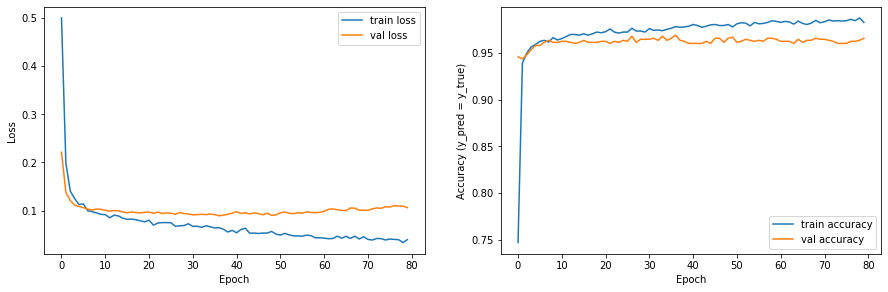

In [48]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [49]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

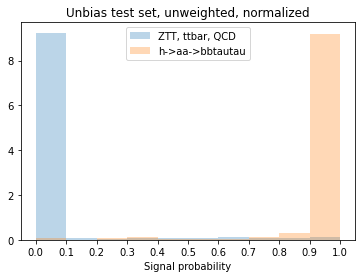

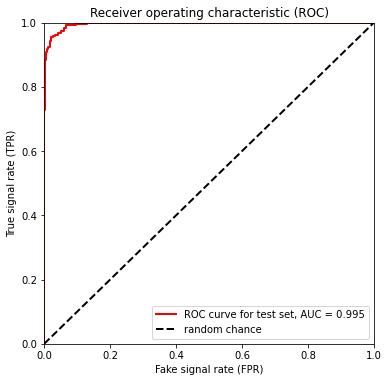

Test loss, test accuracy: [0.10084863343333776, 0.9590708017349243]


In [50]:
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'ZTT, ttbar, QCD')
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Unbias test set, unweighted, normalized')
pyplot.xlabel('Signal probability')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

In [ ]:
pyplot.hist(model.predict(X_obs), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Observed data')
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'ZTT, ttbar, QCD (MC test set)', histtype = 'step')
#pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Write model prediction to root files

## Load all root files one by one

In [51]:
from root_numpy import array2root

infolder = 'root_raw/em18_raw/'
outfolder = 'root_outputs/em18_outputs/'

inpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths)):
    inpaths[i] = infolder + inpaths[i]
    outpaths[i] = outfolder + outpaths[i]

allfiles = []
for i in range(len(inpaths)):
    allfiles.append(ROOT.RDataFrame('emu_tree', inpaths[i]))


for i in range(len(allfiles)):
    allfiles[i] = allfiles[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1e', m_b1e)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2e', m_b2e)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbe', m_bbe)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1e', dR_b1e)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2e', dR_b2e)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbe', dR_bbe)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_e', mT_e)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('mT_tt', mT_tt)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
print(len(allfiles))

46


## Data pre-processing

In [52]:
for i in range(len(allfiles)):
    allfiles[i] = pd.DataFrame(allfiles[i].AsNumpy(feature_list))
    allfiles[i] = allfiles[i].values
    allfiles[i] = scaler.transform(allfiles[i])
    print(inpaths[i])

root_raw/em18_raw/DY.root
root_raw/em18_raw/DY1.root
root_raw/em18_raw/DY2.root
root_raw/em18_raw/DY3.root
root_raw/em18_raw/DY4.root
root_raw/em18_raw/GGHTT.root
root_raw/em18_raw/GGHWW.root
root_raw/em18_raw/GGZHLLTT.root
root_raw/em18_raw/GGZHNNTT.root
root_raw/em18_raw/GGZHQQTT.root
root_raw/em18_raw/GGZHWW.root
root_raw/em18_raw/ST_tW_antitop.root
root_raw/em18_raw/ST_tW_top.root
root_raw/em18_raw/ST_t_antitop.root
root_raw/em18_raw/ST_t_top.root
root_raw/em18_raw/TTTo2L2Nu.root
root_raw/em18_raw/TTToHadronic.root
root_raw/em18_raw/TTToSemiLeptonic.root
root_raw/em18_raw/VBFHTT.root
root_raw/em18_raw/VBFHWW.root
root_raw/em18_raw/VV2L2Nu.root
root_raw/em18_raw/WZ2L2Q.root
root_raw/em18_raw/WZ3LNu.root
root_raw/em18_raw/WminusHTT.root
root_raw/em18_raw/WminusHWW.root
root_raw/em18_raw/WplusHTT.root
root_raw/em18_raw/WplusHWW.root
root_raw/em18_raw/ZHTT.root
root_raw/em18_raw/ZHWW.root
root_raw/em18_raw/ZZ2L2Q.root
root_raw/em18_raw/ZZ4L.root
root_raw/em18_raw/data_obs.root
root_raw

## Feed to NN and write outputs to root files

In [53]:
for i in range(len(allfiles)):
    y_pred = model.predict(allfiles[i])
    y_pred = np.array(y_pred, dtype = [('pred_2b', np.float32)])
    array2root(y_pred, filename = outpaths[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths[i])

root_outputs/em18_outputs/DY.root
root_outputs/em18_outputs/DY1.root
root_outputs/em18_outputs/DY2.root
root_outputs/em18_outputs/DY3.root
root_outputs/em18_outputs/DY4.root
root_outputs/em18_outputs/GGHTT.root
root_outputs/em18_outputs/GGHWW.root
root_outputs/em18_outputs/GGZHLLTT.root
root_outputs/em18_outputs/GGZHNNTT.root
root_outputs/em18_outputs/GGZHQQTT.root
root_outputs/em18_outputs/GGZHWW.root
root_outputs/em18_outputs/ST_tW_antitop.root
root_outputs/em18_outputs/ST_tW_top.root
root_outputs/em18_outputs/ST_t_antitop.root
root_outputs/em18_outputs/ST_t_top.root
root_outputs/em18_outputs/TTTo2L2Nu.root
root_outputs/em18_outputs/TTToHadronic.root
root_outputs/em18_outputs/TTToSemiLeptonic.root
root_outputs/em18_outputs/VBFHTT.root
root_outputs/em18_outputs/VBFHWW.root
root_outputs/em18_outputs/VV2L2Nu.root
root_outputs/em18_outputs/WZ2L2Q.root
root_outputs/em18_outputs/WZ3LNu.root
root_outputs/em18_outputs/WminusHTT.root
root_outputs/em18_outputs/WminusHWW.root
root_outputs/em18_